In [1]:
# Import the necesssary libraries

import warnings

warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import (CountVectorizer, TfidfTransformer, TfidfVectorizer)
from sklearn.cluster import (KMeans, AffinityPropagation, AgglomerativeClustering)
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import (PCA, TruncatedSVD)
from nltk.tokenize.treebank import TreebankWordDetokenizer
from sklearn.metrics import (silhouette_score, silhouette_samples, calinski_harabasz_score, davies_bouldin_score)
from sklearn.model_selection import train_test_split
from Levenshtein import distance
from strsimpy.normalized_levenshtein import NormalizedLevenshtein

import difflib
import string

from nltk.tokenize.treebank import TreebankWordDetokenizer

## Data Wrangling

In [2]:
# Import the excel file. The excel workbook just has one sheet, so no further action is necessary

data = pd.read_excel(io = 'potential-talents.xlsx')

In [3]:
# See how the data looks like

data.head()

,id,job_title,location,connection,fit
0,1,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,NaN
1,2,Native English Teacher at EPIK (English Progra...,Kanada,500+,NaN
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN
3,4,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN
4,5,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,NaN


In [4]:
# Check out the shape of the data frame

data.shape

(104, 5)

In [5]:
# Check the types of each data frame

data.dtypes

id              int64
job_title      object
location       object
connection     object
fit           float64
dtype: object

In [6]:
# Count the Null Values

for col in data.columns:
    print(col)
    print(data[col].isna().sum())

id
0
job_title
0
location
0
connection
0
fit
104


In [7]:
# Count the values for conections and locations to get insights of what is the most common locations and connections
# numbers

# Count values for location

data['location'].value_counts(ascending = False)


Kanada                                 12
Raleigh-Durham, North Carolina Area     8
Houston, Texas Area                     8
Greater New York City Area              7
Houston, Texas                          7
Denton, Texas                           6
San Francisco Bay Area                  5
Greater Philadelphia Area               5
İzmir, Türkiye                          4
Lake Forest, California                 4
Atlanta, Georgia                        4
Amerika Birleşik Devletleri             2
Austin, Texas Area                      2
Chicago, Illinois                       2
Greater Atlanta Area                    2
Long Beach, California                  1
Las Vegas, Nevada Area                  1
Lafayette, Indiana                      1
Los Angeles, California                 1
Highland, California                    1
Greater Chicago Area                    1
Jackson, Mississippi Area               1
Milpitas, California                    1
New York, New York                

Most of the candidates here are located in "Kanada", Houston Texas (we can replace "Houston, Texas Area"  to "Houston, Texas" because I assume they mean the same exact location. Same on Chicago Greater Chicago Area, New York and so on.  I have to figure out a way to make the program match those type of locations and replace the values on the feature engineering part.

In [8]:
# Count Values for connections

data['connection'].value_counts(ascending = False)

500+     44
85        7
61        7
44        6
1         5
2         4
4         2
390       2
7         2
57        2
5         1
455       1
9         1
268       1
16        1
82        1
19        1
212       1
155       1
409       1
103       1
349       1
415       1
18        1
39        1
40        1
174       1
48        1
49        1
50        1
52        1
71        1
64        1
Name: connection, dtype: int64

In [9]:
# Count the values for job_title

data['job_title'].value_counts(ascending = False)

Aspiring Human Resources Professional                                                                                    7
Student at Humber College and Aspiring Human Resources Generalist                                                        7
2019 C.T. Bauer College of Business Graduate (Magna Cum Laude) and aspiring Human Resources professional                 7
People Development Coordinator at Ryan                                                                                   6
Aspiring Human Resources Specialist                                                                                      5
Native English Teacher at EPIK (English Program in Korea)                                                                5
HR Senior Specialist                                                                                                     5
Advisory Board Member at Celal Bayar University                                                                          4
Human Resources 

###### The fit is the dependant variable. We need to determine whats the fit rank for each candidate (Starting by 1)

###### This problem is more about data/feature engineering. We can't do too much data visualization nor statistical inference. After doing the feature engineering process, we can move on to the modeling part. 

## Feature Engineering

In [10]:
# Convert everything into lower case letters

data['job_title'] = data['job_title'].str.lower()
data['location'] = data['location'].str.lower()


In [11]:
# Normalize the language inconsistencies

data['location'] = data['location'].replace(to_replace = ['kanada', 'türkiye', 'amerika birleşik devletleri'], 
                                            value = ['canada', 'turkey', 'united states america'], 
                                            regex = True)



In [12]:
# Replace all the rows on location with words such as greater, area, etc, so in the dataframe I will only see the city
# and the state

data['location'] = data['location'].replace(to_replace = ['area', 'greater'], value = '', regex = True)


# Remove spaces in all columns

data.columns = data.columns.str.replace(' ', '')

In [13]:
# Create columns with tokenized words

data['job_title'] = data.apply(lambda x: word_tokenize(x['job_title']), axis = 1)
data['location'] = data.apply(lambda x: word_tokenize(x['location']), axis = 1)


In [14]:
# Create a nested list where I will make a for loop to remove all the stop words

# List for job_title

job_title_values = data['job_title'].values

# List for location

location_values = data['location'].values

In [15]:
# Define a function to remove points, parentheses, dots, commas, etc

def cleaner(array):
    
    clean_list = []
    
    for i in array:
        
        # Create an empty list that will be appended to the clean_list to keep dimensions
        empty_list = []
        
        for j in i:
            
            # Use translate function in python to replace all the punctuation values to None and then remove them
            value = j.translate({ord(j):None for j in string.punctuation})
            # Append the desirables values
            empty_list.append(value)
        # Append the empty list to the clean list
        clean_list.append(empty_list)
    # Return the clean list
    return clean_list


In [16]:
# Apply the function to the job_title and location column

job_title_cleaner = cleaner(array = job_title_values)

location_cleaner = cleaner(array = location_values)

In [17]:
# Define a function to remove the None

def none_remover(array):
    # Create an empty list
    clean_list = []
    # Start a for loop for each sublist in the complete list
    for i in array:
        # Filter the none values in each sublist
        value = list(filter(None, i))
        # Append the desired string
        clean_list.append(value)
    # Return the clean list
    return clean_list
    

In [18]:
# Apply the none_remove function to the job_title and location column

job_title_cleaner2 = none_remover(array = job_title_cleaner)

location_cleaner2 = none_remover(array = location_cleaner)

In [19]:
# Define a function to remove the stop words

def stop_words_remover(array):
    # Set the stop workds
    stop_words = set(stopwords.words('english'))
    # Create an empty list
    clean_list = []
    for i in array:
        # Create an empty list with the sublist
        empty_list = []  
        for j in i:
            if j not in stop_words:  
                empty_list.append(j)  
        clean_list.append(empty_list)
    return clean_list
            

In [20]:
# Use the function to remove the stop words in the job_title and location column

job_title_cleaner3 = stop_words_remover(array = job_title_cleaner2)

location_cleaner3 = stop_words_remover(array = location_cleaner2)

In [21]:
# Replace the data frames for the clean ones

data['job_title'] = job_title_cleaner3

data['location'] = location_cleaner3

In [22]:
# Untokenize the location column

untokenized = [TreebankWordDetokenizer().detokenize(i) for i in location_cleaner3]

In [23]:
# Set the column location to be the untokenized data

data['location'] = untokenized

# Change philadelphia row for the city plus state Pensilvania and new york city to new york, new york

data['location'] = data['location'].replace(to_replace = 'philadelphia',value = 'philadelhia pensilvania')\
                    .replace(to_replace = 'new york city', value = 'new york new york')

In [24]:
# Quickly check the new value counts

data['location'].value_counts()

houston texas                   15
canada                          12
new york new york                8
raleighdurham north carolina     8
denton texas                     6
san francisco bay                5
philadelhia pensilvania          5
i̇zmir turkey                    4
atlanta georgia                  4
lake forest california           4
chicago illinois                 2
austin texas                     2
atlanta                          2
united states america            2
baltimore maryland               1
milpitas california              1
lafayette indiana                1
san jose california              1
dallasfort worth                 1
monroe louisiana                 1
highland california              1
kokomo indiana                   1
las vegas nevada                 1
boston                           1
virginia beach virginia          1
long beach california            1
jackson mississippi              1
myrtle beach south carolina      1
chicago             

In [25]:
# Untokenize the job_title column

untokenized = [TreebankWordDetokenizer().detokenize(i) for i in job_title_cleaner3]

# Set the new column to be the untokenized data
data['job_title'] = untokenized    

In [26]:
# Quickly check the value counts

data['job_title'].value_counts()

2019 ct bauer college business graduate magna cum laude aspiring human resources professional                7
student humber college aspiring human resources generalist                                                   7
aspiring human resources professional                                                                        7
people development coordinator ryan                                                                          6
hr senior specialist                                                                                         5
native english teacher epik english program korea                                                            5
aspiring human resources specialist                                                                          5
svp chro marketing communications csr officer engie houston woodlands energy gphr sphr                       4
human resources coordinator intercontinental buckhead atlanta                                                4
a

## Modeling

In [27]:
# From the data frame create one column with all the information together

# Change the number 500+ for just 500

data['connection'] = data['connection'].replace(to_replace = '500', value = 500, regex = True)
 
# Change the connection column to strings

data['connection'] = data['connection'].astype(str)

# Have all the strings in one column

data['independent'] = data['job_title'].add(' ').add(data['location'])

In [28]:
data['independent'].value_counts()

2019 ct bauer college business graduate magna cum laude aspiring human resources professional houston texas                          7
student humber college aspiring human resources generalist canada                                                                    7
people development coordinator ryan denton texas                                                                                     6
aspiring human resources professional raleighdurham north carolina                                                                   6
hr senior specialist san francisco bay                                                                                               5
aspiring human resources specialist new york new york                                                                                5
native english teacher epik english program korea canada                                                                             5
svp chro marketing communications csr officer engie hou

In [29]:
data.head()

,id,job_title,location,connection,fit,independent
0,1,2019 ct bauer college business graduate magna ...,houston texas,85,NaN,2019 ct bauer college business graduate magna ...
1,2,native english teacher epik english program korea,canada,500,NaN,native english teacher epik english program ko...
2,3,aspiring human resources professional,raleighdurham north carolina,44,NaN,aspiring human resources professional raleighd...
3,4,people development coordinator ryan,denton texas,500,NaN,people development coordinator ryan denton texas
4,5,advisory board member celal bayar university,i̇zmir turkey,500,NaN,advisory board member celal bayar university i...


In [30]:
# Set the independant variable

X = data['independent'].values

In [31]:
# Create all the values to single string to see the most important values in all the document

X2 = ''.join(X)
X2 = [X2]

In [32]:
# Define a function to calculate the word importance

def word_importance_doc(array):
    # Calculate the word importance for each column
    # Set the stop words to english
    tfidfvectorizer = TfidfVectorizer(analyzer='word',stop_words= 'english')
    # Transform the X variable
    tfidf_wm = tfidfvectorizer.fit_transform(array)
    # Get the feature names
    tfidf_tokens = tfidfvectorizer.get_feature_names()
    # Save the results in a dataframe
    df_tfidfvect = pd.DataFrame(data = tfidf_wm.toarray(), index = array, columns = tfidf_tokens)
    # Return the data frame
    return df_tfidfvect

# Define a function that will calculate the word importance for each feature

def word_importance(df, n_row):
    df_converted = df.iloc[n_row, :]
    df_converted = df_converted[df_converted > 0]
    return df_converted

In [33]:
# Use the function to calculate the word importance for the first X array

df_word_importance = word_importance_doc(array = X)

In [34]:
# As an example, let's check the first row (0 indexed)

word_importance(df = df_word_importance, n_row = 0)

2019            0.304116
aspiring        0.176151
bauer           0.304116
business        0.269620
college         0.250635
ct              0.304116
cum             0.304116
graduate        0.304116
houston         0.245144
human           0.129901
laude           0.304116
magna           0.304116
professional    0.222008
resources       0.129901
texas           0.207174
Name: 2019 ct bauer college business graduate magna cum laude aspiring human resources professional houston texas, dtype: float64

In [35]:
# Get the word importance using all the document

df_word_importance2 = word_importance_doc(array = X2)

# Save the df as a transpose (in this particular case)

df_word_importance2_transponse = df_word_importance2.T

# Check Out the word imortance

word_importance = df_word_importance2_transponse.nlargest(n = 10, columns = df_word_importance2_transponse.columns[0])

word_importance.columns = ['Importance']

In [36]:
# See the most important words in our document

word_importance

,Importance
resources,0.608930
human,0.483278
professional,0.193311
houston,0.183646
aspiring,0.164314
new,0.154649
college,0.135318
generalist,0.135318
specialist,0.115987
university,0.115987


In [37]:
# Define a function to start the pipeline for the preprocessor of the data

def pipeline(est1):
    # The pipeline will just take one argument that will be which type of preprocessor does the user want.
    # To reduce the dimensionality, I'm suing the TruncatedSVD function to 2 components
    pipe = Pipeline([('est1', est1), ('pca', TruncatedSVD(n_components = 2))])
    return pipe

In [38]:
# Define the pipeline for the estimator (Model that will be used)

def pipeline2(est2):
    # This function will just take one argument (The model the user wants)
    pipe2 = Pipeline([('est2', est2)])
    return pipe2

In [39]:
# Define the pipeline that will join the pipeline for preprocessing and the predictor model

def pipeline3(pipeline, pipeline2):
    # The third pipeline will make a complete pipeline with the preprocessor and the predictor
    pipe3 = Pipeline([('preprocessor', pipeline), ('predictor', pipeline2)])
    return pipe3

In [40]:
# Define a dataframe that will store all the results 

def results_df(preprocessing, predictions):
    # Save the points with the predictions
    df = pd.DataFrame(preprocessing, columns = ['x', 'y'])
    df['results'] = predictions
    # Concat the original columns from the dataset
    df['id'] = data['id']
    df['job_title'] = X
    return df

In [41]:
def KMeans_elbow(transformer, array):
    distortions = []
    clusters = np.arange(2,21,1)
    
    for c in clusters:
        pipe_preprocessing = pipeline(est1 = transformer)
        pipe_predictor = pipeline2(est2 = KMeans(n_clusters = c))
        pipe_kmeans = pipeline3(pipeline = pipe_preprocessing, pipeline2 = pipe_predictor)
        
        pipe_kmeans.fit(array)
        distortions.append(pipe_kmeans['predictor']['est2'].inertia_)
        
    plt.plot(clusters, distortions, 'bx-')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.title('The Elbow Method to find the optimal number of clusters')
    plt.xticks(clusters)
    return plt.show

In [42]:
def silhoutte_score_validation(model, transformer, array):

    clusters = np.arange(2,21,1)
    
    preprocessed_data = transformer
    
    preprocessed_data = transformer.fit_transform(array)
    
    preprocessed_data = preprocessed_data.todense()
    
    for n_clusters in clusters:
    
        # Create a subplot with 1 row and 2 columns
        fig, ax1 = plt.subplots(1, 1)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        predictor = model(n_clusters)
        cluster_labels = predictor.fit_predict(preprocessed_data)
        

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(preprocessed_data, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(preprocessed_data, cluster_labels)

        y_lower = 10
    
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            #cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
 
        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),fontsize=14, fontweight='bold')

    return plt.show()
    

In [43]:
# Define the function to plot the scatter plots with the different clusters

def plot_scatter(df, keyword, title):
    # This will group based on the different labels
    sns.scatterplot(x = 'x', y = 'y', hue = 'results', data = df, palette = sns.color_palette("tab10", 
                                                            len(df['results'].unique())))
    # The keywords will be plotted in the space 
    plt.scatter(keyword[0][0], keyword[0][1], s = 70, marker = 'X', color = 'black')
    plt.legend(loc = (1.05,0.5))
    plt.title(title)
    return plt.show()

In [44]:
# Define a function to calculate the extra row that calculates distance

def euclidean_distance(df, keyword):
    #Euclidean distance use the pythagoras theorem to calculate the distance between two coordenates
    distance = [np.sqrt(((
                    df.iloc[i][0] - keyword[0][0]) ** 2) 
                        + ((df.iloc[i][1] - keyword[0][1]) ** 2)) for i in range(0, len(df))]
    # Save the euclidean distance in a column
    df['euclidean_distance'] = distance
    # Sort the values in ascending order (lower euclidean distance means higher fit)
    df = df.sort_values(by = 'euclidean_distance', ascending = True)
    # Use softmax action with the exponential distance to calculate probabilities.
    df['euclidean_fit'] = np.exp(-df['euclidean_distance'])
    df = df.reset_index(drop = True)
    return df

In [45]:
# Define a function to calculate the Levenshtein Distance

def levenshtein_distance(df, string):
    distances = []
    for i in df['job_title']:
        normalized_levenshtein = NormalizedLevenshtein()
        d = normalized_levenshtein.distance(s0 = i, s1 = string)
        distances.append(d)
    df['levenshtein_distance'] = distances
    df = df.sort_values(by = 'levenshtein_distance', ascending = True)
    df['levenshtein_distance_fit'] = np.exp(-df['levenshtein_distance'])
    df = df.reset_index(drop = True)
    return df

In [46]:
# Define a final function that will create a new column with the final fit score that will be the weighted average

def final_fit(df):
    df['final_fit_model'] = (df['levenshtein_distance_fit']*0.5) + (
                                        0.5 * df['euclidean_fit'])
    df = df.sort_values(by = 'final_fit_model', ascending = False)
    df = df.reset_index(drop = True)
    return df


In [47]:
# Define a function that prints the Calinski Score

def metric_score(array1, array2):
    score1 = calinski_harabasz_score(array1, array2)
    score2 = davies_bouldin_score(array1, array2)
    print('The Calinski Harabasz Score is {}'.format(score1))
    print('The Davies Bouldin score is {}'.format(score2))

### K-Means

In [48]:
# Establish how many candidates are going to be taken in consideration

number_candidates = int(input('Insert Number of candidates you want to check out:'))

Insert Number of candidates you want to check out:7


In [49]:
# Specify the keywords

string_keyword = input("Keyword to the candidate's checking:")

Keyword to the candidate's checking:aspiring human resources


#### Count Vectorization

<function matplotlib.pyplot.show(*args, **kw)>

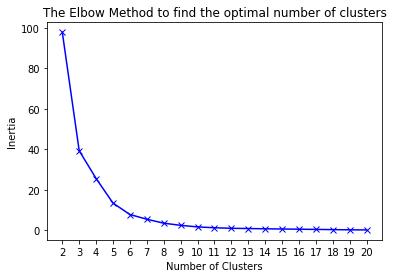

In [50]:
# Plot the Elbow Method to find the optimal number of clusters

KMeans_elbow(transformer = CountVectorizer(lowercase = False), array = X)

From the elbow method, I'm maybe using 4-5 clusters

For n_clusters = 2 The average silhouette_score is : 0.13054135816302218
For n_clusters = 3 The average silhouette_score is : 0.18166724252303304
For n_clusters = 4 The average silhouette_score is : 0.21102882605429304
For n_clusters = 5 The average silhouette_score is : 0.2555692598495406
For n_clusters = 6 The average silhouette_score is : 0.3101286113430206
For n_clusters = 7 The average silhouette_score is : 0.2910182755980028
For n_clusters = 8 The average silhouette_score is : 0.35679772357210937
For n_clusters = 9 The average silhouette_score is : 0.3426410504644814
For n_clusters = 10 The average silhouette_score is : 0.3816996915223709
For n_clusters = 11 The average silhouette_score is : 0.4039600082153244
For n_clusters = 12 The average silhouette_score is : 0.447604794909128
For n_clusters = 13 The average silhouette_score is : 0.4807879349883539
For n_clusters = 14 The average silhouette_score is : 0.4840443144678294
For n_clusters = 15 The average silhouette_score is : 0.

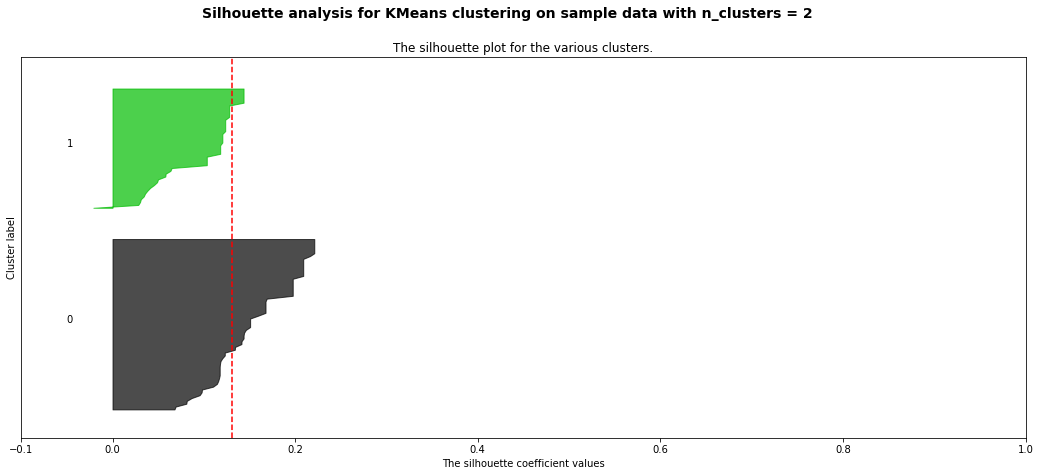

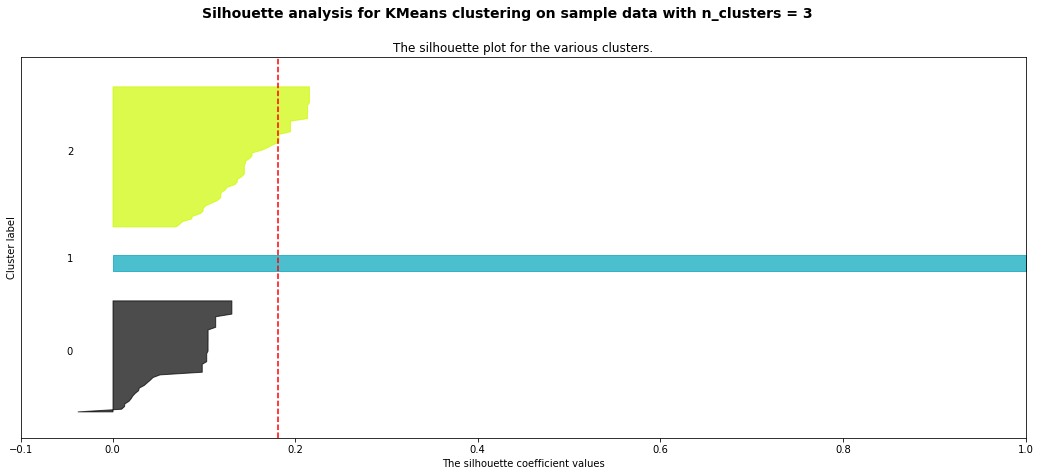

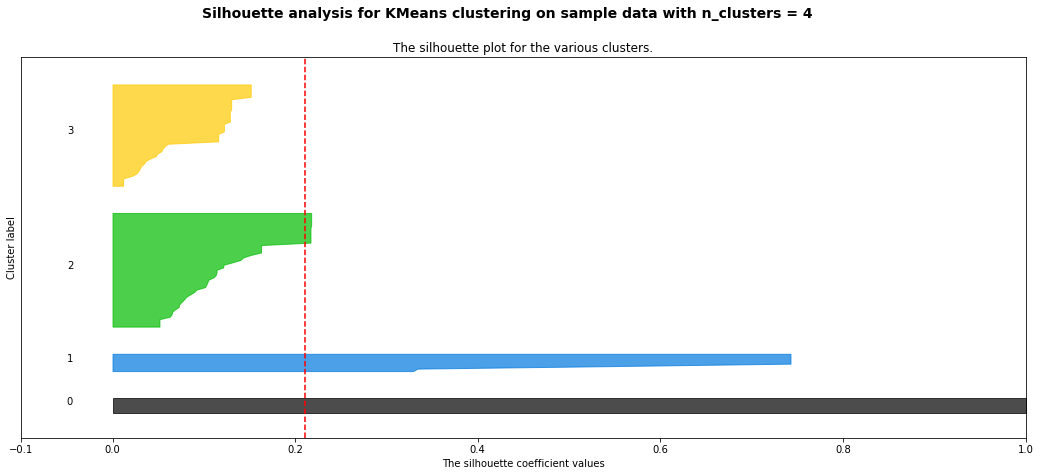

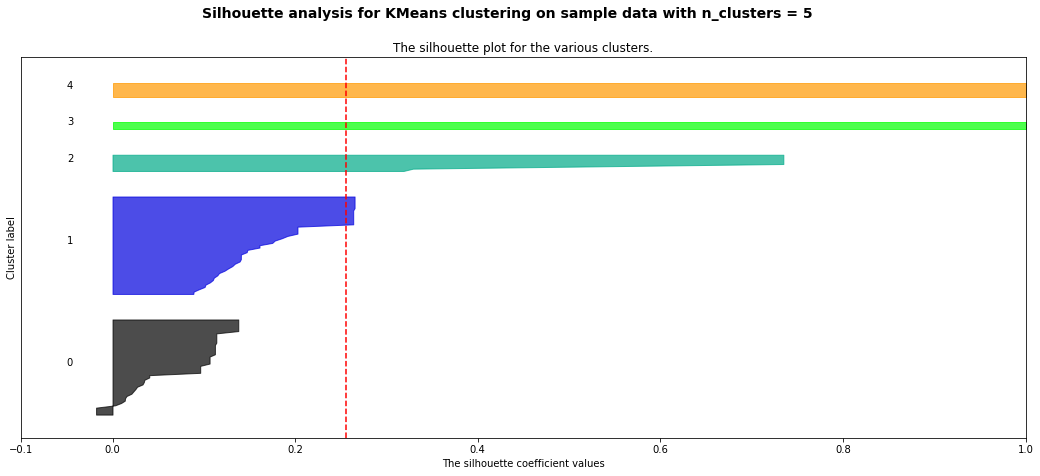

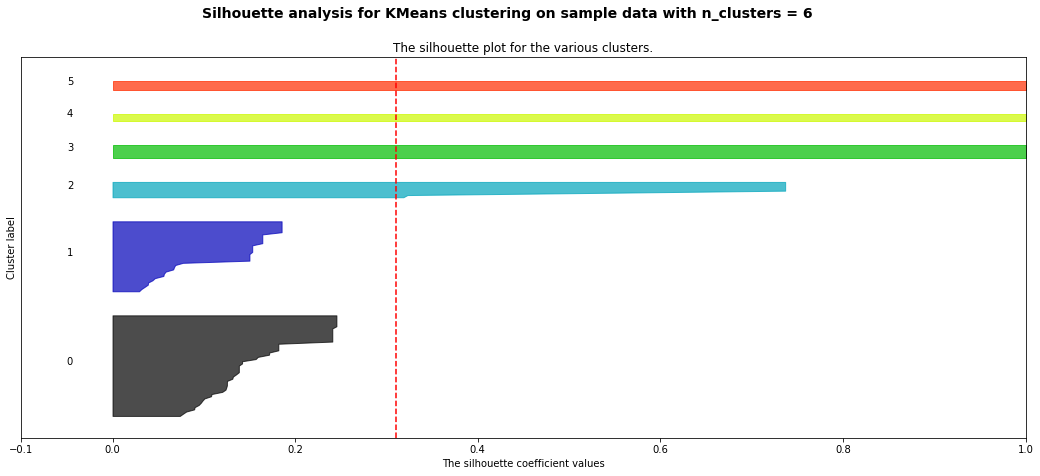

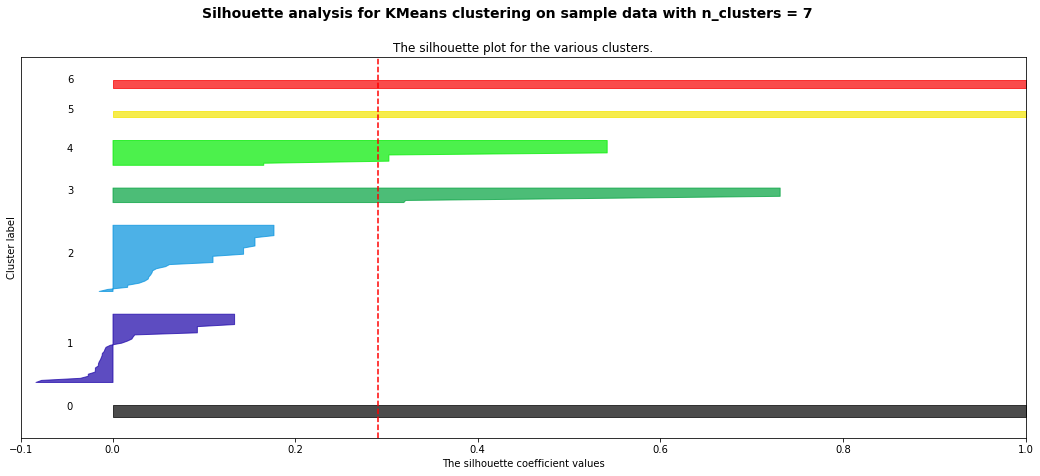

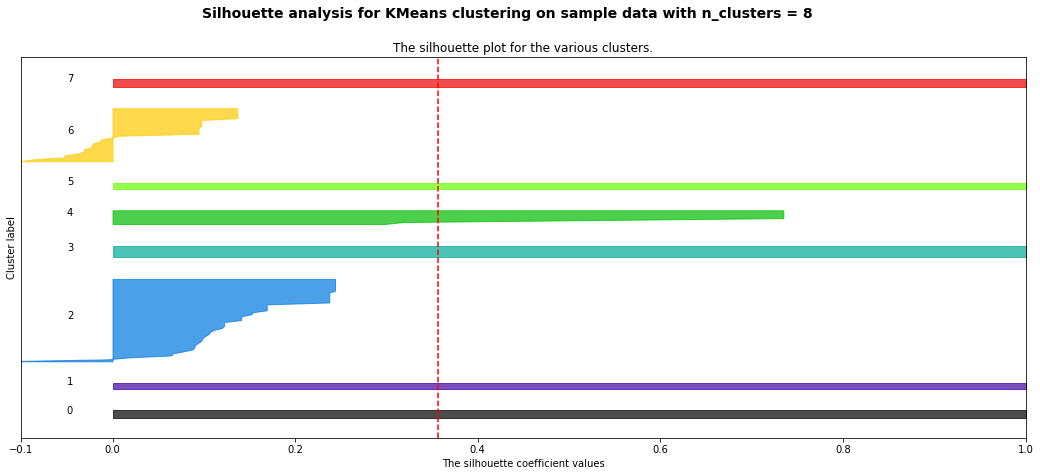

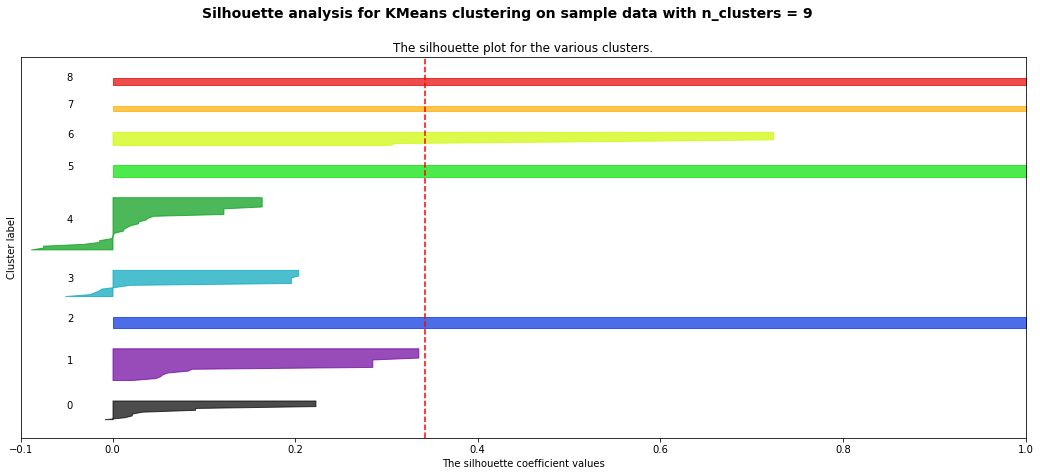

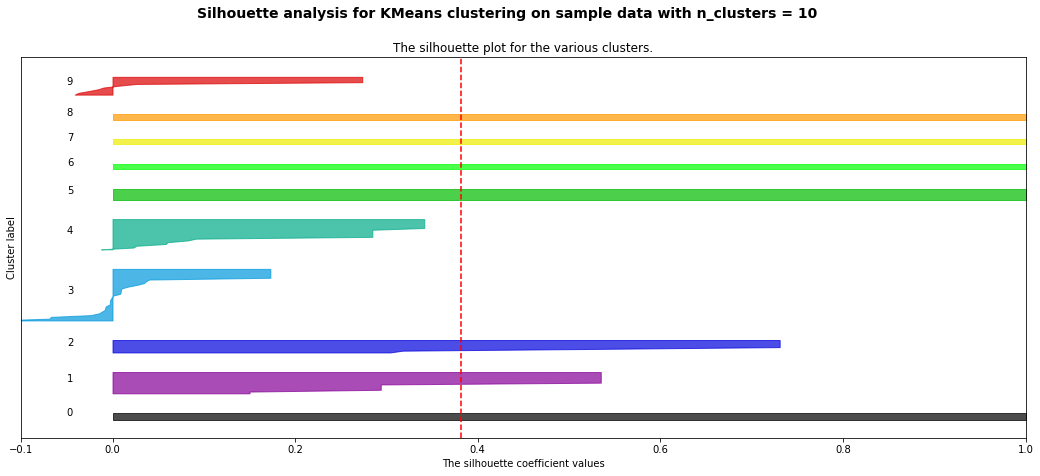

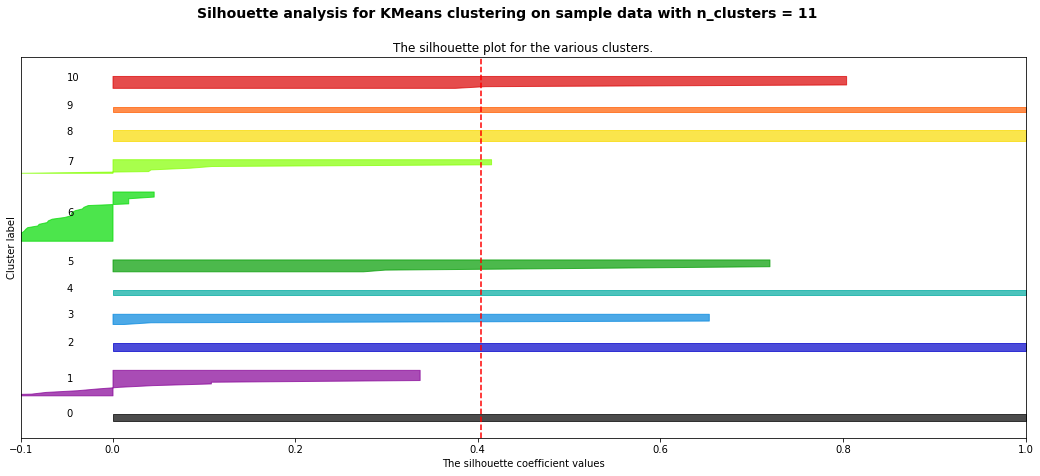

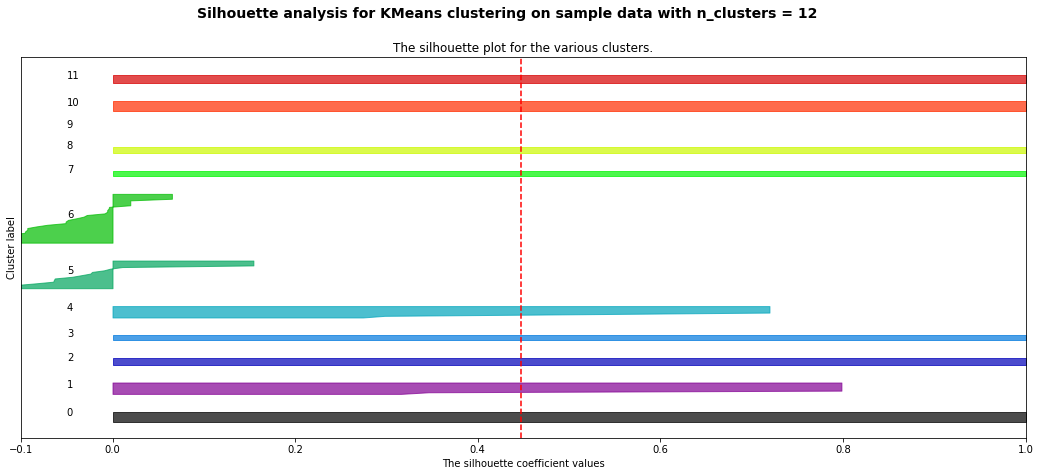

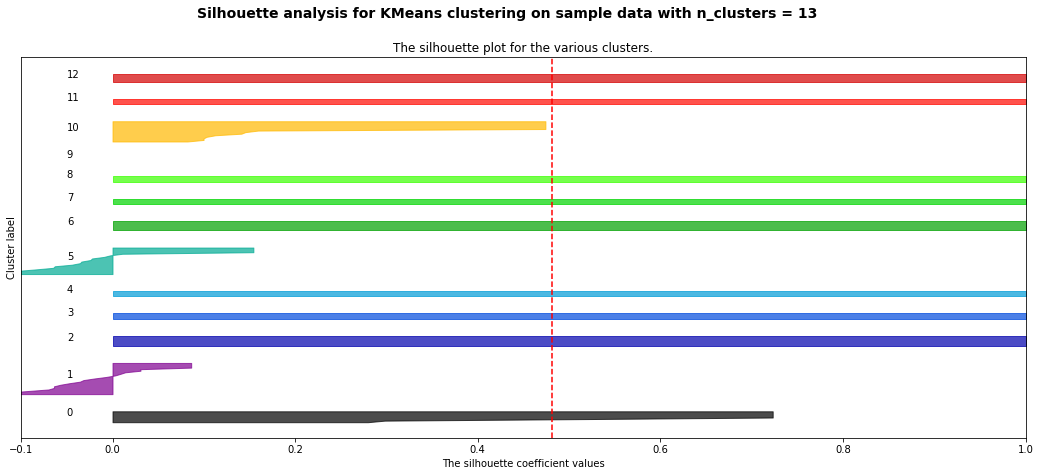

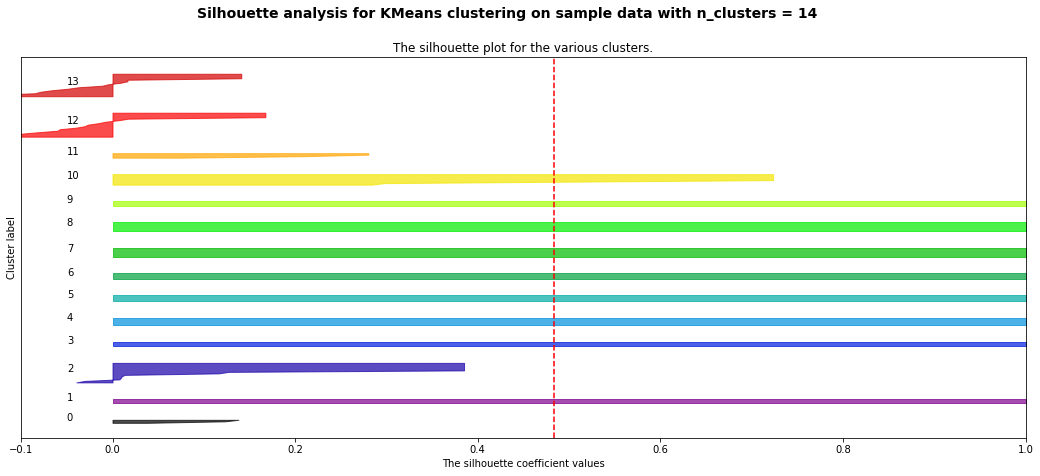

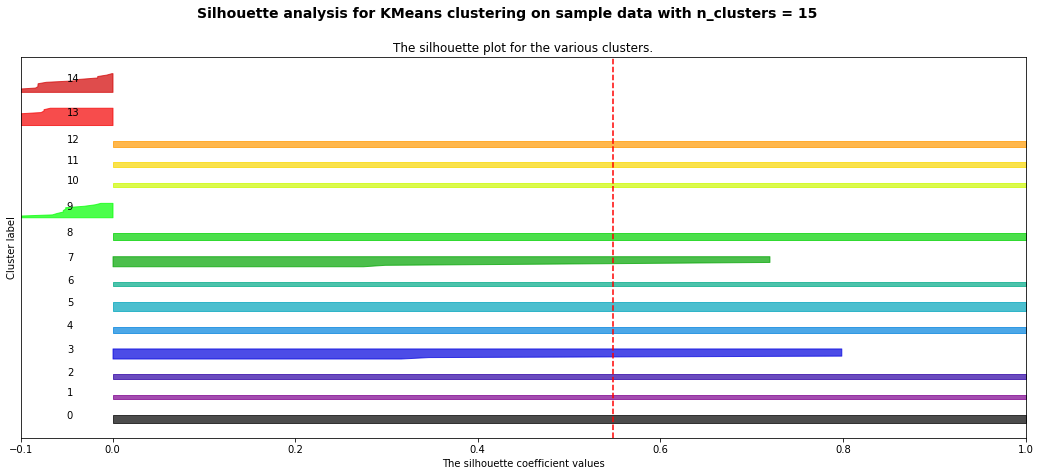

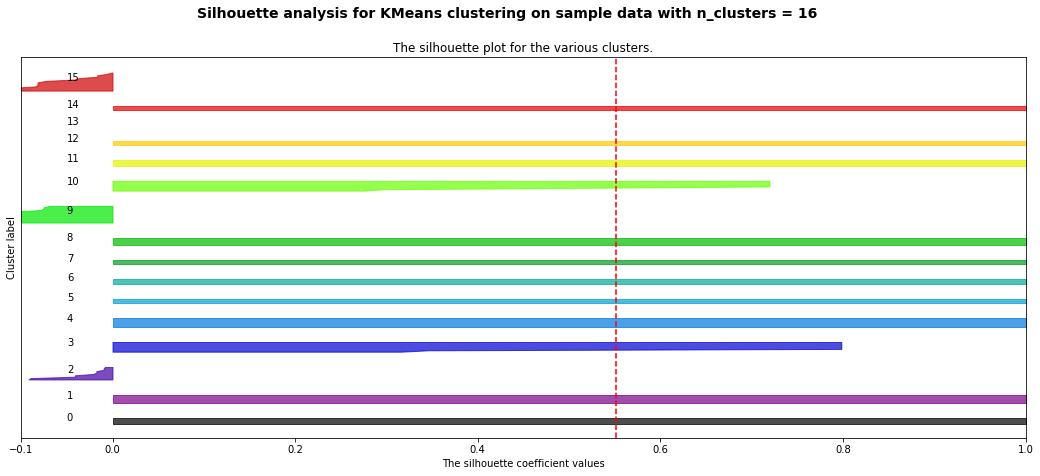

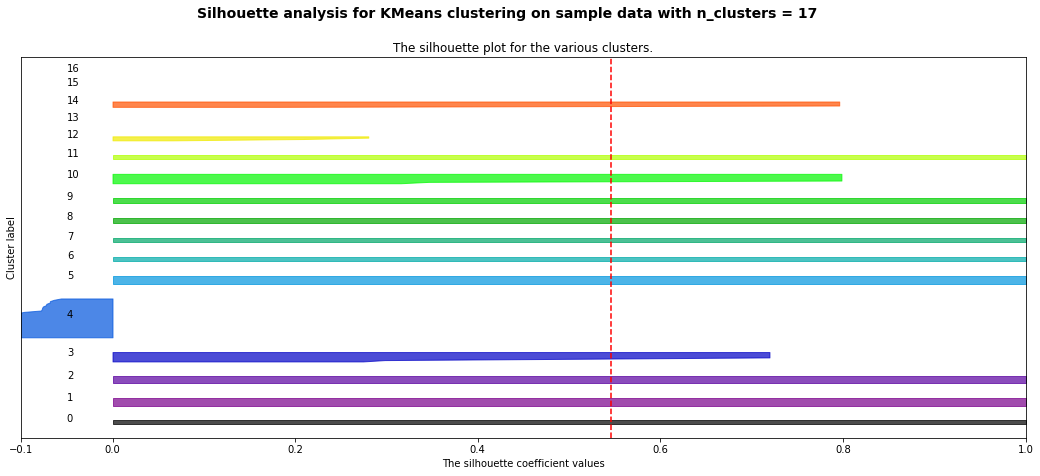

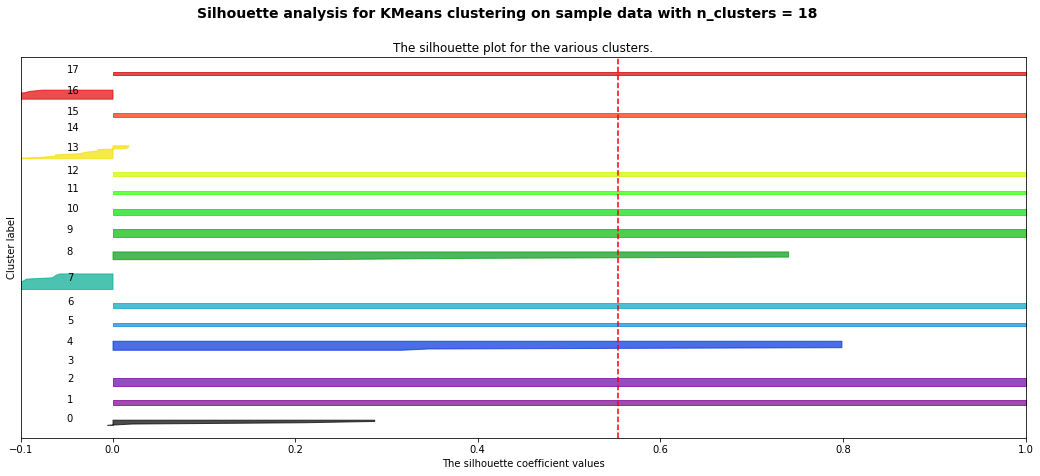

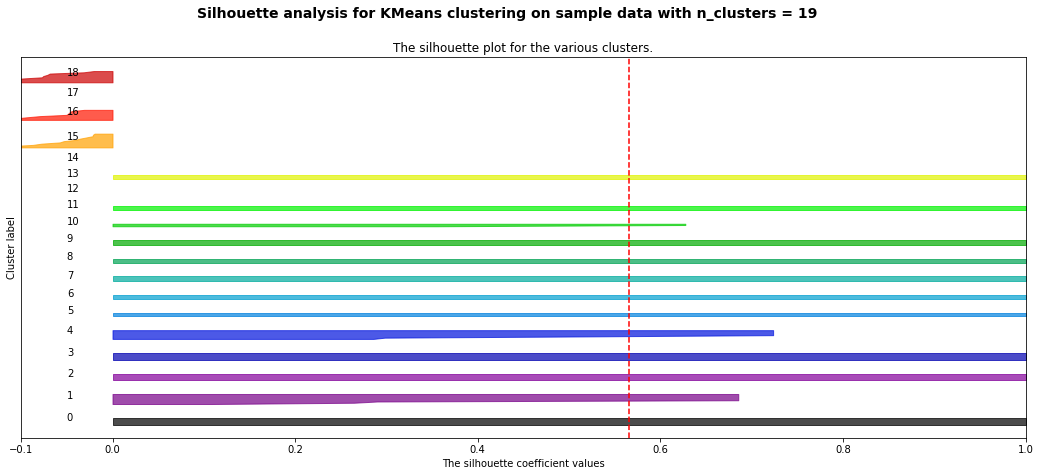

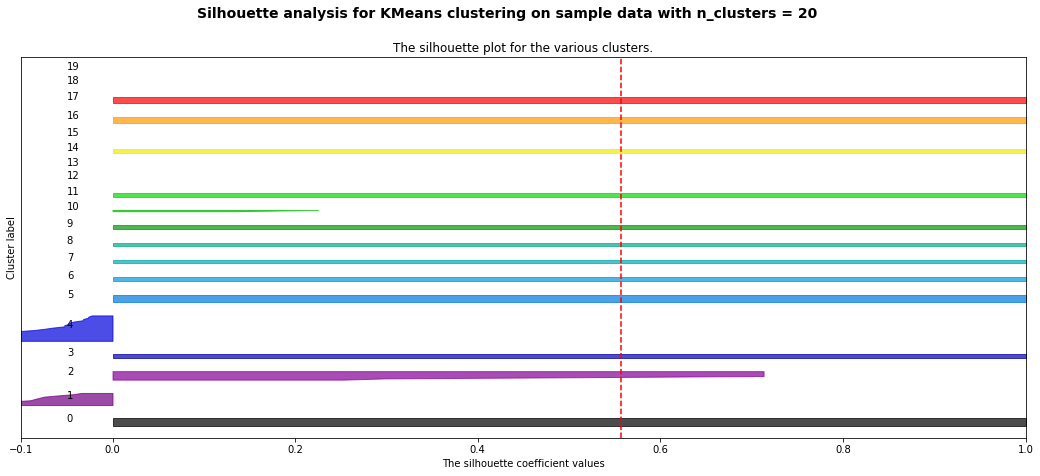

In [51]:
# Evaluate the different models using the Silhoutte Score

silhoutte_score_validation(model = KMeans, transformer = CountVectorizer(lowercase = False), array = X)

###### The best number of clusters to select after multiple repetitions would be 3 to prevent the mislabel of the clusters. 

###### Silhoutte Score for this is 0.42

In [52]:
# Creation of the pipeline with 5 as number of clusters

pipe_preprocessing = pipeline(est1 = CountVectorizer(lowercase = False))

pipe_predictor = pipeline2(est2 = KMeans(n_clusters = 4))

pipe_kmeans_cv = pipeline3(pipeline = pipe_preprocessing, pipeline2 = pipe_predictor)

# Fit the final pipeline

pipe_kmeans_cv.fit(X)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('est1', CountVectorizer(lowercase=False)),
                                 ('pca', TruncatedSVD())])),
                ('predictor',
                 Pipeline(steps=[('est2', KMeans(n_clusters=4))]))])

In [53]:
# Transform the data for the preprocessor

preprocessed_data = pipe_kmeans_cv['preprocessor'].transform(X)

# Labels Predictions

predicted_labels = pipe_kmeans_cv['predictor']['est2'].labels_

# Identify the centroids

clusters = pipe_kmeans_cv['predictor']['est2'].cluster_centers_

In [54]:
# Get the coordenates for the keyword ("Aspiring Human Resources")

keywords_preprocessed = pipe_kmeans_cv['preprocessor'].transform([string_keyword])

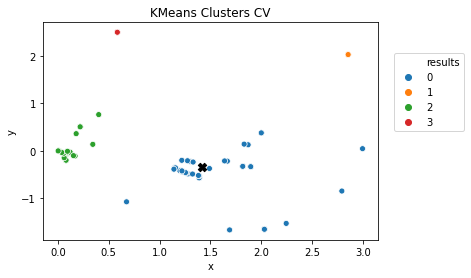

In [55]:
# Save the results in a data frame

results = results_df(preprocessing = preprocessed_data, predictions = predicted_labels)

# Plot the scatter plot with the centroids

plot_scatter(df = results, keyword = keywords_preprocessed, title = 'KMeans Clusters CV')

In [56]:
# Apply the function that calculates the Levenshtain distance

results_k_mean_levenshtein_cv = levenshtein_distance(df = results, string =  string_keyword)

In [57]:
# See the results

results_k_mean_levenshtein_cv.head(20)

,x,y,results,id,job_title,levenshtein_distance,levenshtein_distance_fit
0,1.639605,-0.214936,0,97,aspiring human resources professional kokomo i...,0.538462,0.583645
1,1.140976,-0.389583,0,89,director human resources ey atlanta,0.542857,0.581086
2,2.031748,-1.659156,0,24,aspiring human resources specialist new york n...,0.547170,0.578585
3,2.031748,-1.659156,0,36,aspiring human resources specialist new york n...,0.547170,0.578585
4,2.031748,-1.659156,0,49,aspiring human resources specialist new york n...,0.547170,0.578585
5,2.031748,-1.659156,0,6,aspiring human resources specialist new york n...,0.547170,0.578585
6,2.031748,-1.659156,0,60,aspiring human resources specialist new york n...,0.547170,0.578585
7,1.220159,-0.425125,0,99,seeking human resources position las vegas nevada,0.612245,0.542132
8,1.896942,-0.336153,0,52,student humber college aspiring human resource...,0.630769,0.532182
9,1.896942,-0.336153,0,37,student humber college aspiring human resource...,0.630769,0.532182


In [58]:
# See the fit of each person based on the euclidean distance

results_kmean_cv = euclidean_distance(df = results_k_mean_levenshtein_cv, keyword = keywords_preprocessed)

In [59]:
# Results based on the euclidean distance

results_kmean_cv.head(20)

,x,y,results,id,job_title,levenshtein_distance,levenshtein_distance_fit,euclidean_distance,euclidean_fit
0,1.490819,-0.374781,0,79,liberal arts major aspiring human resources an...,0.671233,0.511078,0.080759,0.922416
1,1.330008,-0.238213,0,84,human resources professional world leader gis ...,0.837838,0.432645,0.132295,0.876083
2,1.299063,-0.224776,0,67,human resources staffing recruiting profession...,0.764706,0.465471,0.163860,0.848861
3,1.324191,-0.491566,0,70,retired army national guard recruiter office m...,0.798165,0.450154,0.184630,0.831412
4,1.274799,-0.211042,0,74,human resources professional boston,0.800000,0.449329,0.191180,0.825984
5,1.382635,-0.521808,0,101,human resources generalist loparex raleighdurh...,0.809524,0.445070,0.191370,0.825827
6,1.389170,-0.528157,0,71,human resources generalist scottmadden inc ral...,0.802817,0.448065,0.196432,0.821658
7,1.254876,-0.460738,0,94,seeking human resources opportunities open tra...,0.768293,0.463804,0.208707,0.811633
8,1.279332,-0.487784,0,56,human resources coordinator intercontinental b...,0.844156,0.429920,0.208818,0.811543
9,1.279332,-0.487784,0,43,human resources coordinator intercontinental b...,0.844156,0.429920,0.208818,0.811543


In [60]:
results_kmean_cv = final_fit(df = results_kmean_cv)

results_kmean_cv[['id', 'job_title', 'final_fit_model']].head(number_candidates)

,id,job_title,final_fit_model
0,79,liberal arts major aspiring human resources an...,0.716747
1,97,aspiring human resources professional kokomo i...,0.681561
2,99,seeking human resources position las vegas nevada,0.672182
3,89,director human resources ey atlanta,0.666414
4,28,seeking human resources opportunities chicago ...,0.661996
5,30,seeking human resources opportunities chicago ...,0.661996
6,67,human resources staffing recruiting profession...,0.657166


In [61]:
# Calculation of the Calinski Harabasz Score

metric_score(array1 = preprocessed_data, array2 = predicted_labels)

The Calinski Harabasz Score is 186.3982753750629
The Davies Bouldin score is 0.32348061860476335


#### TF-IDF

<function matplotlib.pyplot.show(*args, **kw)>

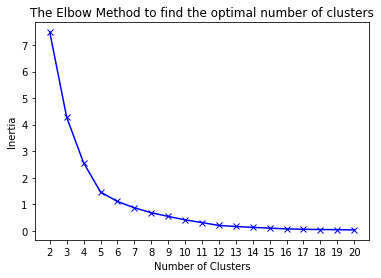

In [62]:
# Plot the Elbow Method to find the optimal number of clusters

KMeans_elbow(transformer = TfidfVectorizer(lowercase = False), array = X)

For n_clusters = 2 The average silhouette_score is : 0.072965529927415
For n_clusters = 3 The average silhouette_score is : 0.10601404351372838
For n_clusters = 4 The average silhouette_score is : 0.17199097653100376
For n_clusters = 5 The average silhouette_score is : 0.16811191335182085
For n_clusters = 6 The average silhouette_score is : 0.2493570408287189
For n_clusters = 7 The average silhouette_score is : 0.29532306148560694
For n_clusters = 8 The average silhouette_score is : 0.3339356902538746
For n_clusters = 9 The average silhouette_score is : 0.3788151462338272
For n_clusters = 10 The average silhouette_score is : 0.4187463899615607
For n_clusters = 11 The average silhouette_score is : 0.4582692250443366
For n_clusters = 12 The average silhouette_score is : 0.4843681849502731
For n_clusters = 13 The average silhouette_score is : 0.5006100329636284
For n_clusters = 14 The average silhouette_score is : 0.5081214957682143
For n_clusters = 15 The average silhouette_score is : 0.

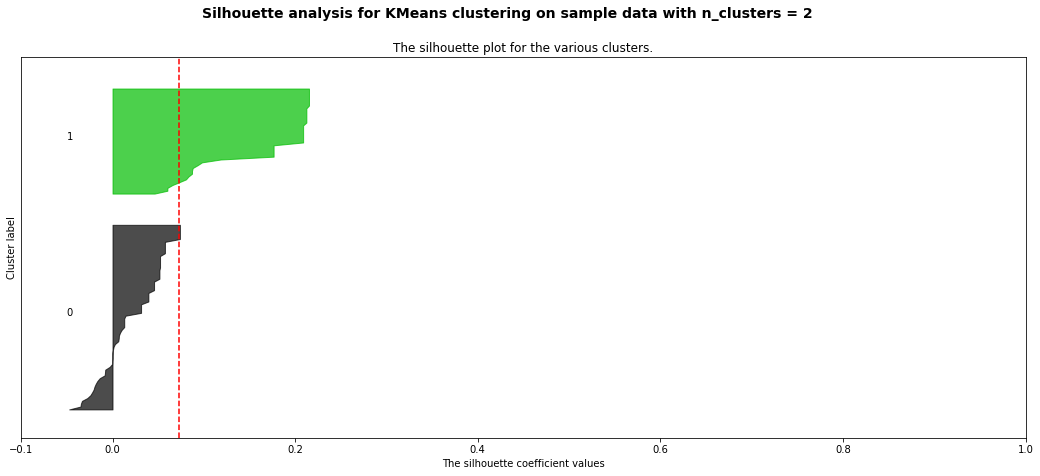

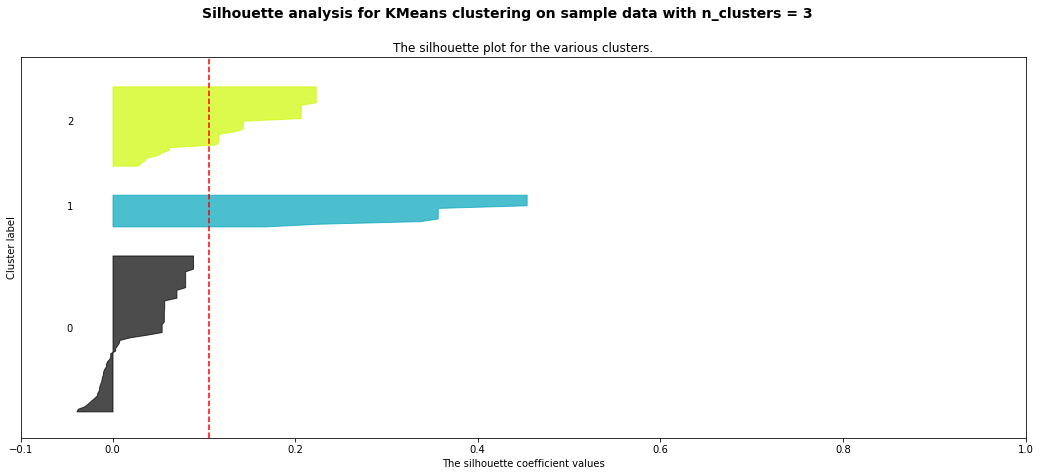

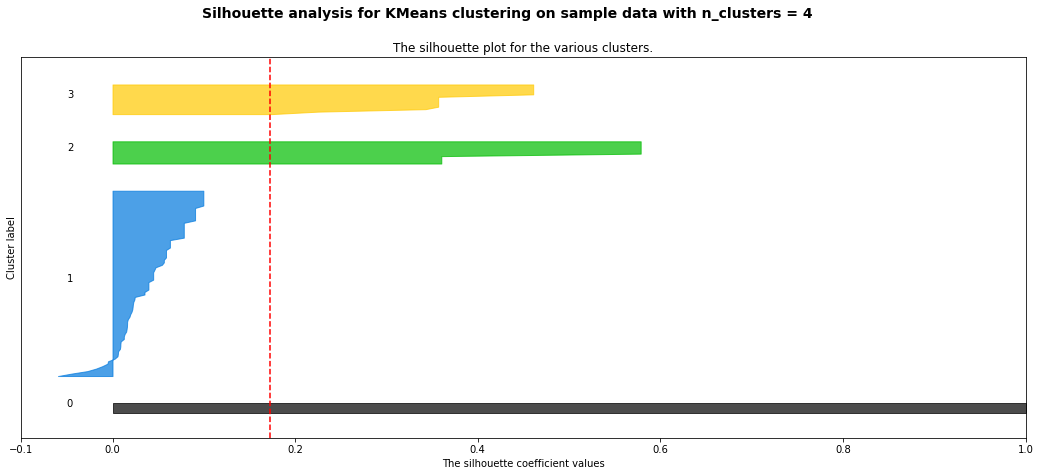

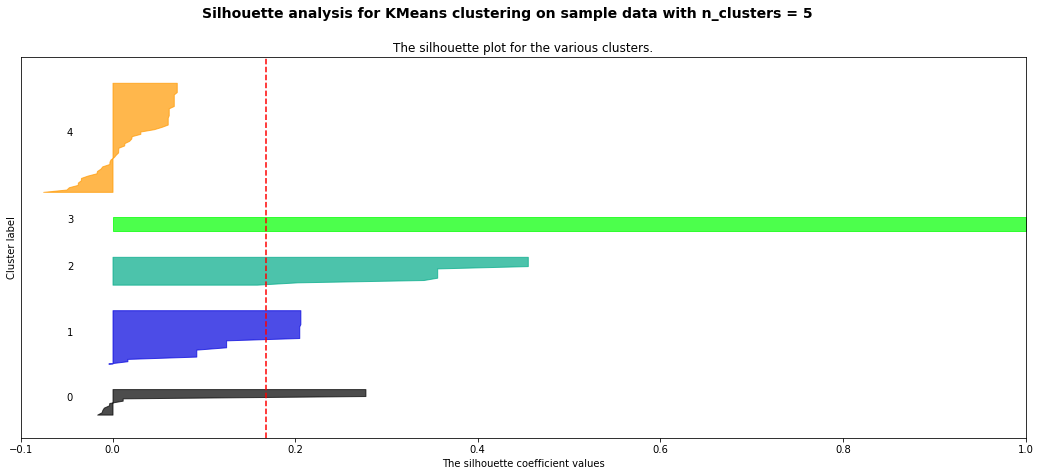

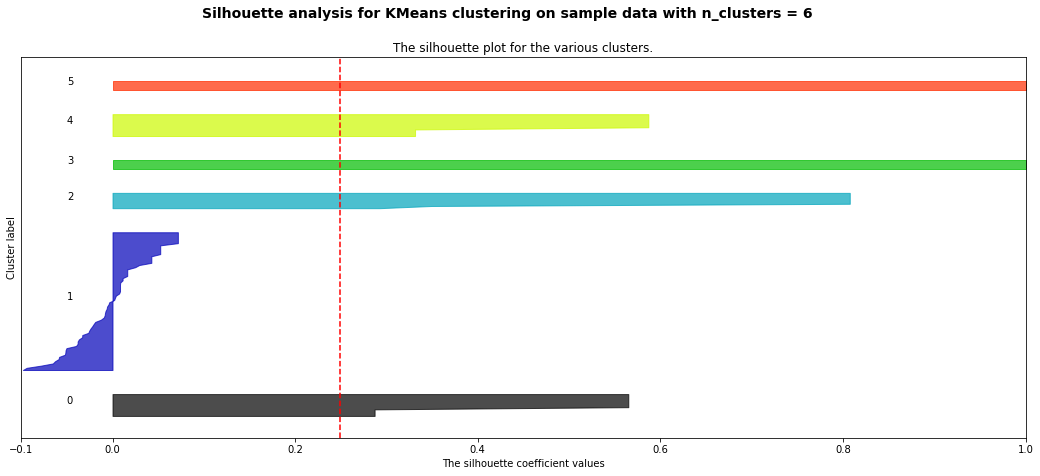

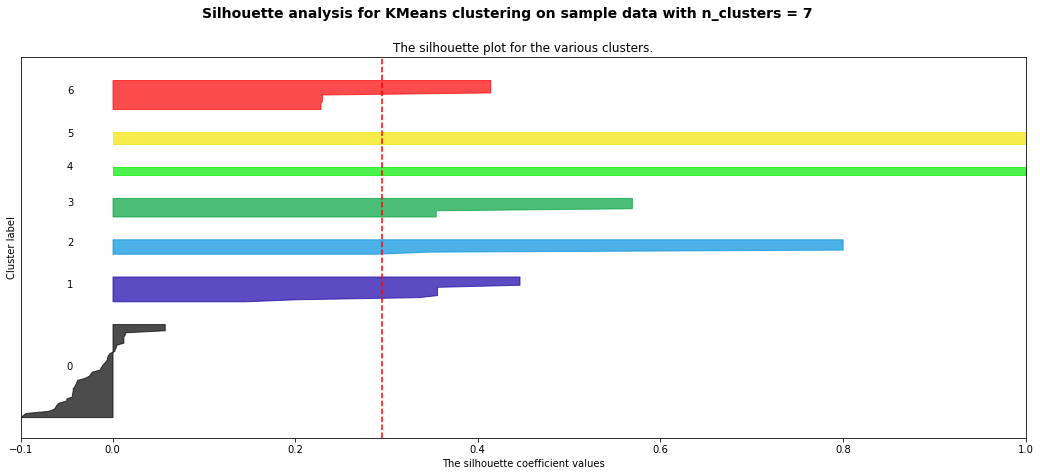

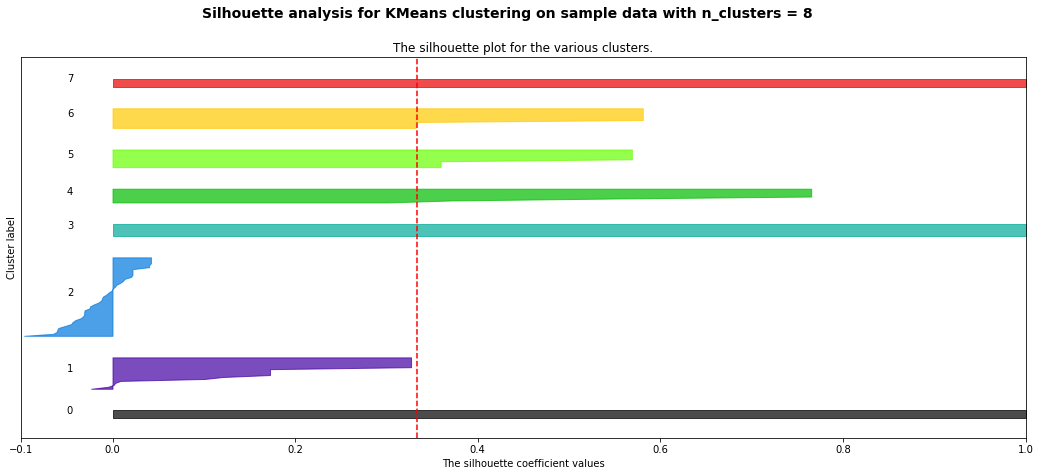

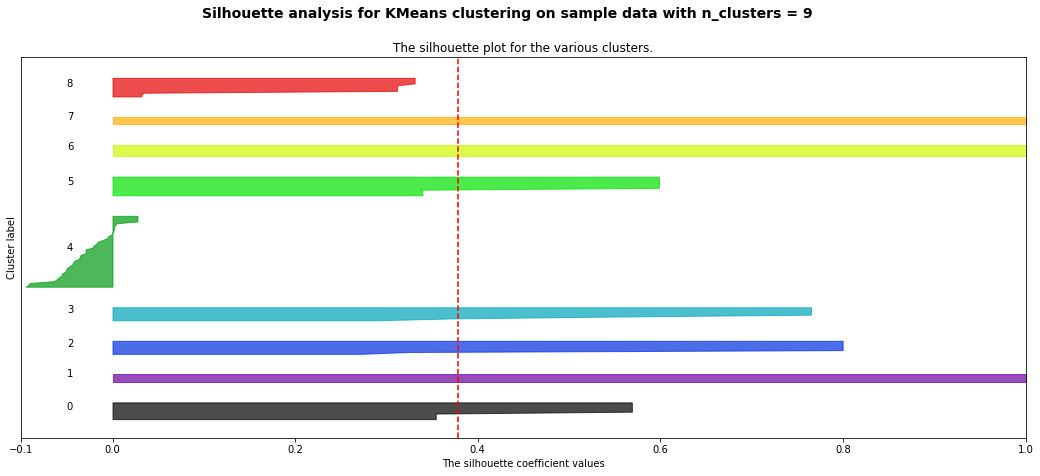

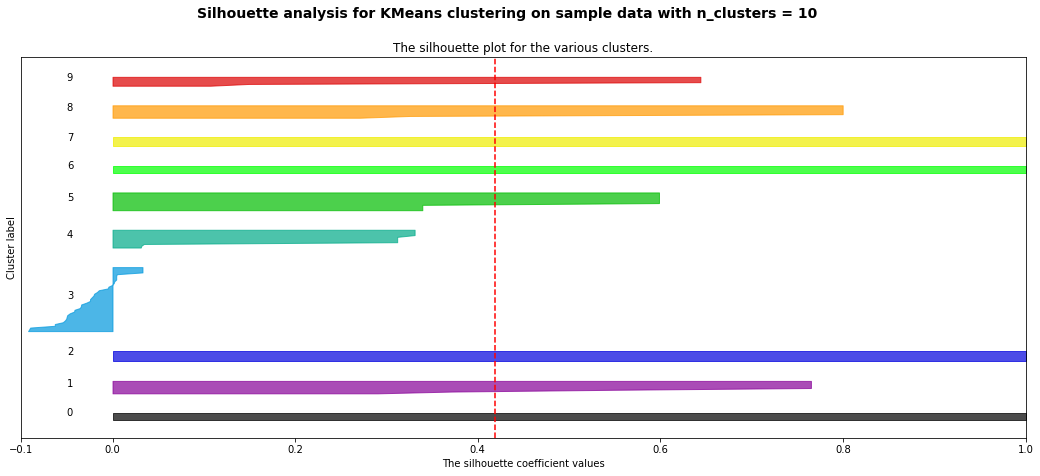

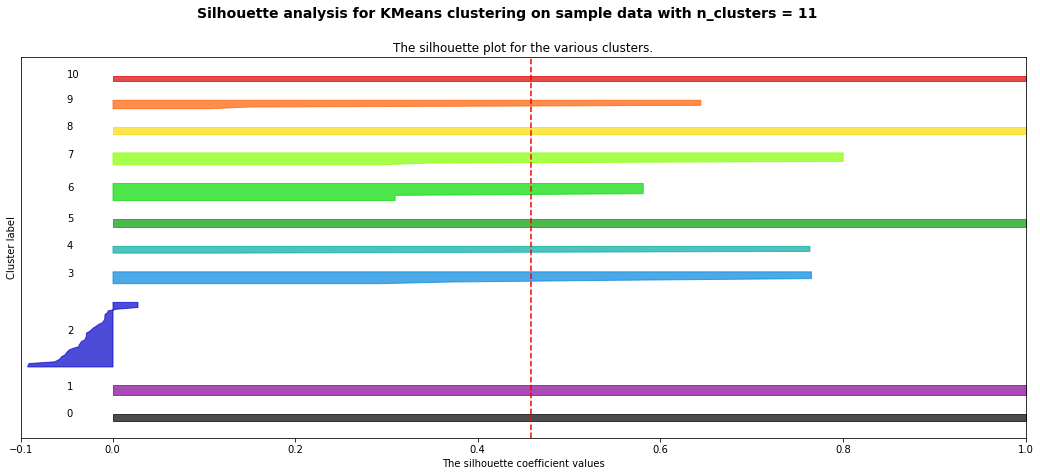

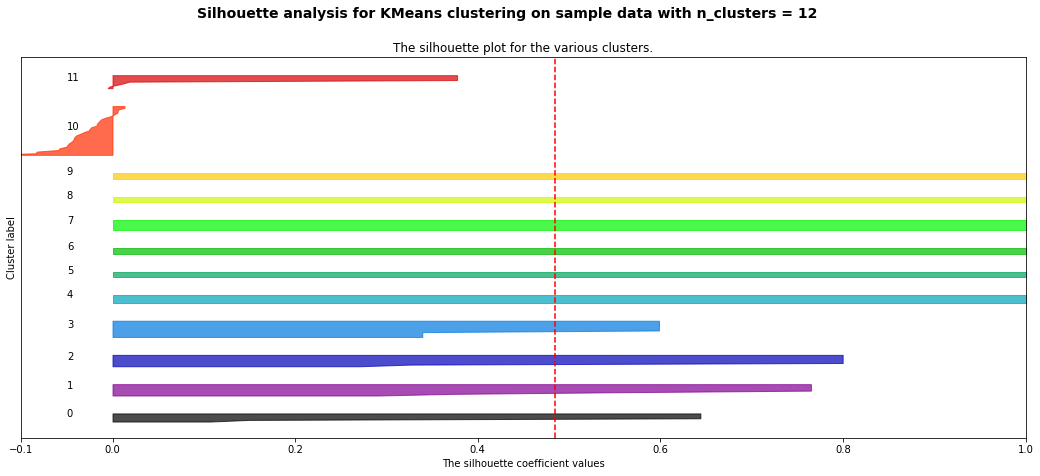

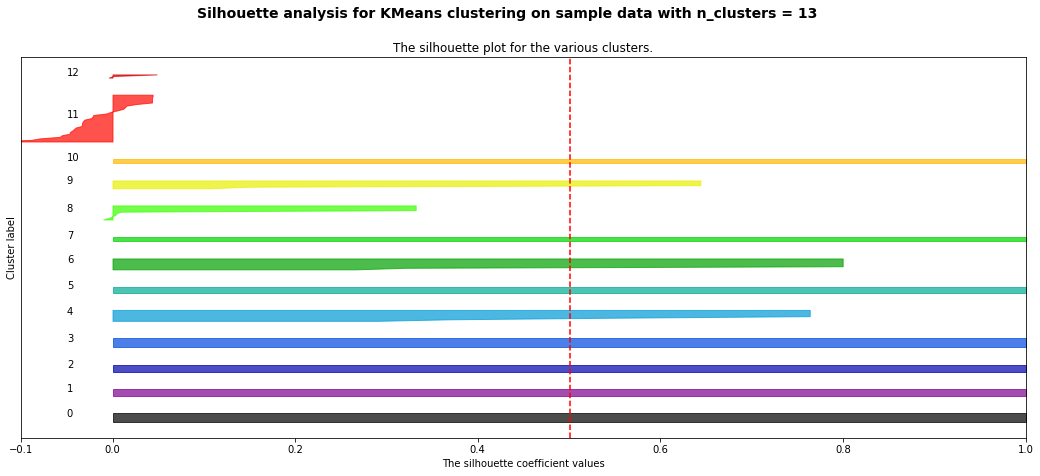

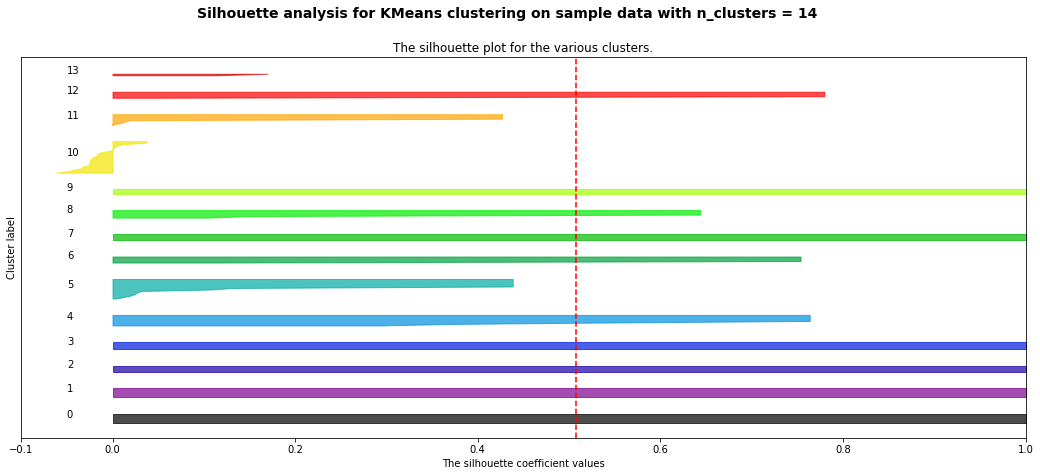

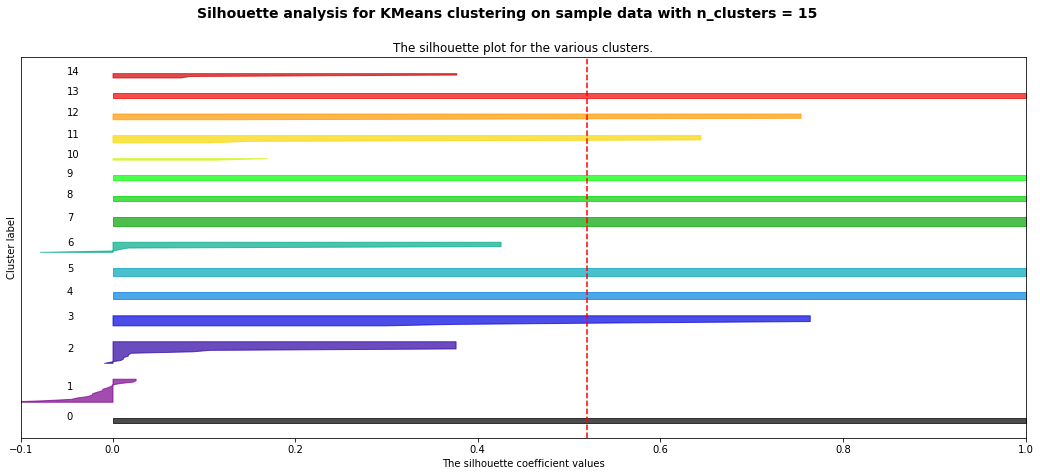

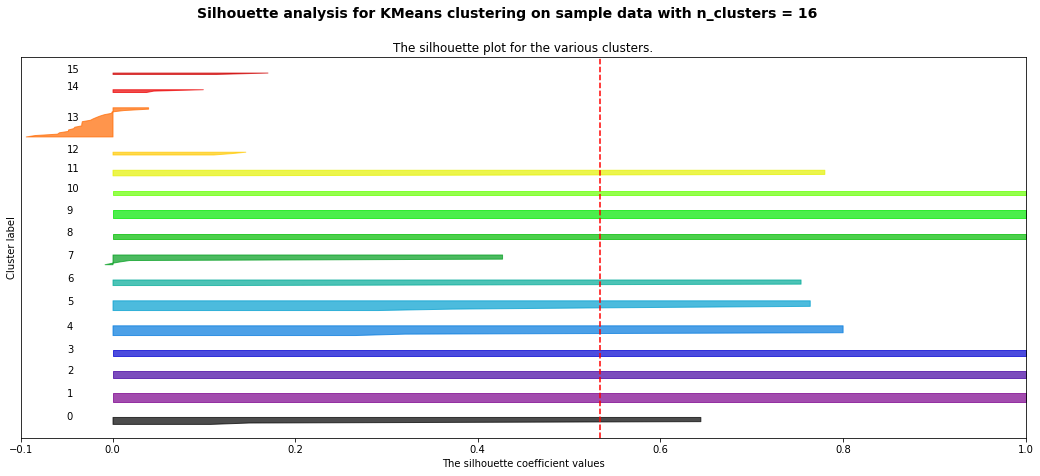

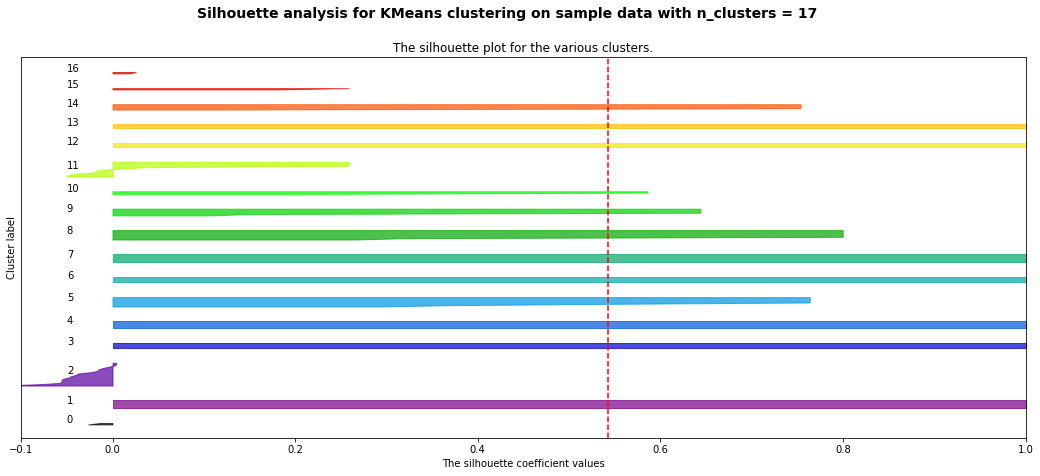

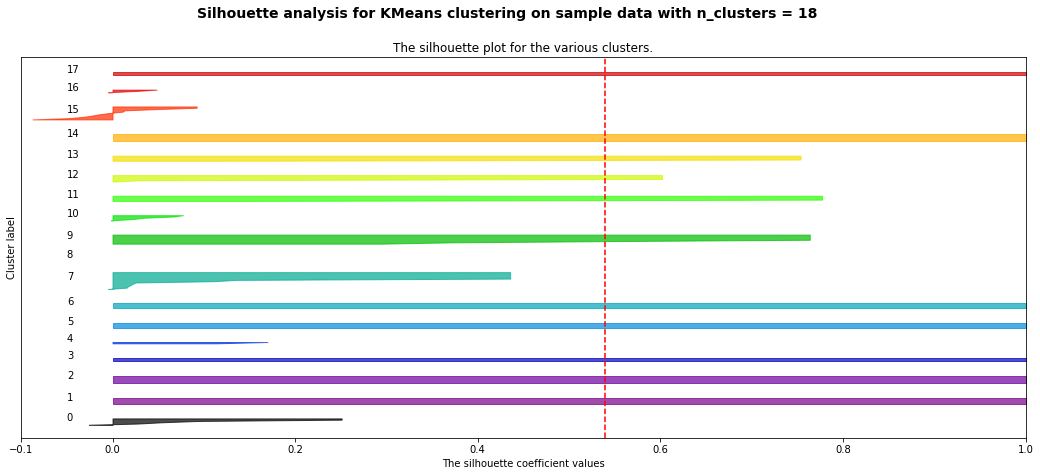

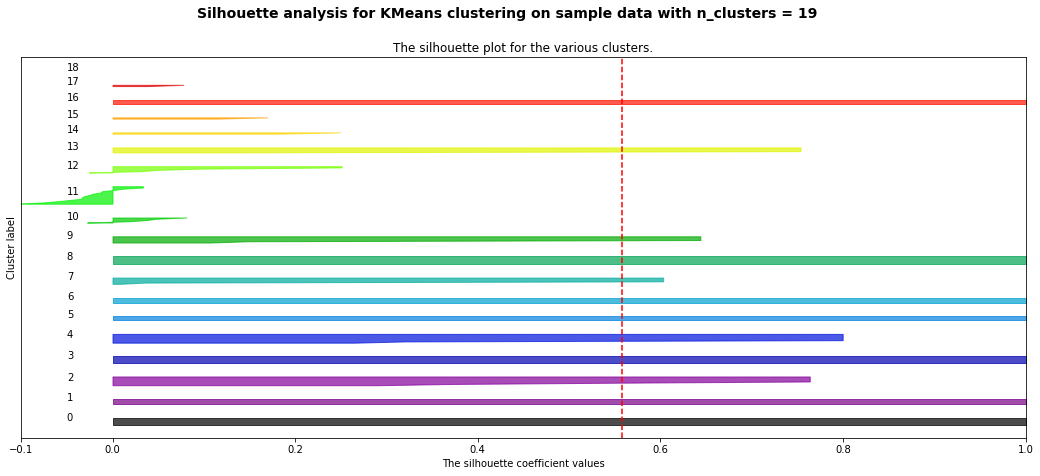

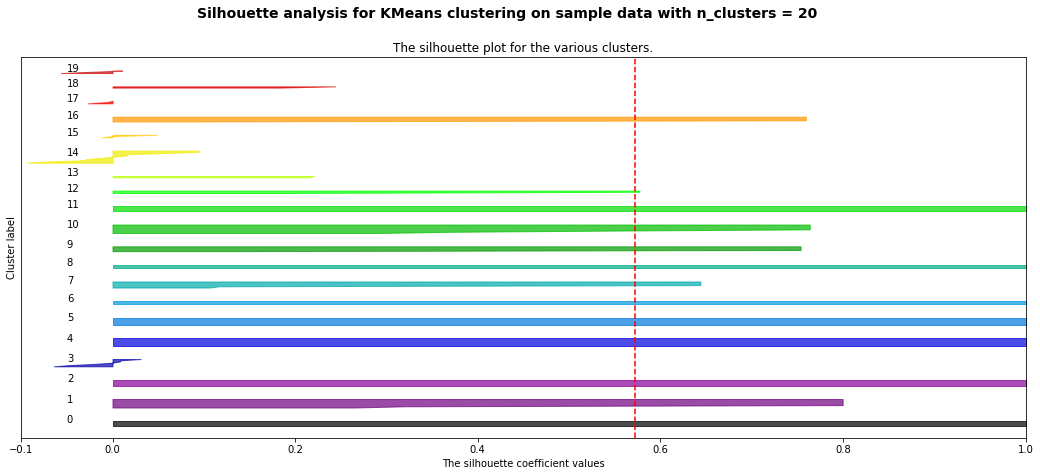

In [63]:
# Evaluate the different models using the Silhoutte Score

silhoutte_score_validation(model = KMeans, transformer = TfidfVectorizer(lowercase = False), array = X)

###### In order to prevent a mislabel of the data, it is necessary to pick up a number of clusters that seems to high for this particular problem. Therefore, I'd stay with 4 clusters to compare silhoutte scores. However, this model won't be in consideration because of that. 

In [64]:
# Creation of the pipeline

pipe_preprocessing = pipeline(est1 = TfidfVectorizer(lowercase = False))

pipe_predictor = pipeline2(est2 = KMeans(n_clusters = 4))

pipe_kmeans_tf = pipeline3(pipeline = pipe_preprocessing, pipeline2 = pipe_predictor)

# Fit the final pipeline

pipe_kmeans_tf.fit(X)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('est1', TfidfVectorizer(lowercase=False)),
                                 ('pca', TruncatedSVD())])),
                ('predictor',
                 Pipeline(steps=[('est2', KMeans(n_clusters=4))]))])

In [65]:
# Transform the data for the preprocessor

preprocessed_data = pipe_kmeans_tf['preprocessor'].transform(X)

# Labels Predictions

predicted_labels = pipe_kmeans_tf['predictor']['est2'].labels_

# Identify the centroids

clusters = pipe_kmeans_tf['predictor']['est2'].cluster_centers_

In [66]:
# Get the coordenates for the keyword ("Aspiring Human Resources")

keywords_preprocessed = pipe_kmeans_tf['preprocessor'].transform([string_keyword])

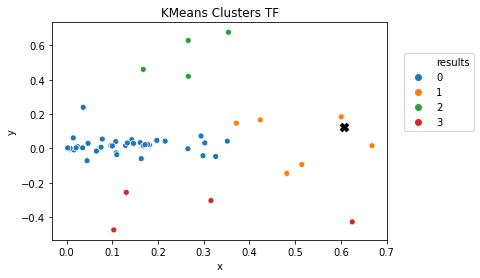

In [67]:
# Save the results in a data frame

results = results_df(preprocessing = preprocessed_data, predictions = predicted_labels)

# Plot the scatter plot with the centroids

plot_scatter(df = results, keyword = keywords_preprocessed, title = 'KMeans Clusters TF')

In [68]:
# Apply the function that calculates the Levenshtain distance

results_k_mean_levenshtein_tf = levenshtein_distance(df = results, string =  string_keyword)

In [69]:
# See the fit of each person based on the euclidean distance

results_kmean_tf = euclidean_distance(df = results_k_mean_levenshtein_tf, keyword = keywords_preprocessed)

In [70]:
# Results based on the euclidean distance

results_kmean_tf.head(20)

,x,y,results,id,job_title,levenshtein_distance,levenshtein_distance_fit,euclidean_distance,euclidean_fit
0,0.600849,0.183763,1,58,aspiring human resources professional raleighd...,0.636364,0.529213,0.056468,0.945097
1,0.600849,0.183763,1,3,aspiring human resources professional raleighd...,0.636364,0.529213,0.056468,0.945097
2,0.600849,0.183763,1,21,aspiring human resources professional raleighd...,0.636364,0.529213,0.056468,0.945097
3,0.600849,0.183763,1,33,aspiring human resources professional raleighd...,0.636364,0.529213,0.056468,0.945097
4,0.600849,0.183763,1,17,aspiring human resources professional raleighd...,0.636364,0.529213,0.056468,0.945097
5,0.600849,0.183763,1,46,aspiring human resources professional raleighd...,0.636364,0.529213,0.056468,0.945097
6,0.668270,0.016688,1,9,student humber college aspiring human resource...,0.630769,0.532182,0.126738,0.880964
7,0.668270,0.016688,1,52,student humber college aspiring human resource...,0.630769,0.532182,0.126738,0.880964
8,0.668270,0.016688,1,37,student humber college aspiring human resource...,0.630769,0.532182,0.126738,0.880964
9,0.668270,0.016688,1,25,student humber college aspiring human resource...,0.630769,0.532182,0.126738,0.880964


In [71]:
results_kmean_tf = final_fit(df = results_kmean_tf)

results_kmean_tf[['id', 'job_title', 'final_fit_model']].head(number_candidates)

,id,job_title,final_fit_model
0,58,aspiring human resources professional raleighd...,0.737155
1,21,aspiring human resources professional raleighd...,0.737155
2,33,aspiring human resources professional raleighd...,0.737155
3,17,aspiring human resources professional raleighd...,0.737155
4,46,aspiring human resources professional raleighd...,0.737155
5,3,aspiring human resources professional raleighd...,0.737155
6,39,student humber college aspiring human resource...,0.706573


In [72]:
# Calculation of the Calinski Harabasz Score

metric_score(array1 = preprocessed_data, array2 = predicted_labels)

The Calinski Harabasz Score is 117.74760045775913
The Davies Bouldin score is 0.6610306006626095


### Gaussian Mixture

#### Vectorization

For n_clusters = 2 The average silhouette_score is : 0.15724526848187872
For n_clusters = 3 The average silhouette_score is : 0.10233527163924347
For n_clusters = 4 The average silhouette_score is : 0.1503497310805445
For n_clusters = 5 The average silhouette_score is : 0.19224945457295842
For n_clusters = 6 The average silhouette_score is : 0.23549730891755072
For n_clusters = 7 The average silhouette_score is : 0.2572377761370132
For n_clusters = 8 The average silhouette_score is : 0.2639866409617491
For n_clusters = 9 The average silhouette_score is : 0.38915461891784325
For n_clusters = 10 The average silhouette_score is : 0.3733593252704794
For n_clusters = 11 The average silhouette_score is : 0.3896651508489433
For n_clusters = 12 The average silhouette_score is : 0.408827420086106
For n_clusters = 13 The average silhouette_score is : 0.4290425243859104
For n_clusters = 14 The average silhouette_score is : 0.5136143412100429
For n_clusters = 15 The average silhouette_score is : 0

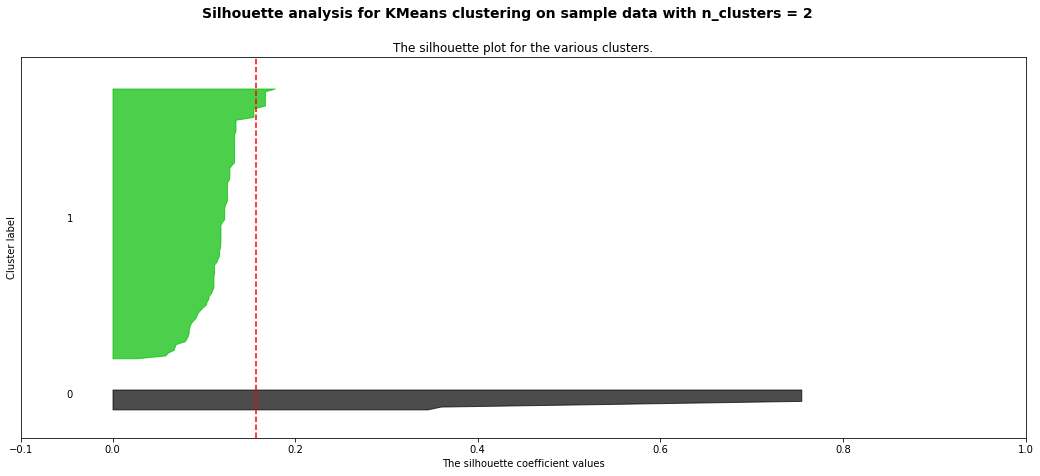

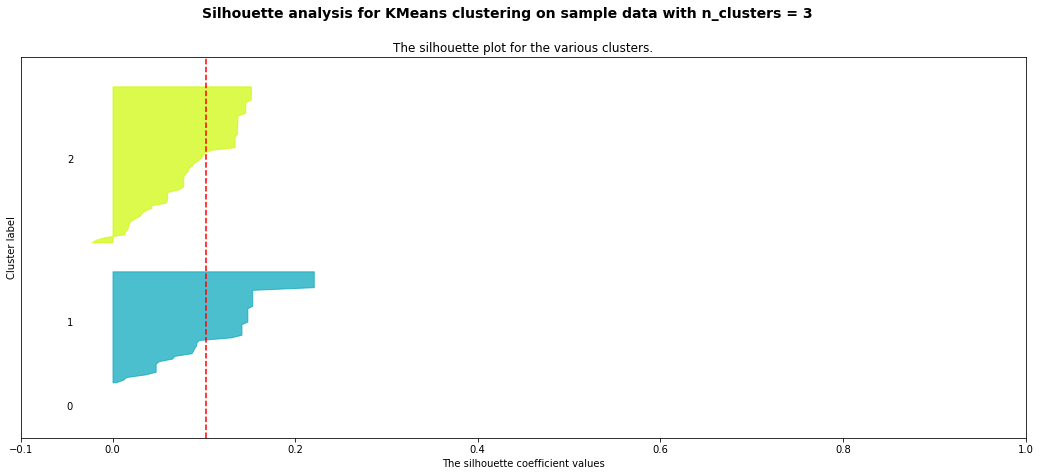

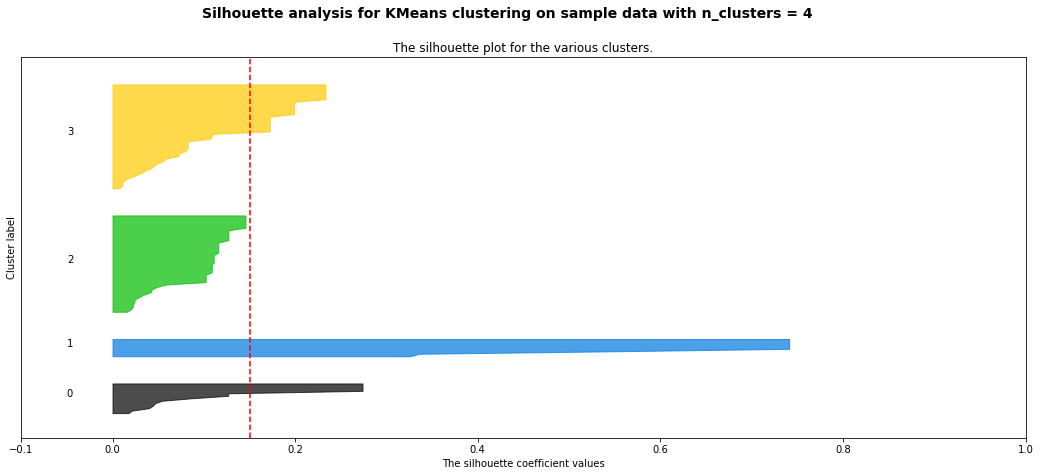

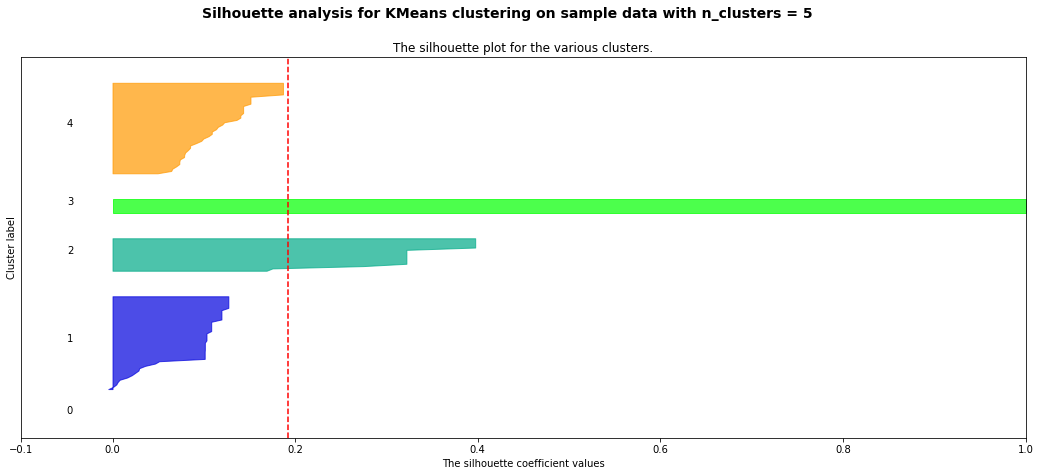

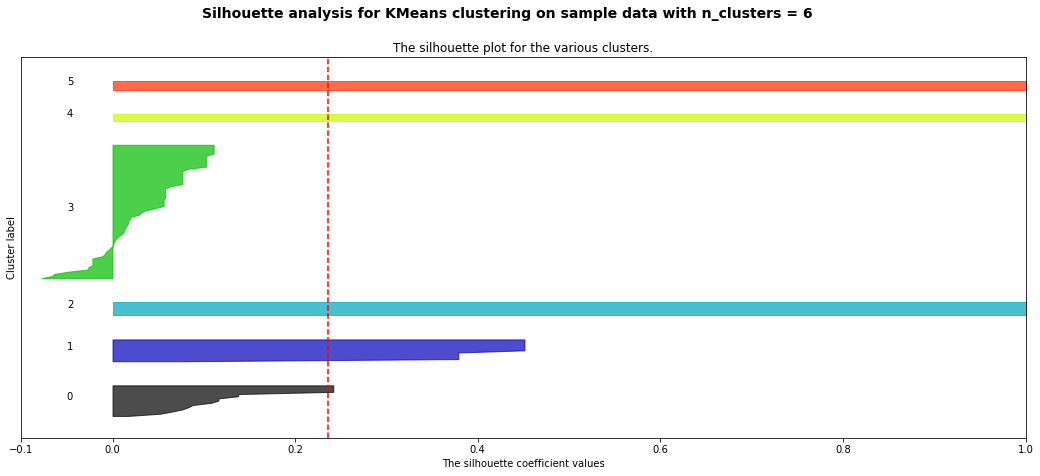

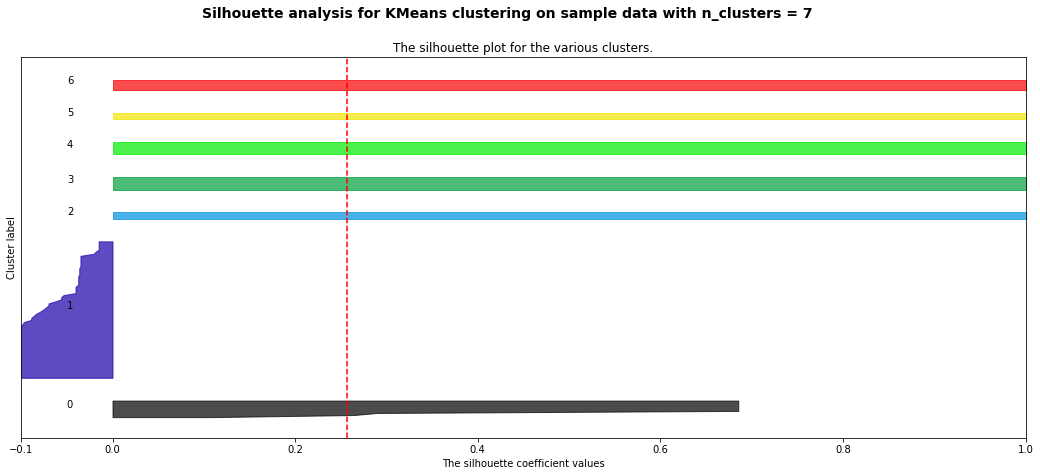

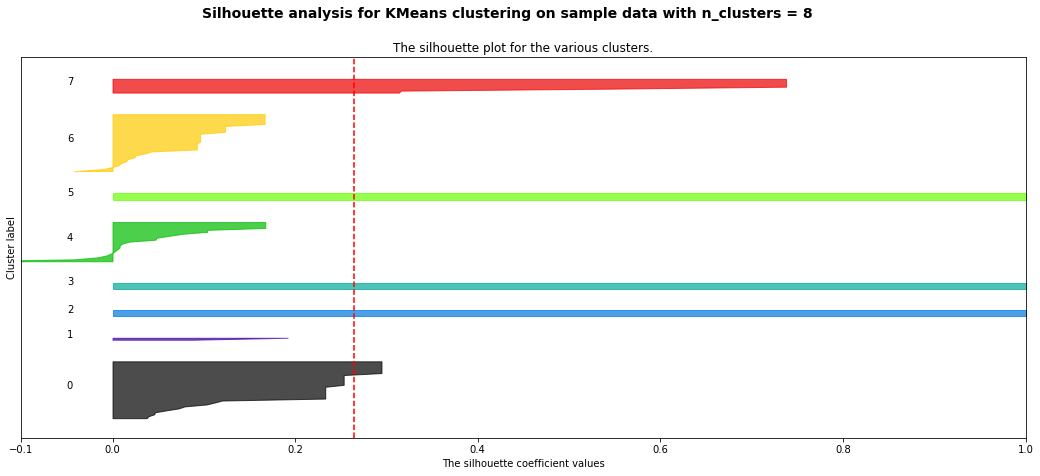

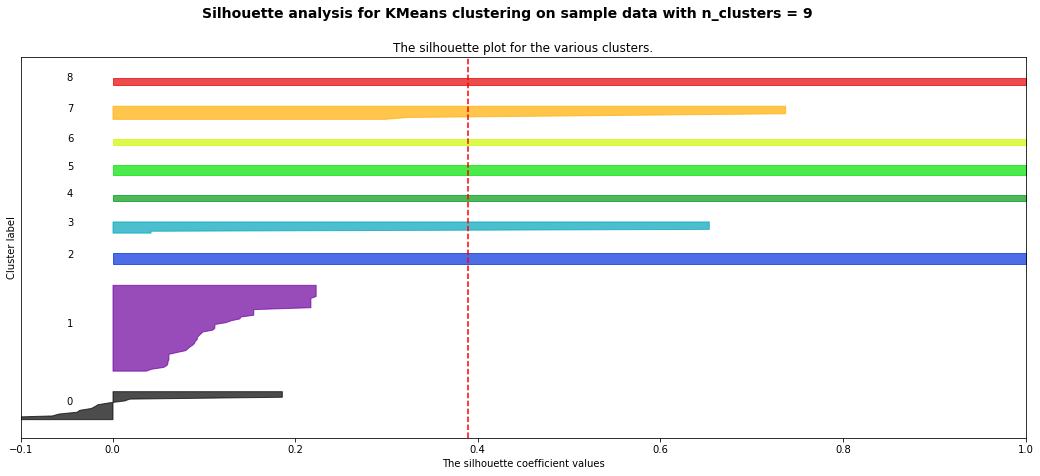

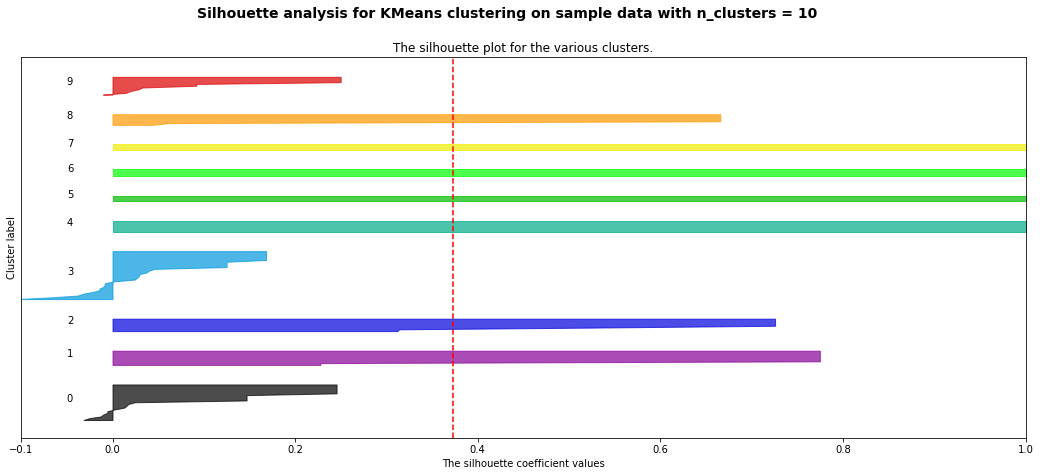

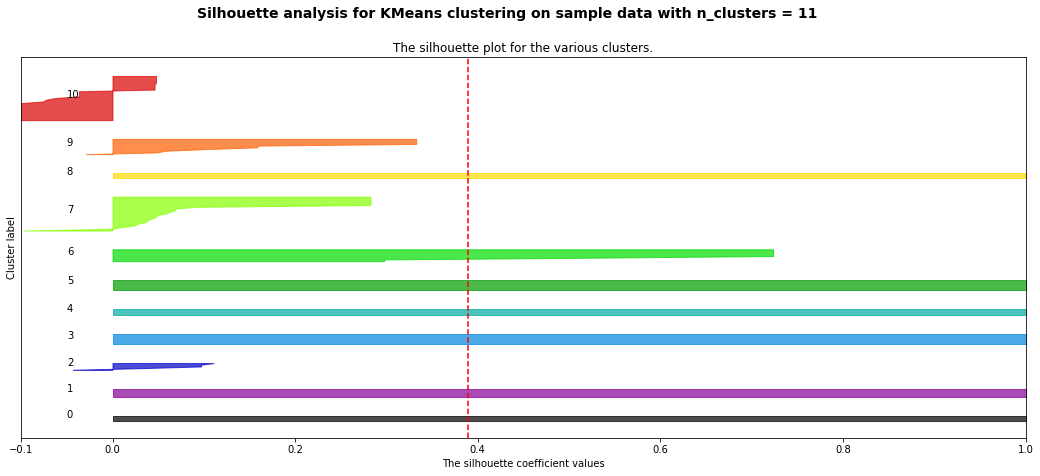

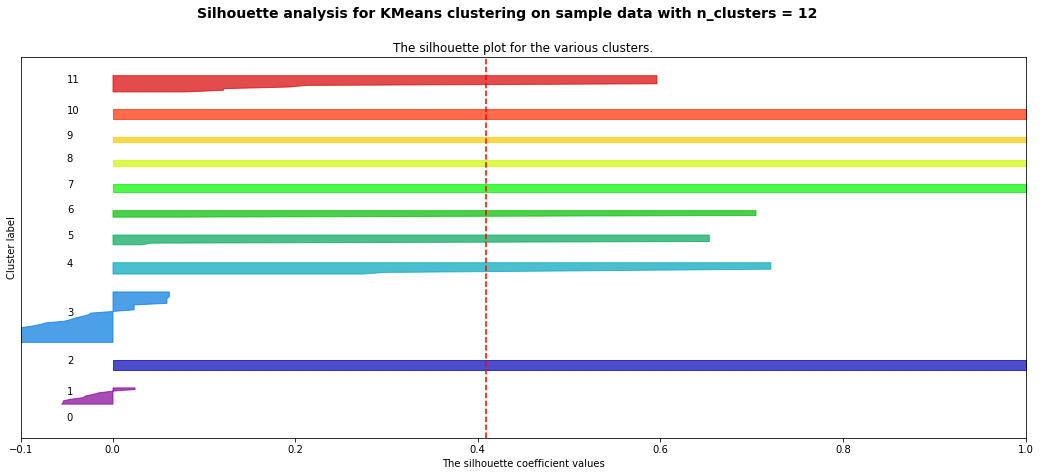

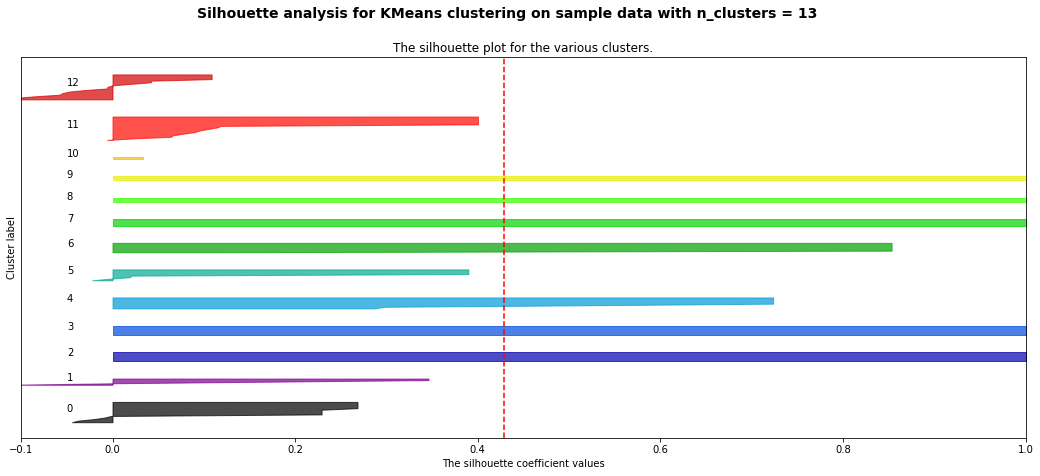

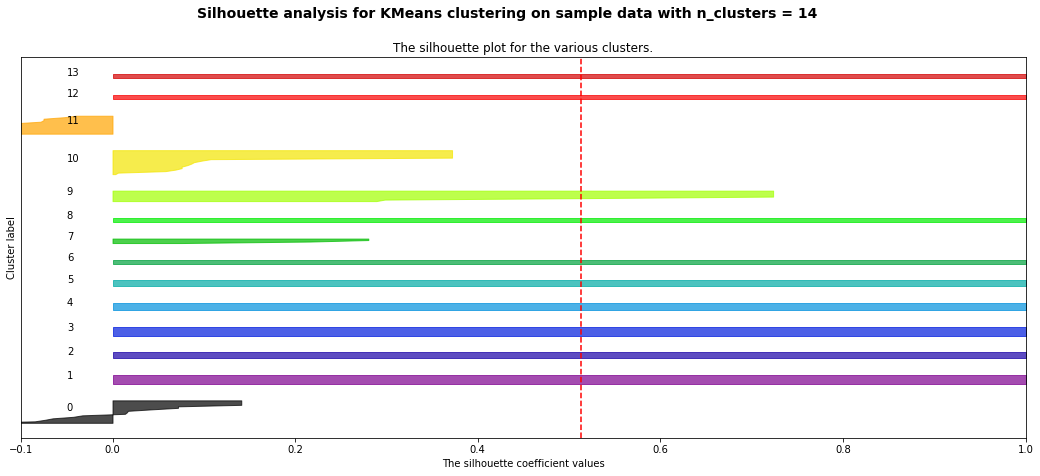

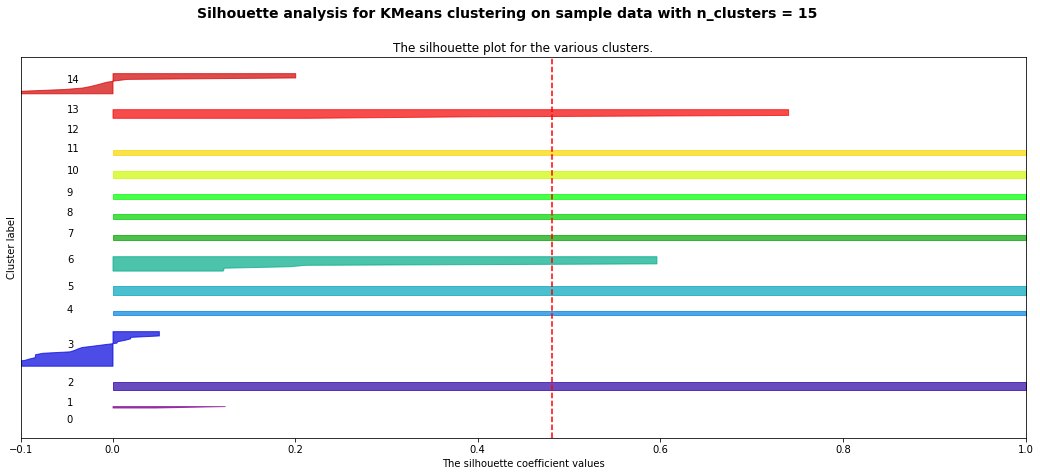

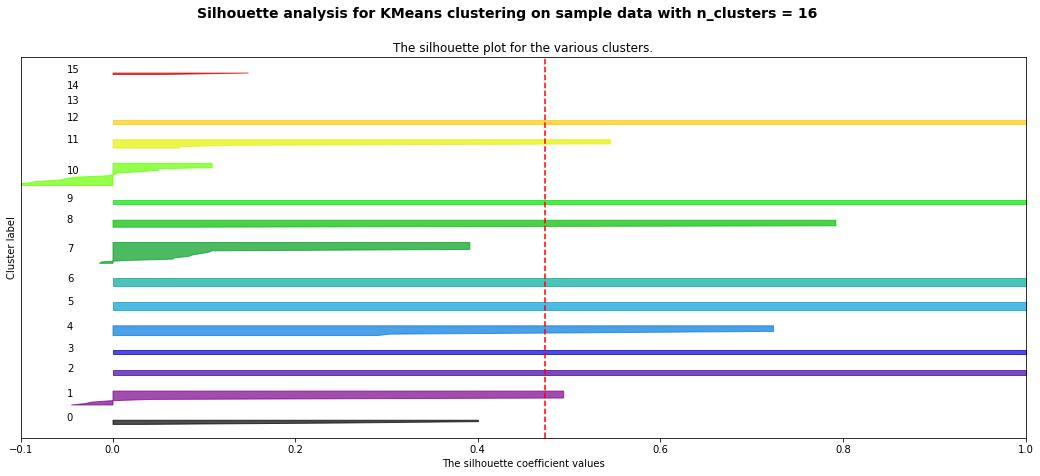

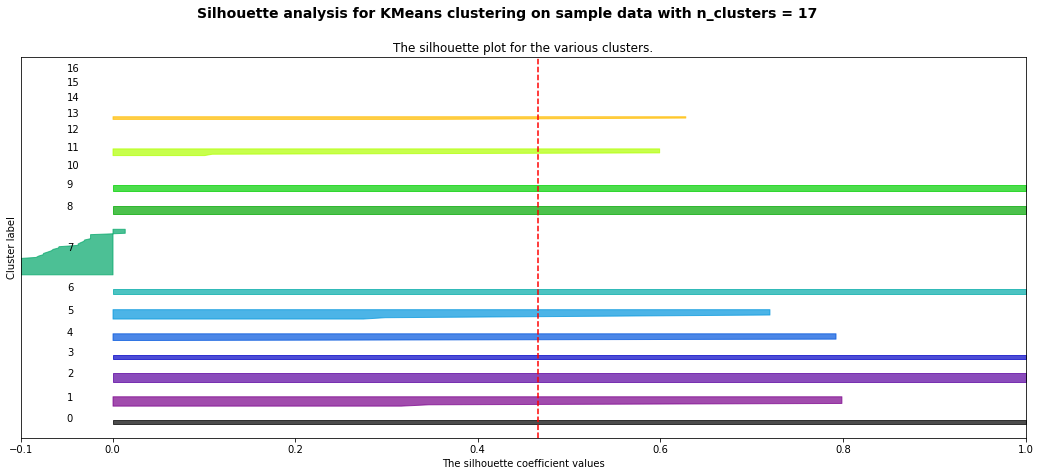

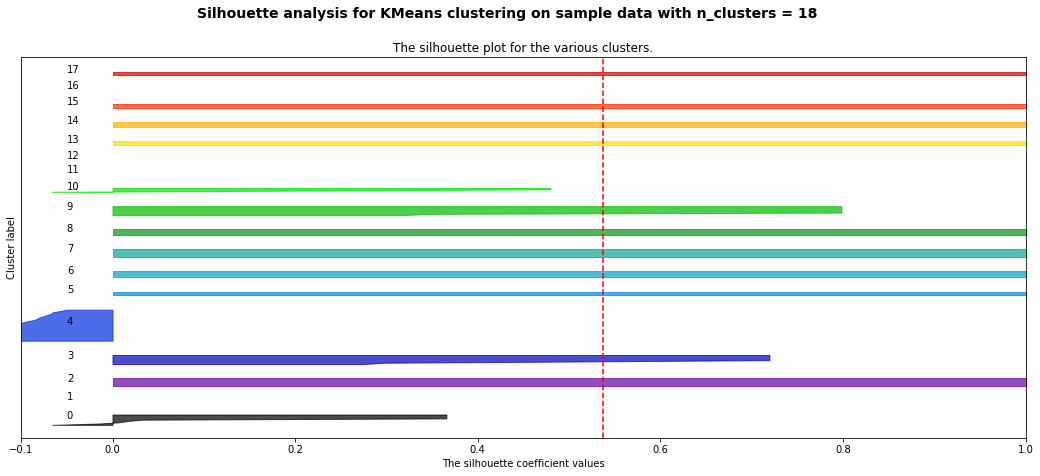

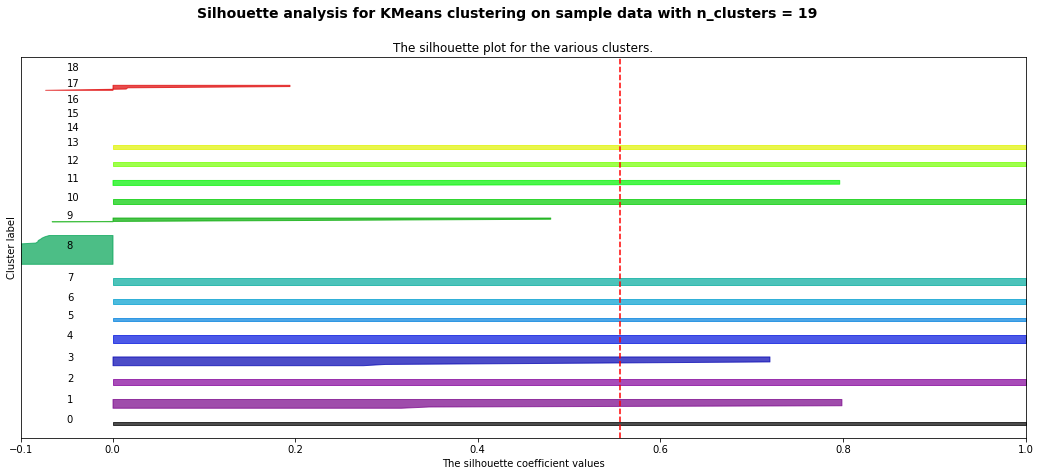

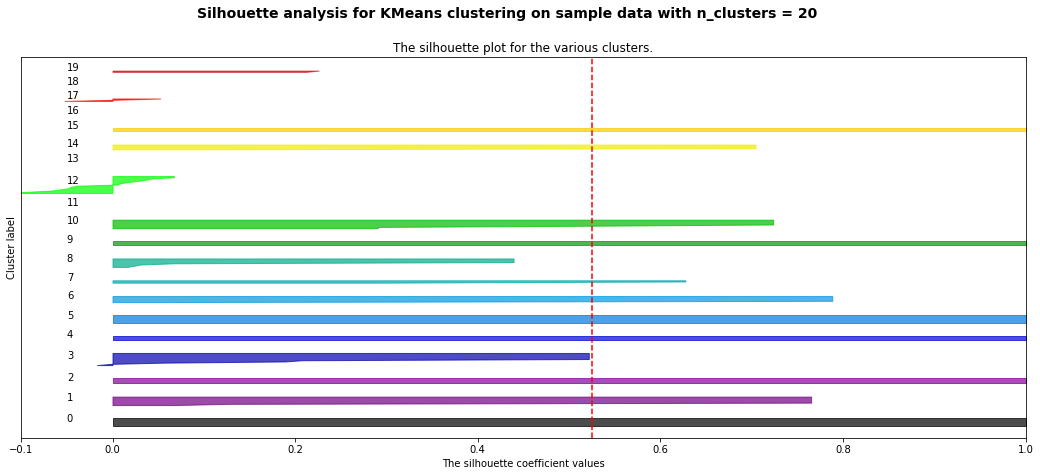

In [73]:
# Evaluate the different models using the Silhoutte Score

silhoutte_score_validation(model = GaussianMixture, transformer = CountVectorizer(lowercase = False), array = X)

###### The best number of components after several repetitions would be between 3 or 2. I'd select 3 to better compare the other metric scores. However 2 sows a model that may prevent the mislabel of the data. This model would be in consideration for final selection, but not as strong as the KMeans models with Count Vectorization.

In [74]:
# Creation of the pipeline for Gaussian Mixture

pipe_preprocessing = pipeline(est1 = CountVectorizer(lowercase = False))

pipe_predictor = pipeline2(est2 = GaussianMixture(n_components = 3))

pipe_gaussian_cv = pipeline3(pipeline = pipe_preprocessing, pipeline2 = pipe_predictor)

# Fit the final pipeline

pipe_gaussian_cv.fit(X)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('est1', CountVectorizer(lowercase=False)),
                                 ('pca', TruncatedSVD())])),
                ('predictor',
                 Pipeline(steps=[('est2', GaussianMixture(n_components=3))]))])

In [75]:
# Transform the data for the preprocessor

preprocessed_data = pipe_gaussian_cv['preprocessor'].transform(X)

# Labels Predictions

predicted_labels = pipe_gaussian_cv.predict(X)

In [76]:
# Get the coordenates for the keyword ("Aspiring Human Resources")

keywords_preprocessed = pipe_gaussian_cv['preprocessor'].transform([string_keyword])

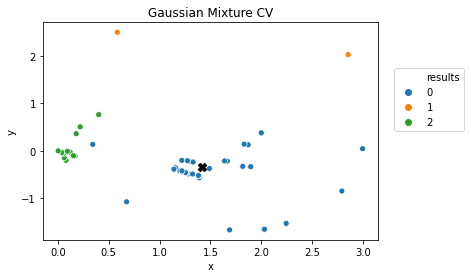

In [77]:
# Save the results in a data frame

results = results_df(preprocessing = preprocessed_data, predictions = predicted_labels)

# Plot the scatter plot with the centroids

plot_scatter(df = results, keyword = keywords_preprocessed, title = 'Gaussian Mixture CV')

In [78]:
# Apply the function that calculates the Levenshtain distance

results_gaussian_levenshtein_cv = levenshtein_distance(df = results, string =  string_keyword)

In [79]:
# See the fit of each person based on the euclidean distance

results_gaussian_cv = euclidean_distance(df = results_gaussian_levenshtein_cv, keyword = keywords_preprocessed)

In [80]:
# Results based on the euclidean distance

results_gaussian_cv.head(20)

,x,y,results,id,job_title,levenshtein_distance,levenshtein_distance_fit,euclidean_distance,euclidean_fit
0,1.490815,-0.374915,0,79,liberal arts major aspiring human resources an...,0.671233,0.511078,0.080776,0.922400
1,1.330002,-0.238014,0,84,human resources professional world leader gis ...,0.837838,0.432645,0.132512,0.875892
2,1.299061,-0.224733,0,67,human resources staffing recruiting profession...,0.764706,0.465471,0.163952,0.848782
3,1.324180,-0.491403,0,70,retired army national guard recruiter office m...,0.798165,0.450154,0.184414,0.831591
4,1.382645,-0.521791,0,101,human resources generalist loparex raleighdurh...,0.809524,0.445070,0.191256,0.825921
5,1.274798,-0.211010,0,74,human resources professional boston,0.800000,0.449329,0.191262,0.825916
6,1.389180,-0.528136,0,71,human resources generalist scottmadden inc ral...,0.802817,0.448065,0.196314,0.821754
7,1.254872,-0.460572,0,94,seeking human resources opportunities open tra...,0.768293,0.463804,0.208550,0.811761
8,1.279335,-0.487941,0,56,human resources coordinator intercontinental b...,0.844156,0.429920,0.208860,0.811509
9,1.279335,-0.487941,0,43,human resources coordinator intercontinental b...,0.844156,0.429920,0.208860,0.811509


In [81]:
results_gaussian_cv = final_fit(df = results_gaussian_cv)

results_gaussian_cv[['id', 'job_title', 'final_fit_model']].head(number_candidates)

,id,job_title,final_fit_model
0,79,liberal arts major aspiring human resources an...,0.716739
1,97,aspiring human resources professional kokomo i...,0.681539
2,99,seeking human resources position las vegas nevada,0.672211
3,89,director human resources ey atlanta,0.666419
4,28,seeking human resources opportunities chicago ...,0.662032
5,30,seeking human resources opportunities chicago ...,0.662032
6,67,human resources staffing recruiting profession...,0.657127


In [82]:
# Calculation of the Calinski Harabasz Score

metric_score(array1 = preprocessed_data, array2 = predicted_labels)

The Calinski Harabasz Score is 156.14674594574745
The Davies Bouldin score is 0.5533740233875998


#### TF-IDF

For n_clusters = 2 The average silhouette_score is : 0.06316887066055622
For n_clusters = 3 The average silhouette_score is : 0.08720549628174122
For n_clusters = 4 The average silhouette_score is : 0.13803665294860665
For n_clusters = 5 The average silhouette_score is : 0.16358755534505337
For n_clusters = 6 The average silhouette_score is : 0.19049534128785692
For n_clusters = 7 The average silhouette_score is : 0.21109410756073668
For n_clusters = 8 The average silhouette_score is : 0.2717018638751789
For n_clusters = 9 The average silhouette_score is : 0.38232887941107896
For n_clusters = 10 The average silhouette_score is : 0.3251517140217958
For n_clusters = 11 The average silhouette_score is : 0.38152113721969044
For n_clusters = 12 The average silhouette_score is : 0.38461750239013265
For n_clusters = 13 The average silhouette_score is : 0.48016010396026443
For n_clusters = 14 The average silhouette_score is : 0.4352787119995533
For n_clusters = 15 The average silhouette_score 

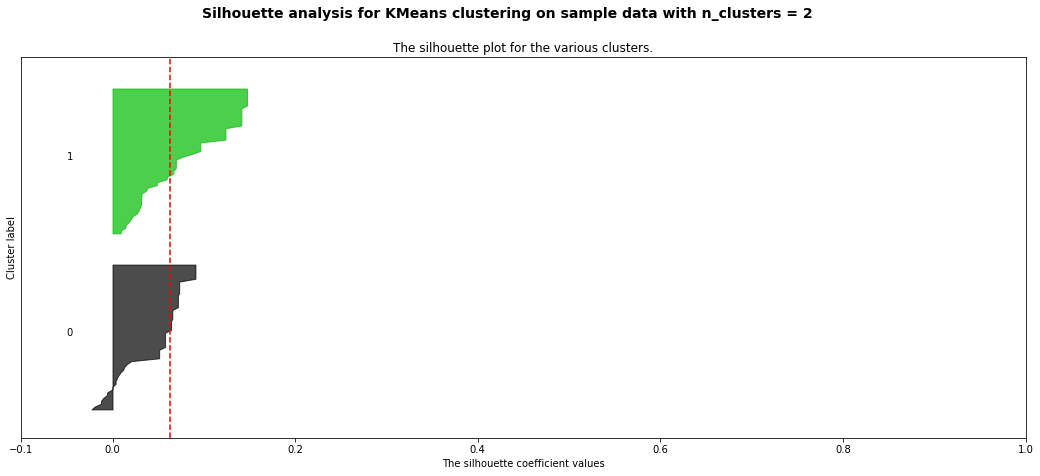

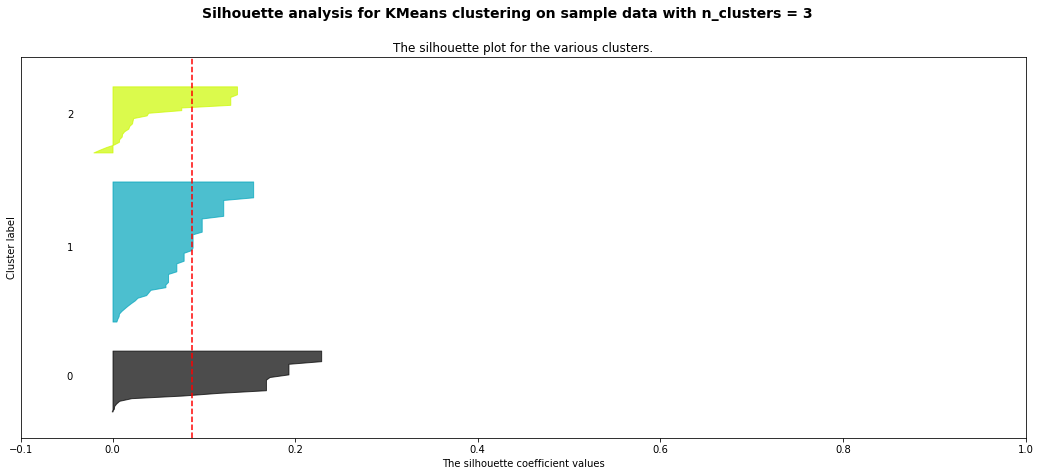

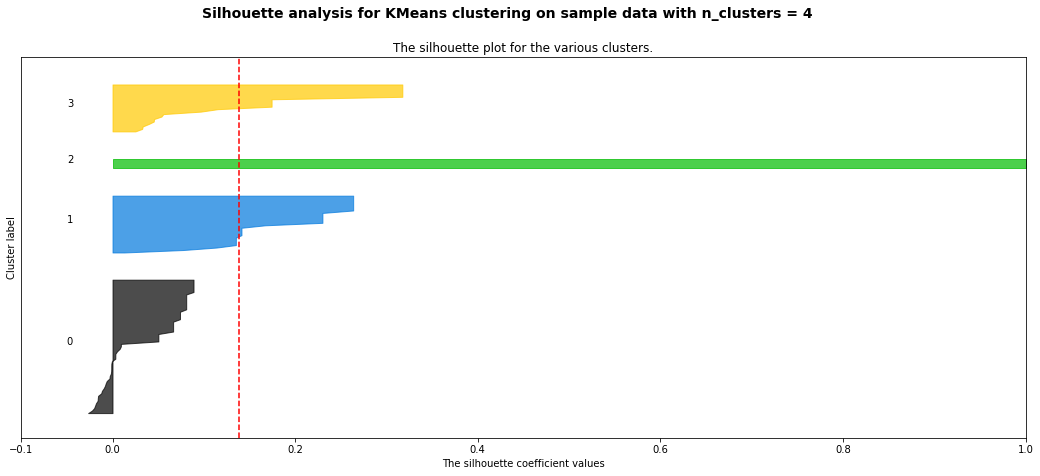

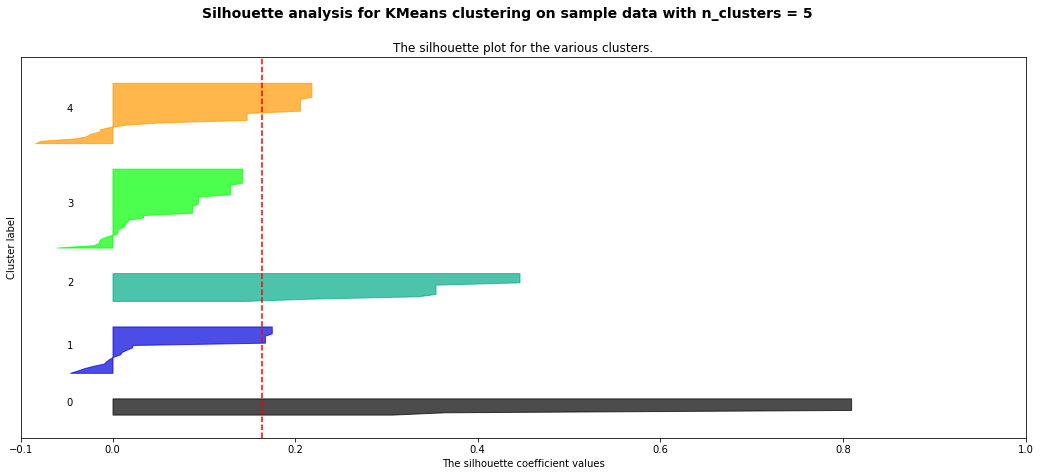

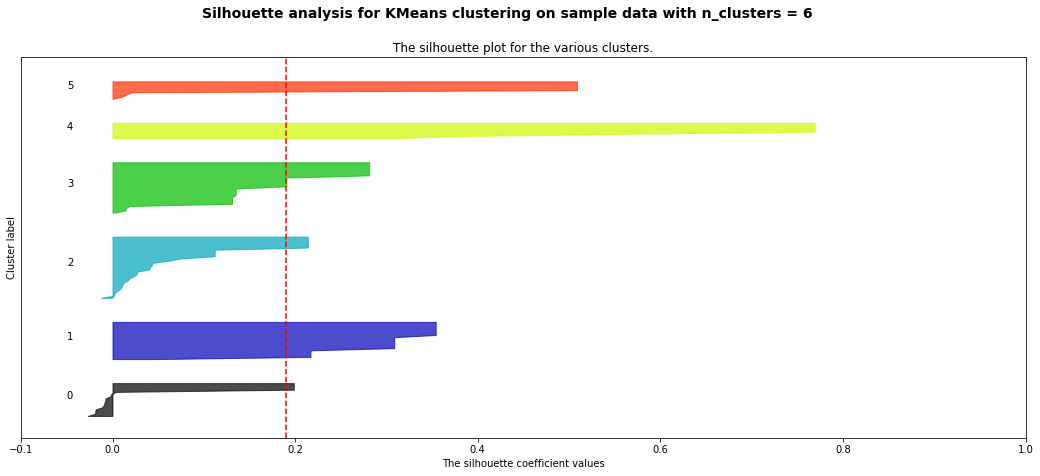

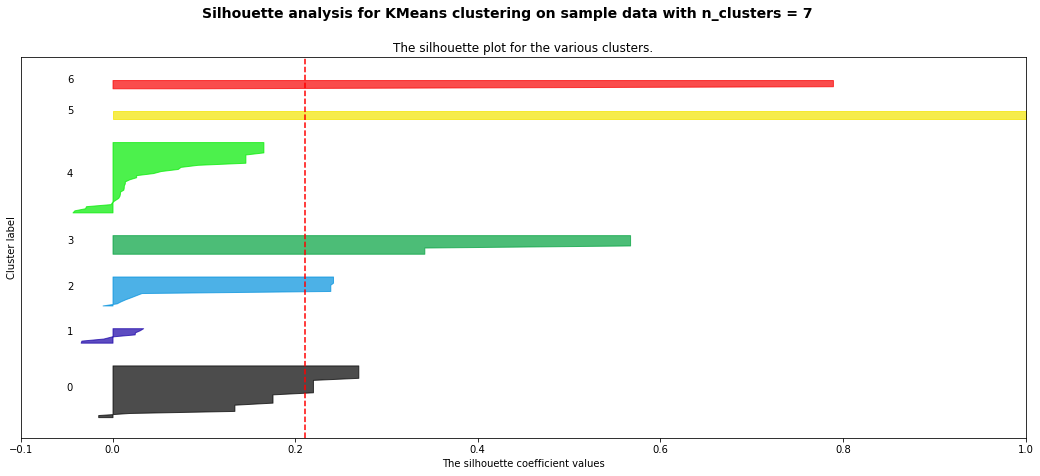

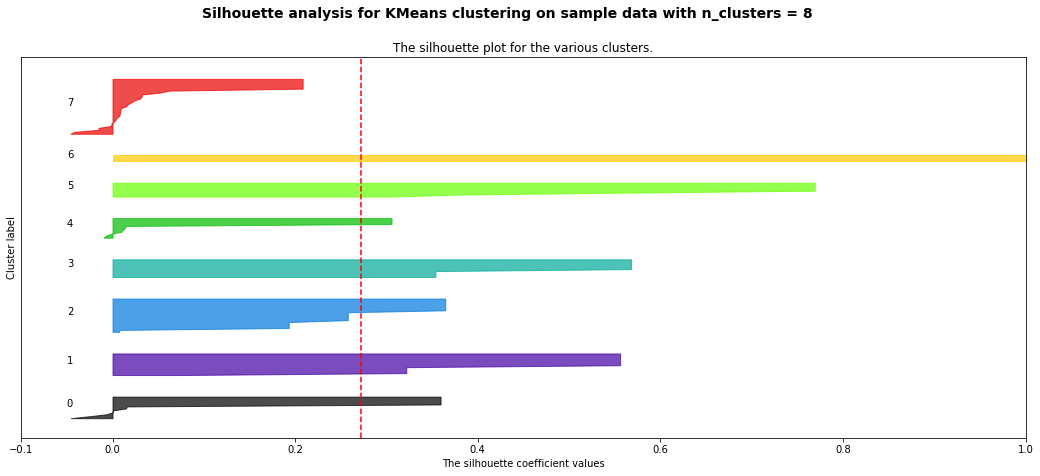

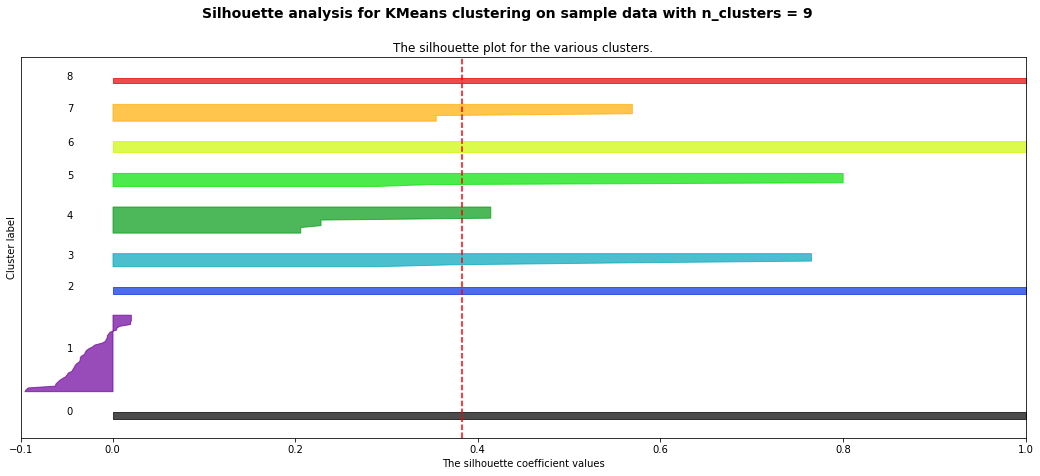

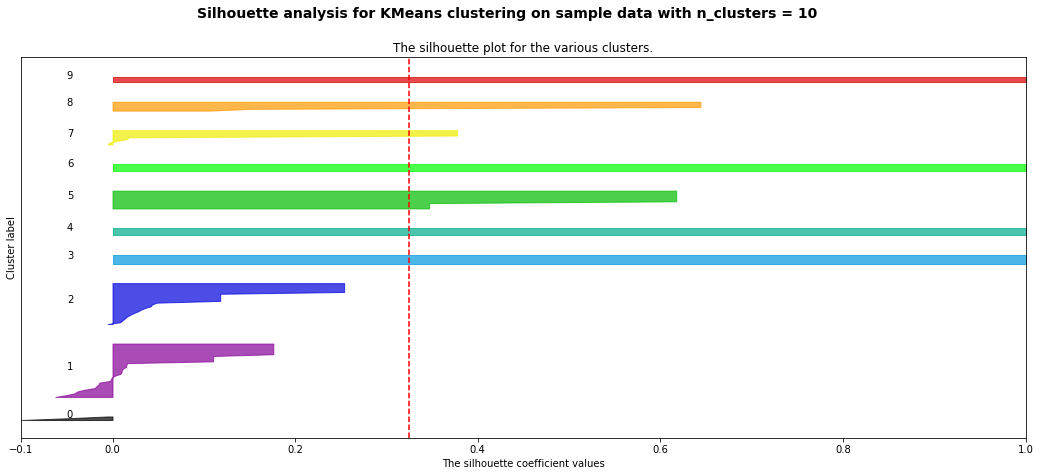

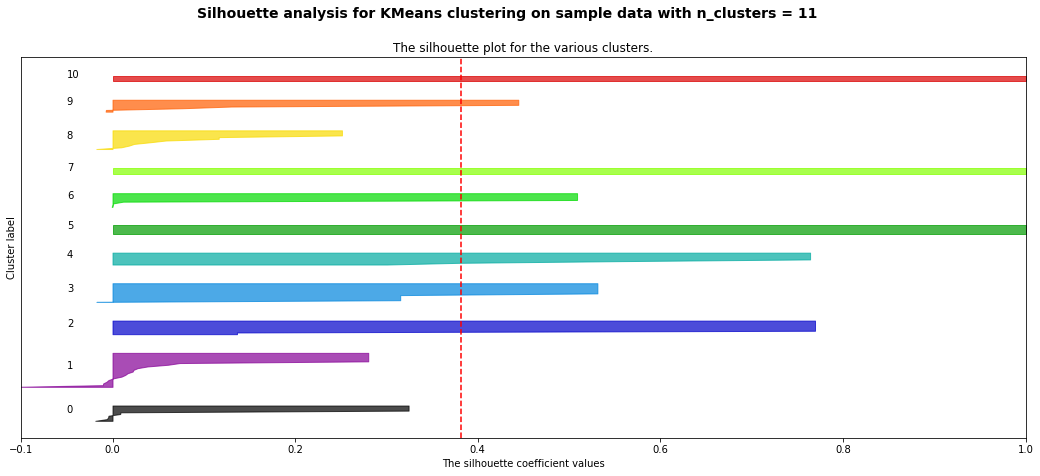

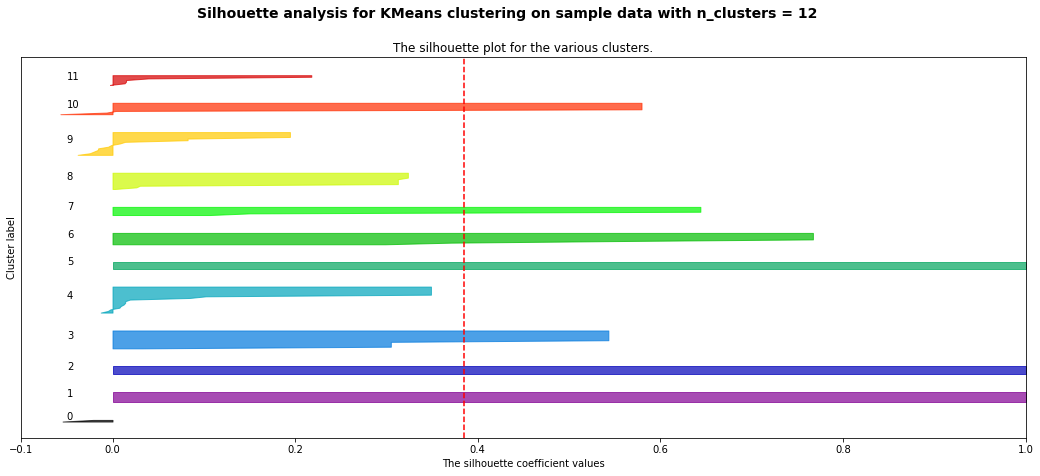

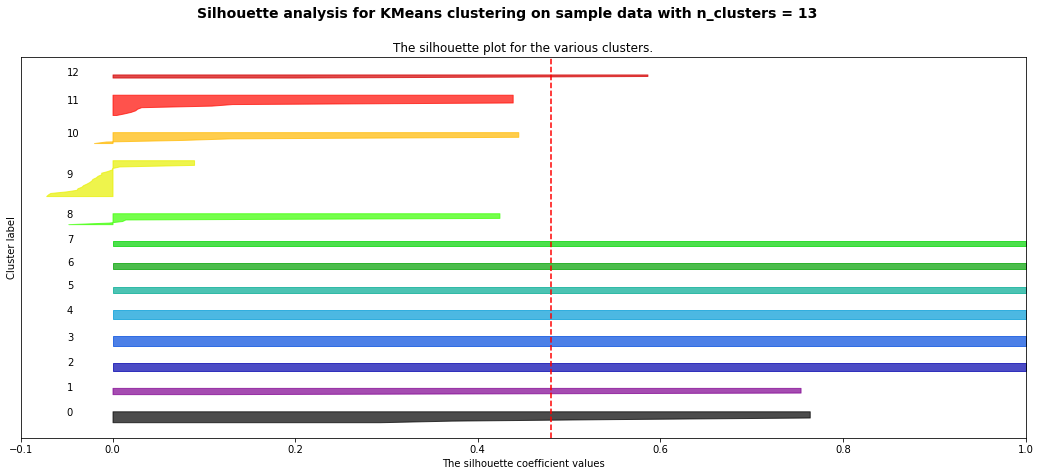

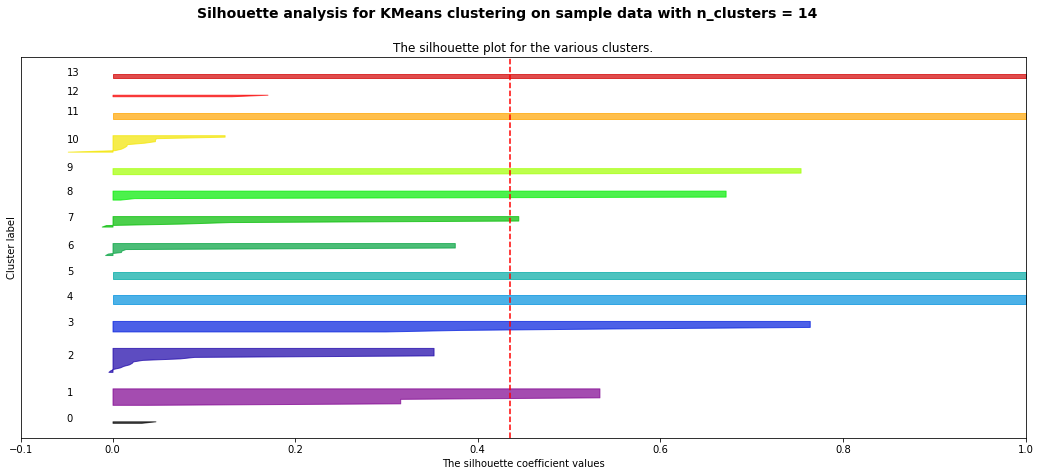

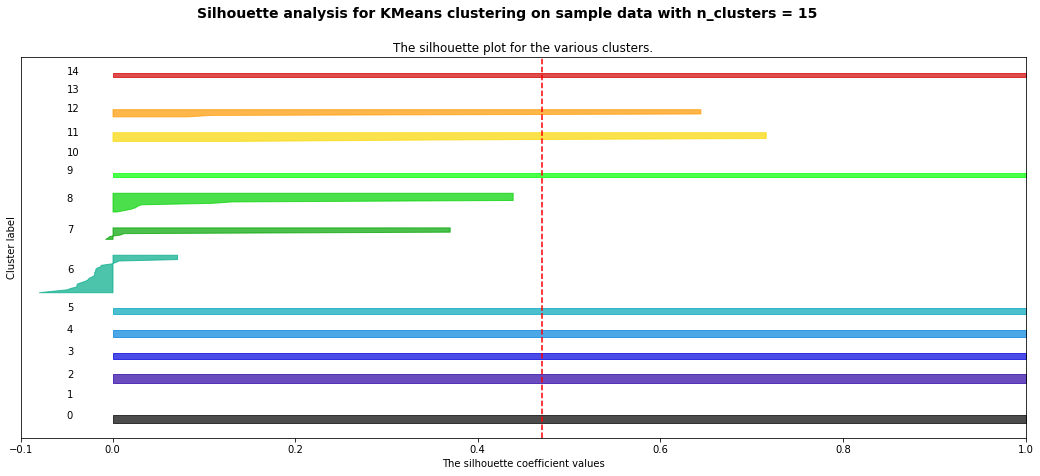

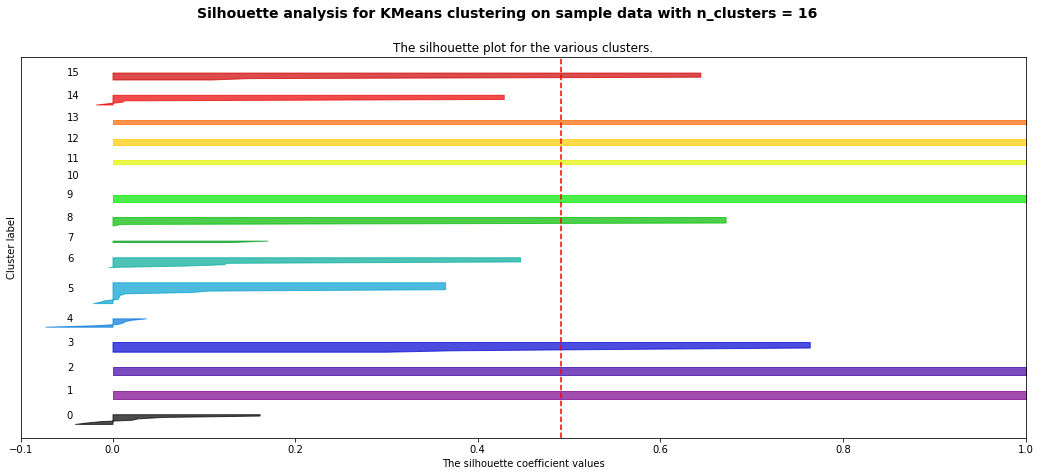

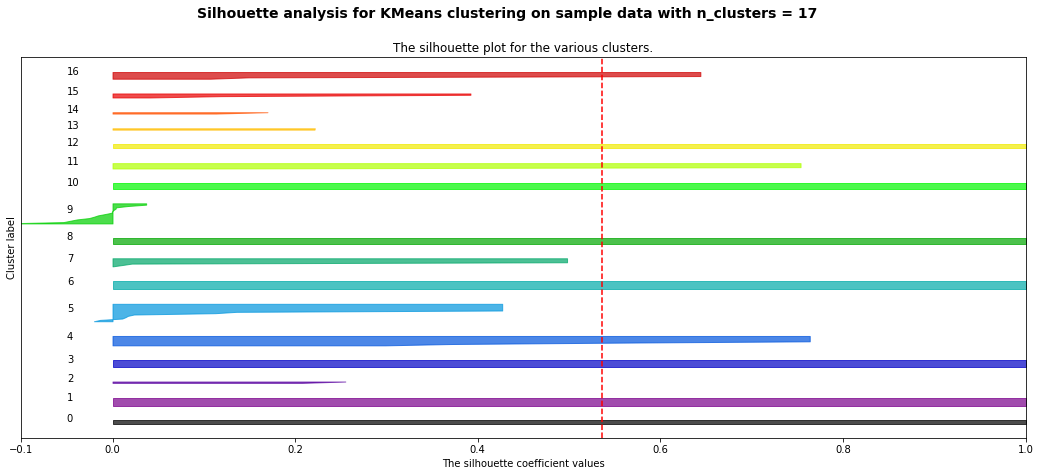

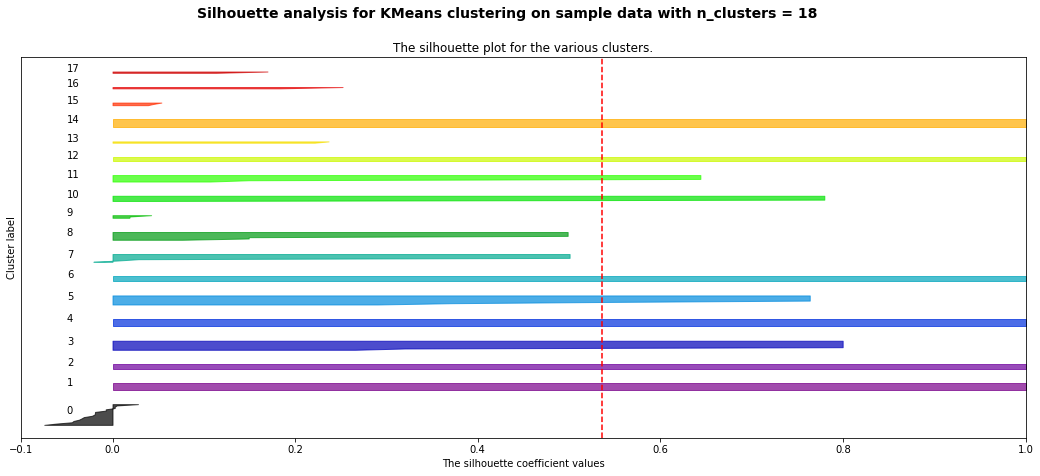

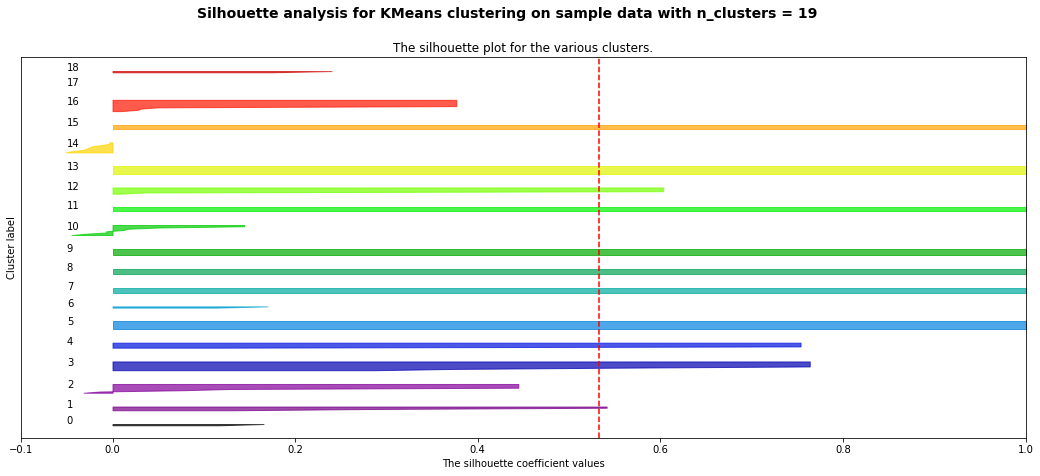

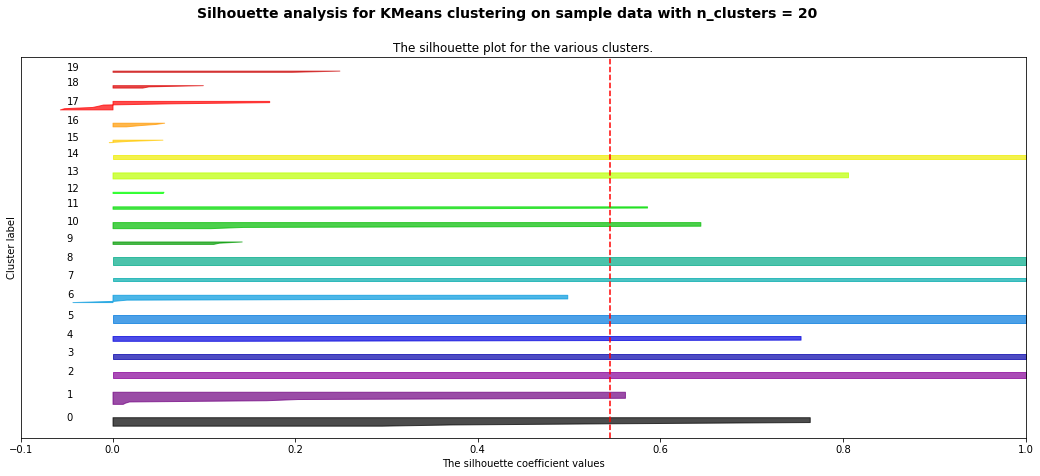

In [83]:
# Evaluate the different models using the Silhoutte Score

silhoutte_score_validation(model = GaussianMixture, transformer = TfidfVectorizer(lowercase = False), array = X)

###### I would be using 3 as the number of components as well to make better comparison. This because the data presents inconsistencies and sometimes it mislabel the data with 4 components.

In [84]:
# Creation of the pipeline

pipe_preprocessing = pipeline(est1 = TfidfVectorizer(lowercase = False))

pipe_predictor = pipeline2(est2 = GaussianMixture(n_components = 3))

pipe_gaussian_tf = pipeline3(pipeline = pipe_preprocessing, pipeline2 = pipe_predictor)

# Fit the final pipeline

pipe_gaussian_tf.fit(X)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('est1', TfidfVectorizer(lowercase=False)),
                                 ('pca', TruncatedSVD())])),
                ('predictor',
                 Pipeline(steps=[('est2', GaussianMixture(n_components=3))]))])

In [85]:
# Transform the data for the preprocessor

preprocessed_data = pipe_gaussian_tf['preprocessor'].transform(X)

# Labels Predictions

predicted_labels = pipe_gaussian_tf.predict(X)

In [86]:
# Get the coordenates for the keyword ("Aspiring Human Resources")

keywords_preprocessed = pipe_gaussian_tf['preprocessor'].transform([string_keyword])

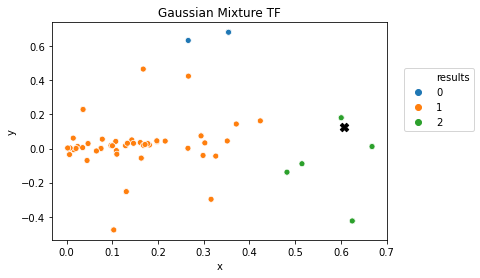

In [87]:
# Save the results in a data frame

results = results_df(preprocessing = preprocessed_data, predictions = predicted_labels)

# Plot the scatter plot with the centroids

plot_scatter(df = results, keyword = keywords_preprocessed, title = 'Gaussian Mixture TF')

In [88]:
# Apply the function that calculates the Levenshtain distance

results_gaussian_levenshtein_tf = levenshtein_distance(df = results, string =  string_keyword)

In [89]:
# See the fit of each person based on the euclidean distance

results_gaussian_tf = euclidean_distance(df = results_gaussian_levenshtein_tf, keyword = keywords_preprocessed)

In [90]:
# Results based on the euclidean distance

results_gaussian_tf.head(20)

,x,y,results,id,job_title,levenshtein_distance,levenshtein_distance_fit,euclidean_distance,euclidean_fit
0,0.600770,0.180262,2,58,aspiring human resources professional raleighd...,0.636364,0.529213,0.052797,0.948572
1,0.600770,0.180262,2,3,aspiring human resources professional raleighd...,0.636364,0.529213,0.052797,0.948572
2,0.600770,0.180262,2,21,aspiring human resources professional raleighd...,0.636364,0.529213,0.052797,0.948572
3,0.600770,0.180262,2,33,aspiring human resources professional raleighd...,0.636364,0.529213,0.052797,0.948572
4,0.600770,0.180262,2,17,aspiring human resources professional raleighd...,0.636364,0.529213,0.052797,0.948572
5,0.600770,0.180262,2,46,aspiring human resources professional raleighd...,0.636364,0.529213,0.052797,0.948572
6,0.668183,0.011543,2,9,student humber college aspiring human resource...,0.630769,0.532182,0.131396,0.876870
7,0.668183,0.011543,2,52,student humber college aspiring human resource...,0.630769,0.532182,0.131396,0.876870
8,0.668183,0.011543,2,37,student humber college aspiring human resource...,0.630769,0.532182,0.131396,0.876870
9,0.668183,0.011543,2,25,student humber college aspiring human resource...,0.630769,0.532182,0.131396,0.876870


In [91]:
results_gaussian_tf = final_fit(df = results_gaussian_tf)

results_gaussian_tf[['id', 'job_title', 'final_fit_model']].head(number_candidates)

,id,job_title,final_fit_model
0,58,aspiring human resources professional raleighd...,0.738893
1,21,aspiring human resources professional raleighd...,0.738893
2,33,aspiring human resources professional raleighd...,0.738893
3,17,aspiring human resources professional raleighd...,0.738893
4,46,aspiring human resources professional raleighd...,0.738893
5,3,aspiring human resources professional raleighd...,0.738893
6,39,student humber college aspiring human resource...,0.704526


In [92]:
# Calculation of the Calinski Harabasz Score

metric_score(array1 = preprocessed_data, array2 = predicted_labels)

The Calinski Harabasz Score is 77.50833329751211
The Davies Bouldin score is 0.6328090895295279


### Agglomerative Clustering

#### Count Vectorization

For n_clusters = 2 The average silhouette_score is : 0.12860688259133427
For n_clusters = 3 The average silhouette_score is : 0.18118272943613964
For n_clusters = 4 The average silhouette_score is : 0.22300797048681492
For n_clusters = 5 The average silhouette_score is : 0.2630114546349835
For n_clusters = 6 The average silhouette_score is : 0.30842283638314716
For n_clusters = 7 The average silhouette_score is : 0.2982904382798331
For n_clusters = 8 The average silhouette_score is : 0.3327861099755521
For n_clusters = 9 The average silhouette_score is : 0.37268445928089466
For n_clusters = 10 The average silhouette_score is : 0.4151519076934129
For n_clusters = 11 The average silhouette_score is : 0.45023956066550197
For n_clusters = 12 The average silhouette_score is : 0.4831343068187363
For n_clusters = 13 The average silhouette_score is : 0.5164666260406849
For n_clusters = 14 The average silhouette_score is : 0.5355840693224218
For n_clusters = 15 The average silhouette_score is :

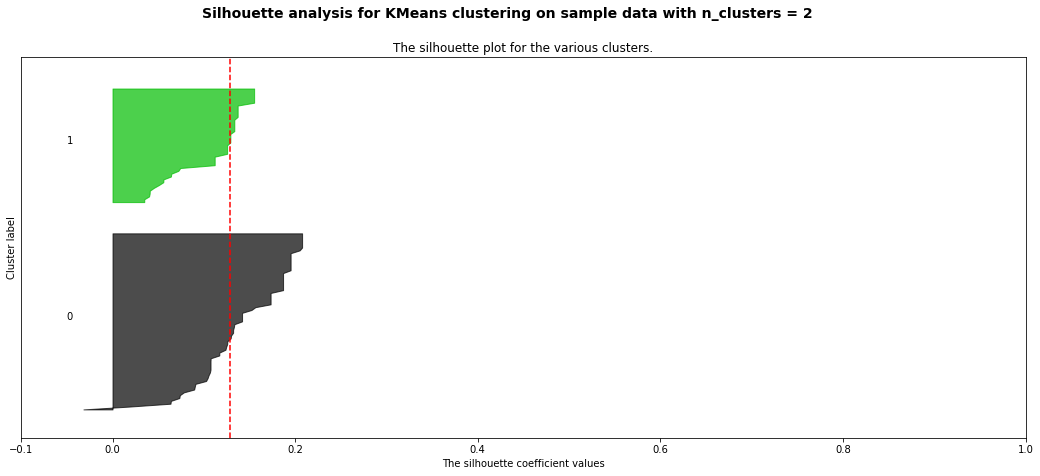

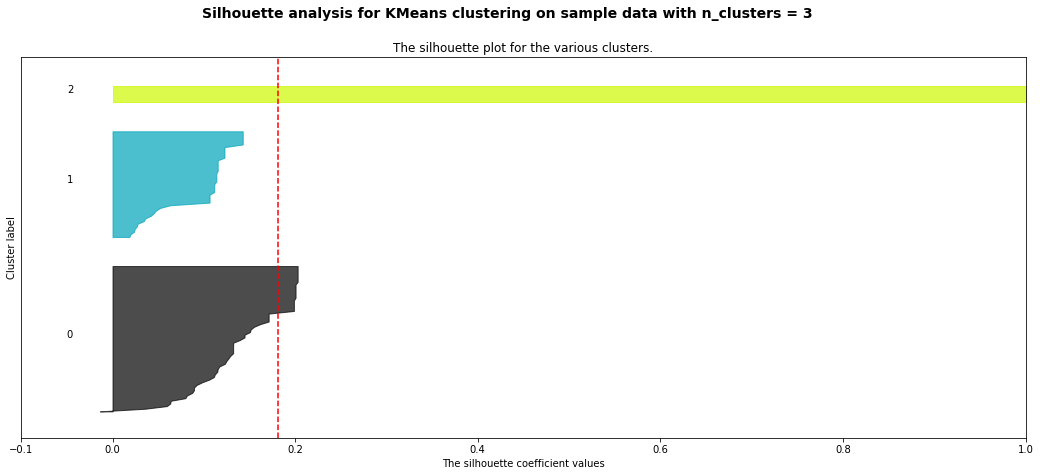

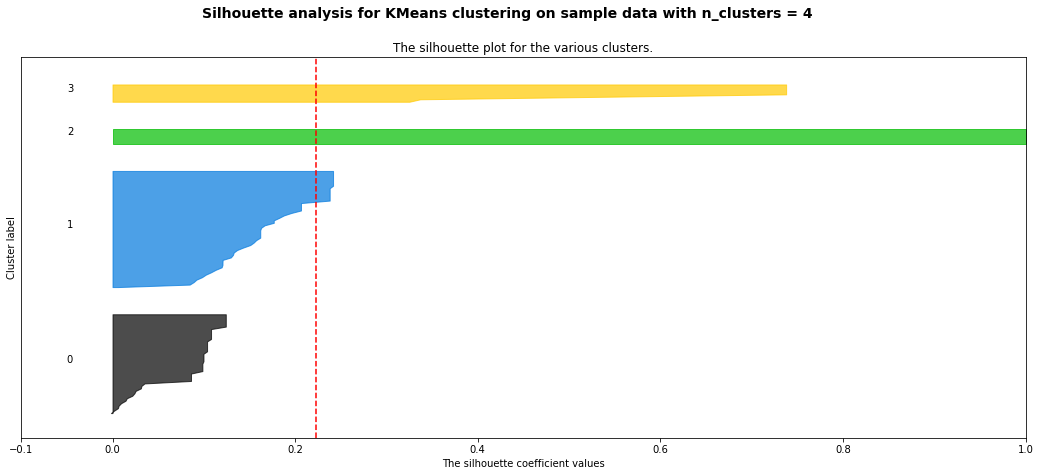

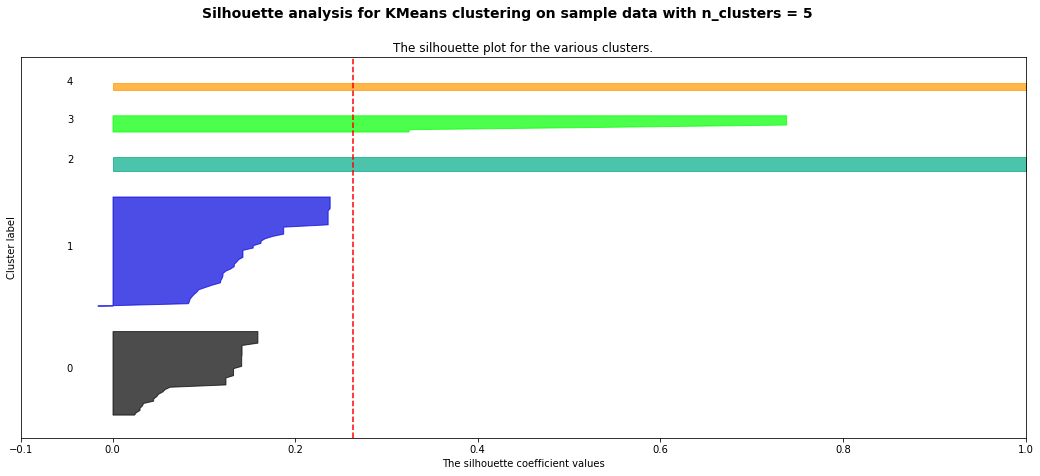

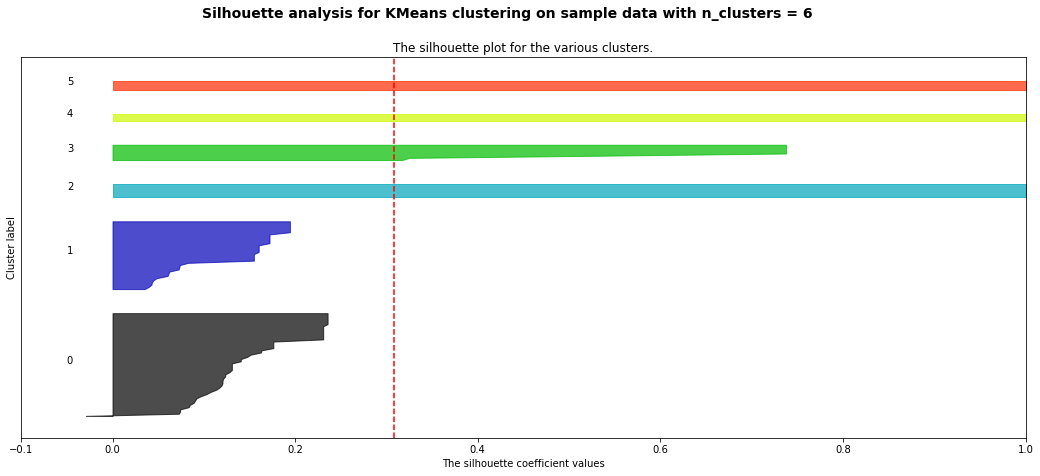

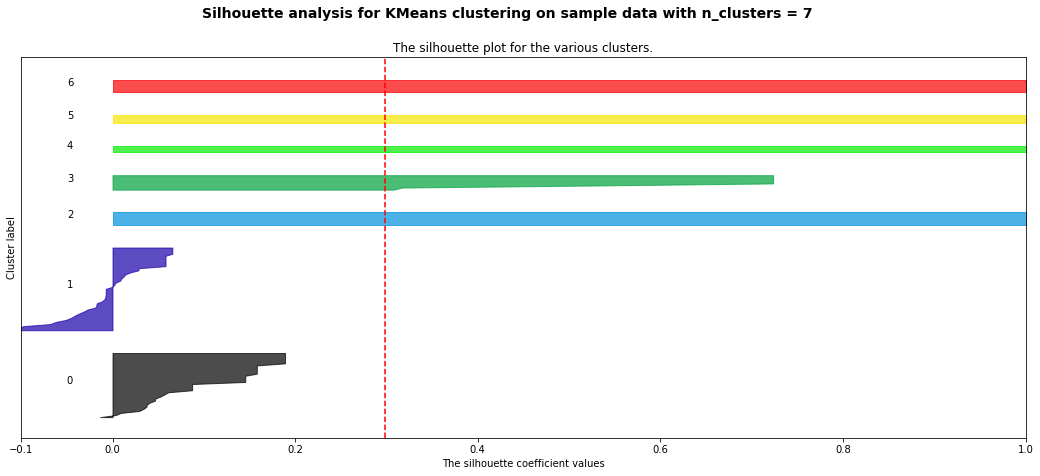

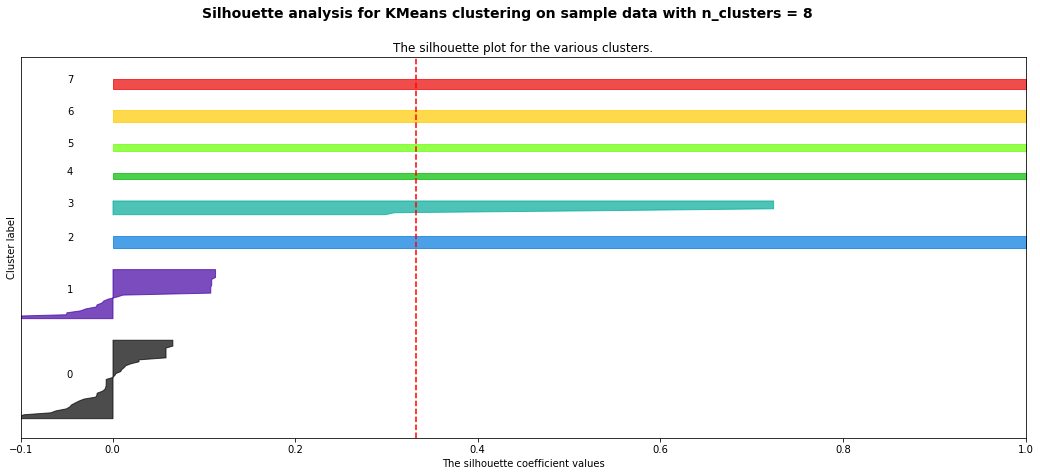

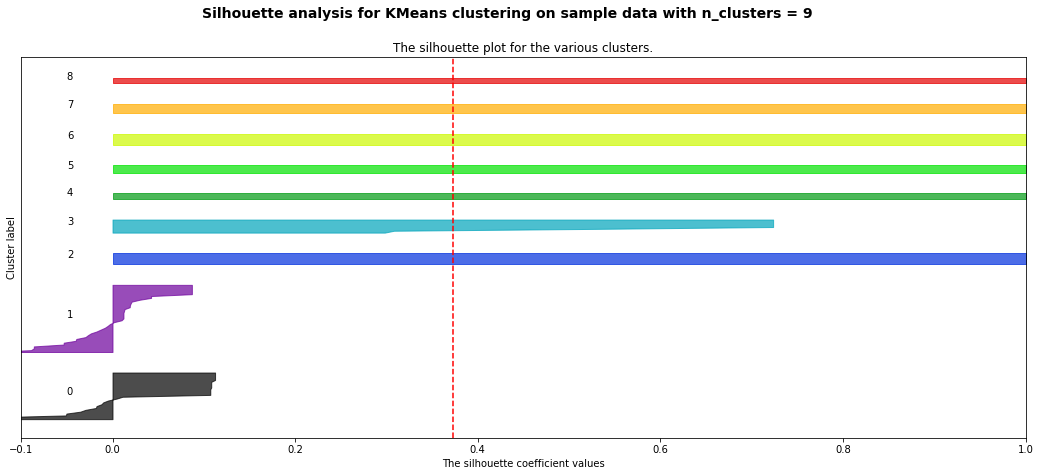

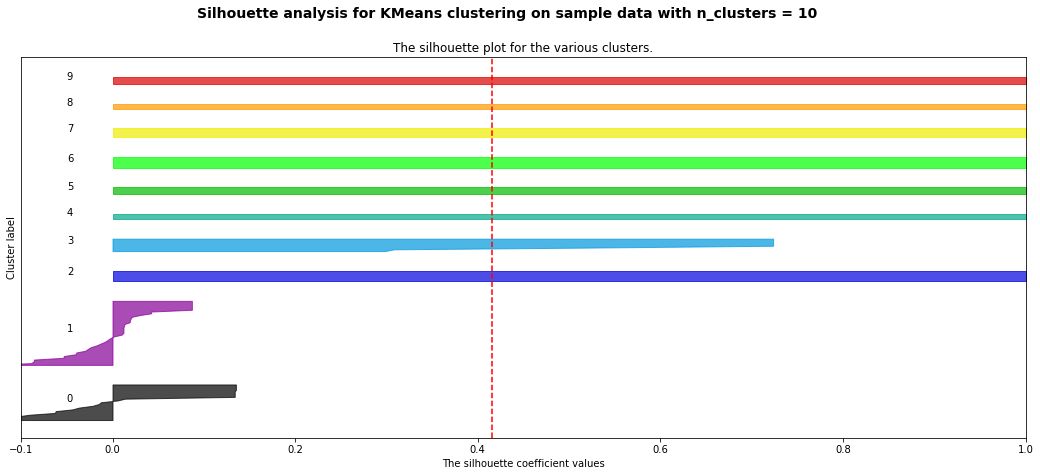

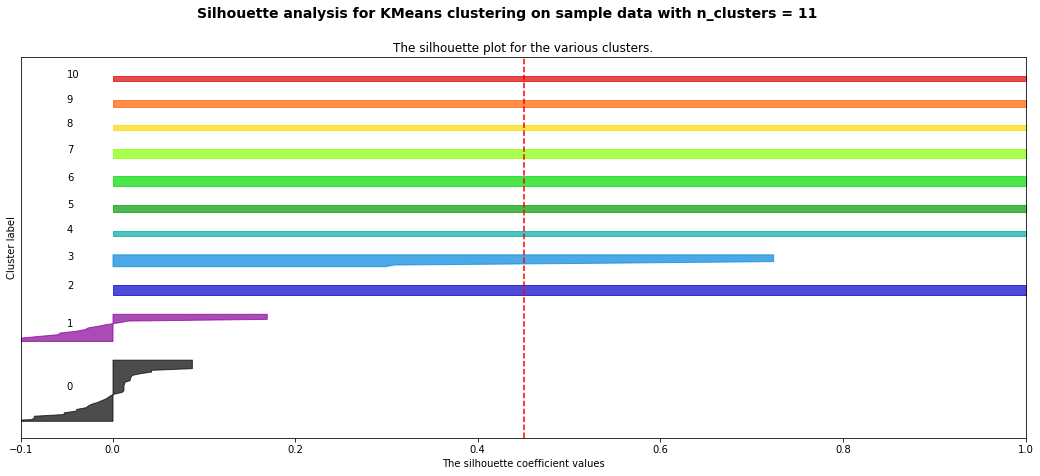

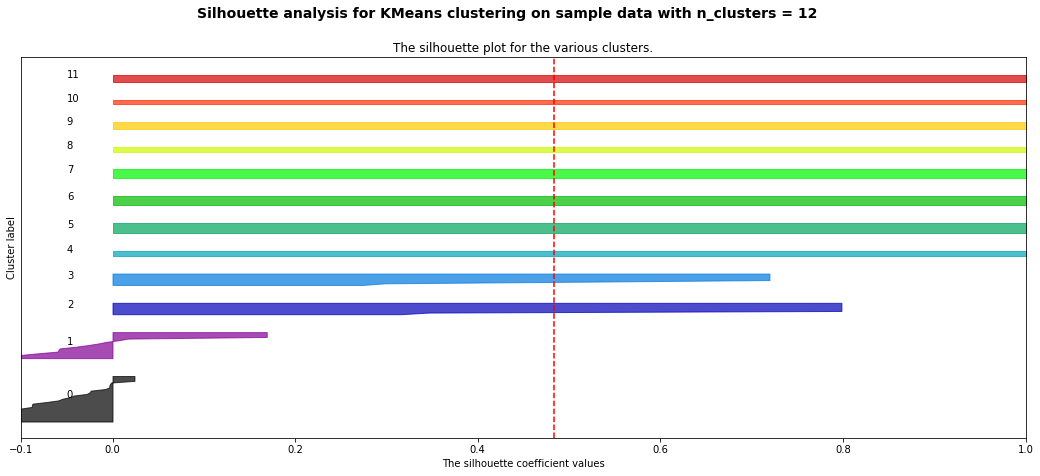

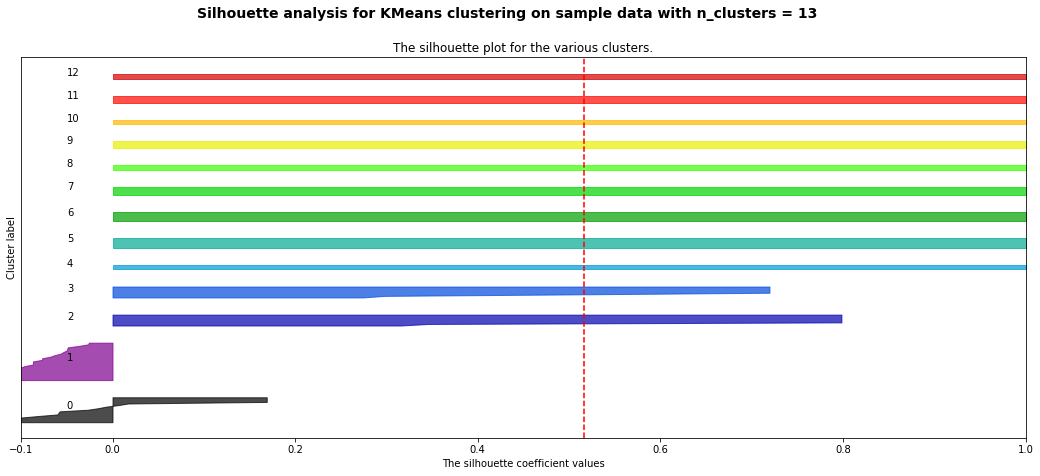

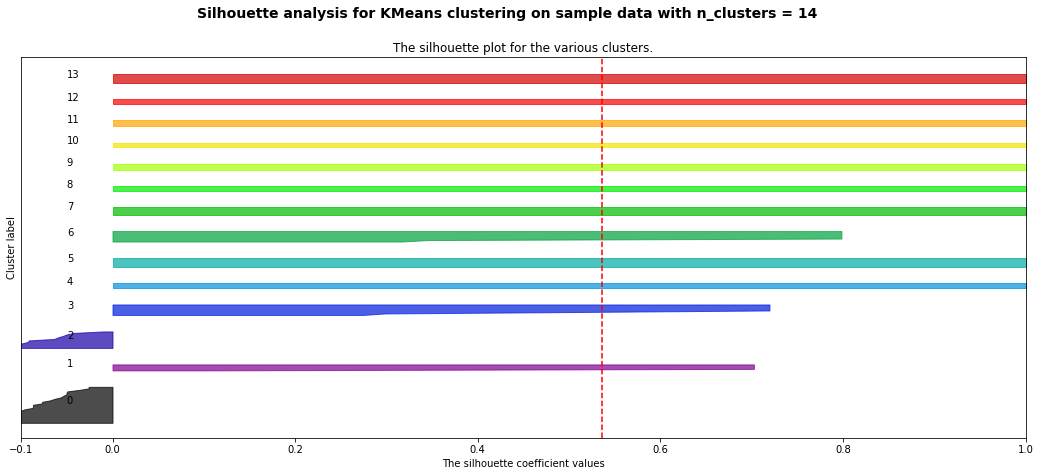

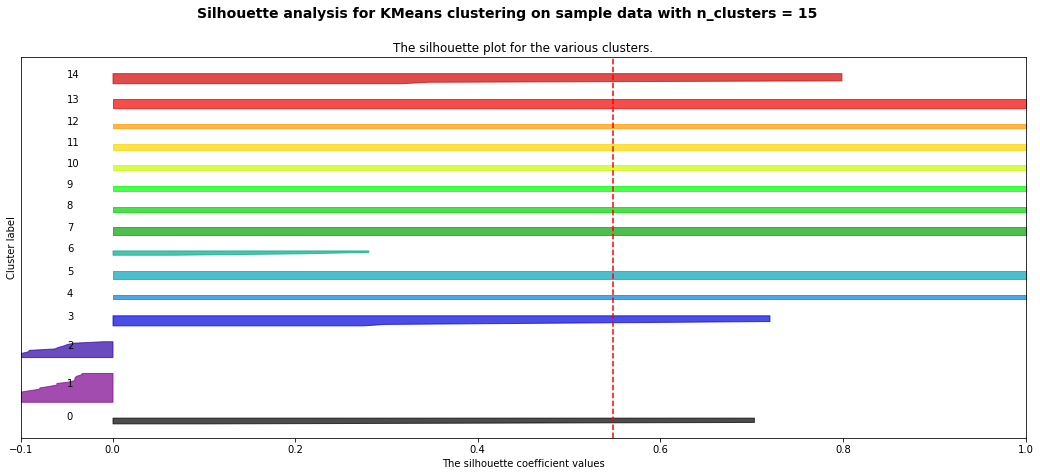

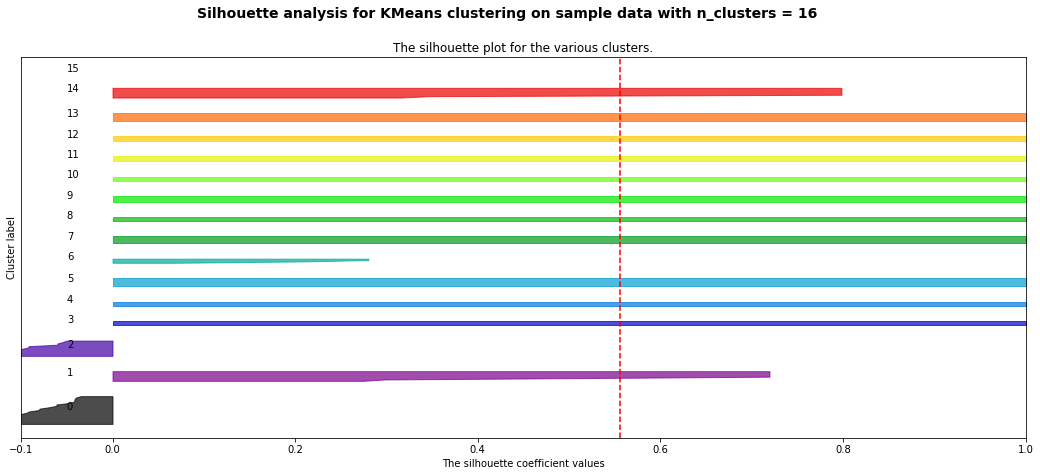

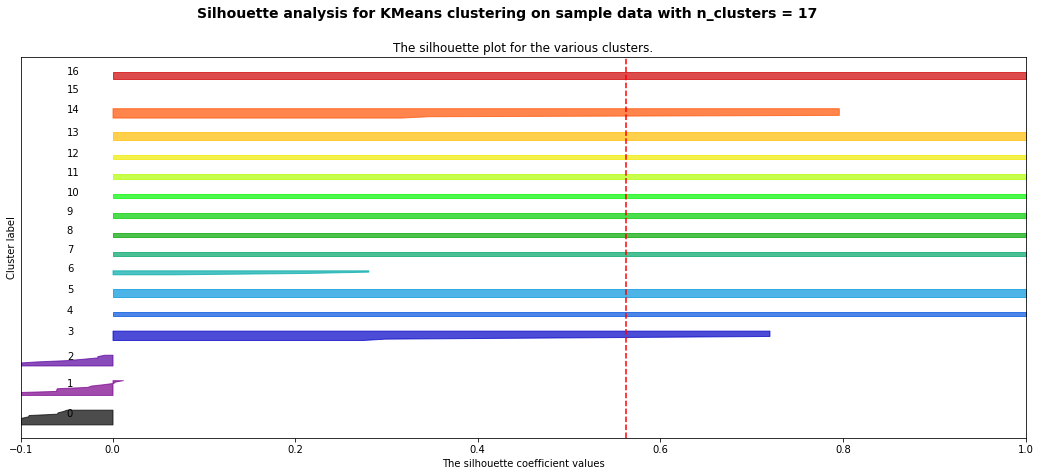

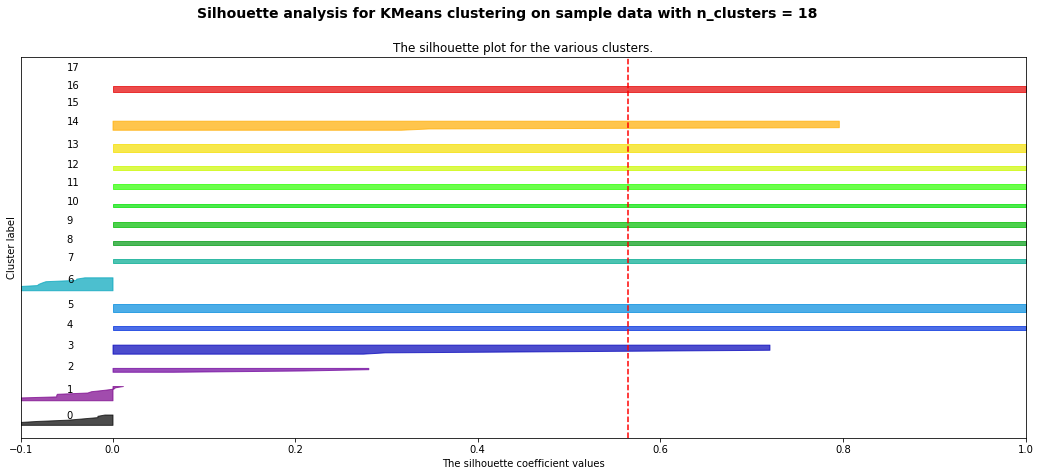

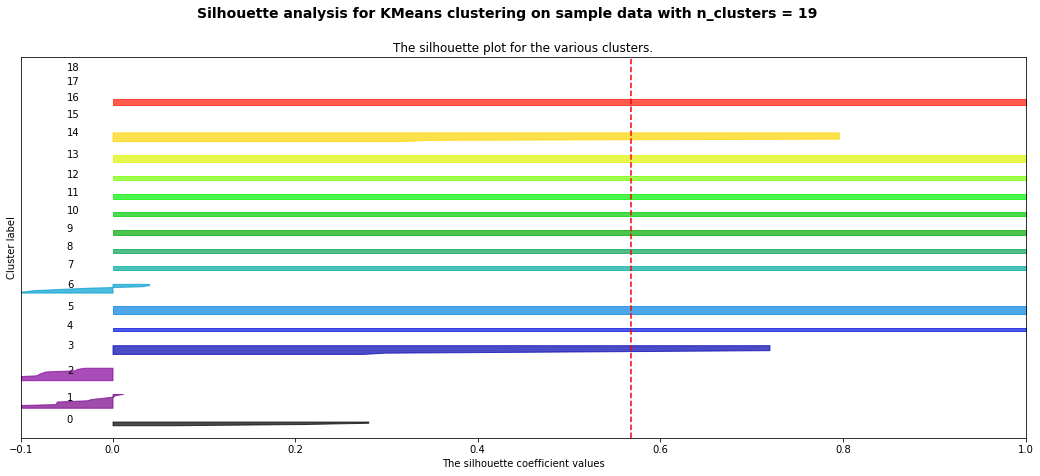

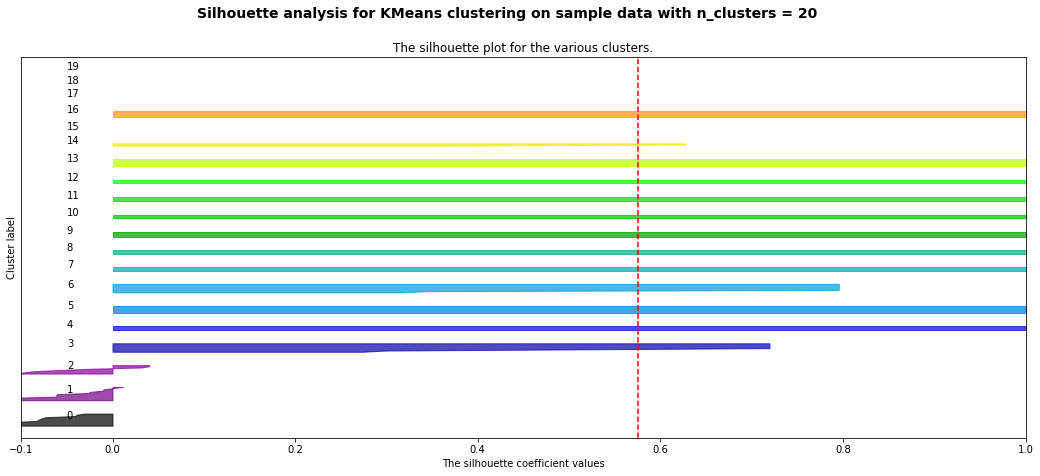

In [93]:
# Evaluate the different models using the Silhoutte Score

silhoutte_score_validation(model = AgglomerativeClustering, transformer = CountVectorizer(lowercase = False), array = X)

For n_clusters = 3 The average silhouette_score is : 0.4212166164425531

In [94]:
# Creation of the pipeline for Gaussian Mixture

pipe_preprocessing = pipeline(est1 = CountVectorizer(lowercase = False))

pipe_predictor = pipeline2(est2 = AgglomerativeClustering(4))

pipe_agglomerative_cv = pipeline3(pipeline = pipe_preprocessing, pipeline2 = pipe_predictor)

# Fit the final pipeline

pipe_agglomerative_cv.fit(X)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('est1', CountVectorizer(lowercase=False)),
                                 ('pca', TruncatedSVD())])),
                ('predictor',
                 Pipeline(steps=[('est2',
                                  AgglomerativeClustering(n_clusters=4))]))])

In [95]:
# Transform the data for the preprocessor

preprocessed_data = pipe_agglomerative_cv['preprocessor'].transform(X)

# Labels Predictions

predicted_labels = pipe_agglomerative_cv['predictor']['est2'].labels_

In [96]:
# Get the coordenates for the keyword ("Aspiring Human Resources")

keywords_preprocessed = pipe_agglomerative_cv['preprocessor'].transform([string_keyword])

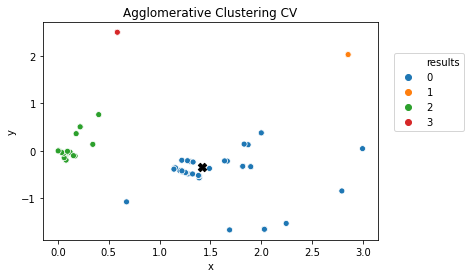

In [97]:
# Save the results in a data frame

results = results_df(preprocessing = preprocessed_data, predictions = predicted_labels)

# Plot the scatter plot with the centroids

plot_scatter(df = results, keyword = keywords_preprocessed, title = 'Agglomerative Clustering CV')

In [98]:
# Apply the function that calculates the Levenshtain distance

results_agglomerative_levenshtein_cv = levenshtein_distance(df = results, string =  string_keyword)

In [99]:
# See the fit of each person based on the euclidean distance

results_agglomerative_cv = euclidean_distance(df = results_agglomerative_levenshtein_cv, keyword = keywords_preprocessed)

In [100]:
# Results based on the euclidean distance

results_agglomerative_cv.head(20)

,x,y,results,id,job_title,levenshtein_distance,levenshtein_distance_fit,euclidean_distance,euclidean_fit
0,1.490821,-0.374298,0,79,liberal arts major aspiring human resources an...,0.671233,0.511078,0.080650,0.922516
1,1.330004,-0.238298,0,84,human resources professional world leader gis ...,0.837838,0.432645,0.132045,0.876302
2,1.299063,-0.224457,0,67,human resources staffing recruiting profession...,0.764706,0.465471,0.163897,0.848830
3,1.324197,-0.490743,0,70,retired army national guard recruiter office m...,0.798165,0.450154,0.184152,0.831809
4,1.274800,-0.210764,0,74,human resources professional boston,0.800000,0.449329,0.191190,0.825976
5,1.382637,-0.521787,0,101,human resources generalist loparex raleighdurh...,0.809524,0.445070,0.191607,0.825631
6,1.389172,-0.528148,0,71,human resources generalist scottmadden inc ral...,0.802817,0.448065,0.196683,0.821451
7,1.254877,-0.460583,0,94,seeking human resources opportunities open tra...,0.768293,0.463804,0.208773,0.811579
8,1.279331,-0.487836,0,56,human resources coordinator intercontinental b...,0.844156,0.429920,0.209052,0.811353
9,1.279331,-0.487836,0,43,human resources coordinator intercontinental b...,0.844156,0.429920,0.209052,0.811353


In [101]:
results_agglomerative_cv = final_fit(df = results_agglomerative_cv)

results_agglomerative_cv = results_agglomerative_cv[['id', 'job_title', 'final_fit_model']].head(number_candidates)

In [102]:
results_agglomerative_cv

,id,job_title,final_fit_model
0,79,liberal arts major aspiring human resources an...,0.716797
1,97,aspiring human resources professional kokomo i...,0.681555
2,99,seeking human resources position las vegas nevada,0.672203
3,89,director human resources ey atlanta,0.666407
4,28,seeking human resources opportunities chicago ...,0.661984
5,30,seeking human resources opportunities chicago ...,0.661984
6,67,human resources staffing recruiting profession...,0.657150


In [103]:
# Calculation of the Calinski Harabasz Score

metric_score(array1 = preprocessed_data, array2 = predicted_labels)

The Calinski Harabasz Score is 186.41495862730656
The Davies Bouldin score is 0.32342548224372425


#### TF-IDF

For n_clusters = 2 The average silhouette_score is : 0.07393285739588684
For n_clusters = 3 The average silhouette_score is : 0.11874862087923135
For n_clusters = 4 The average silhouette_score is : 0.16923585300938254
For n_clusters = 5 The average silhouette_score is : 0.2244581896258739
For n_clusters = 6 The average silhouette_score is : 0.2817320641496416
For n_clusters = 7 The average silhouette_score is : 0.3313782721219691
For n_clusters = 8 The average silhouette_score is : 0.37893727099822205
For n_clusters = 9 The average silhouette_score is : 0.4108992393052435
For n_clusters = 10 The average silhouette_score is : 0.44989908214595115
For n_clusters = 11 The average silhouette_score is : 0.4849914655096557
For n_clusters = 12 The average silhouette_score is : 0.5269112259318938
For n_clusters = 13 The average silhouette_score is : 0.5619196909435848
For n_clusters = 14 The average silhouette_score is : 0.5776311490442422
For n_clusters = 15 The average silhouette_score is : 

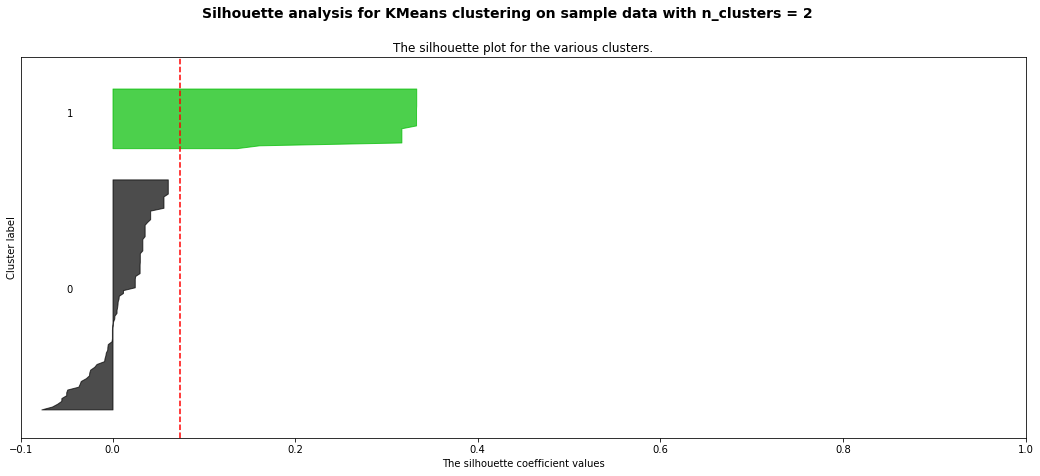

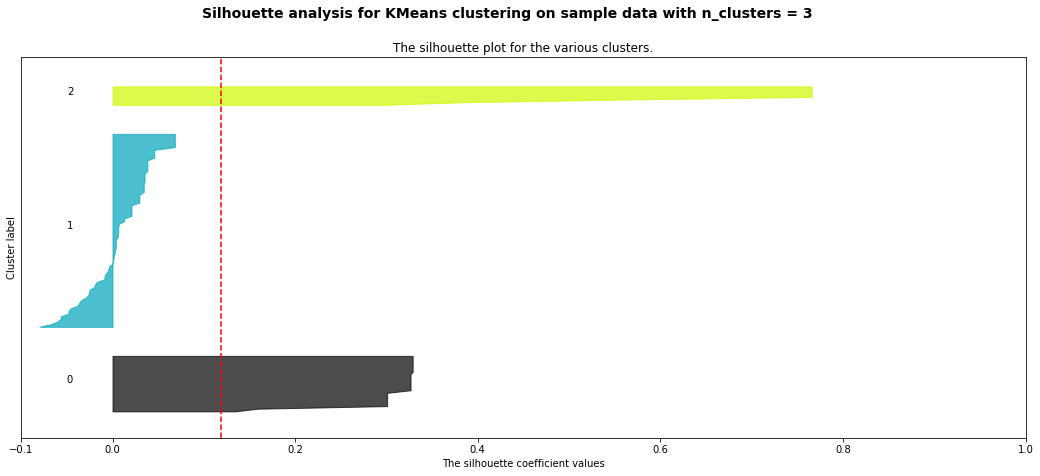

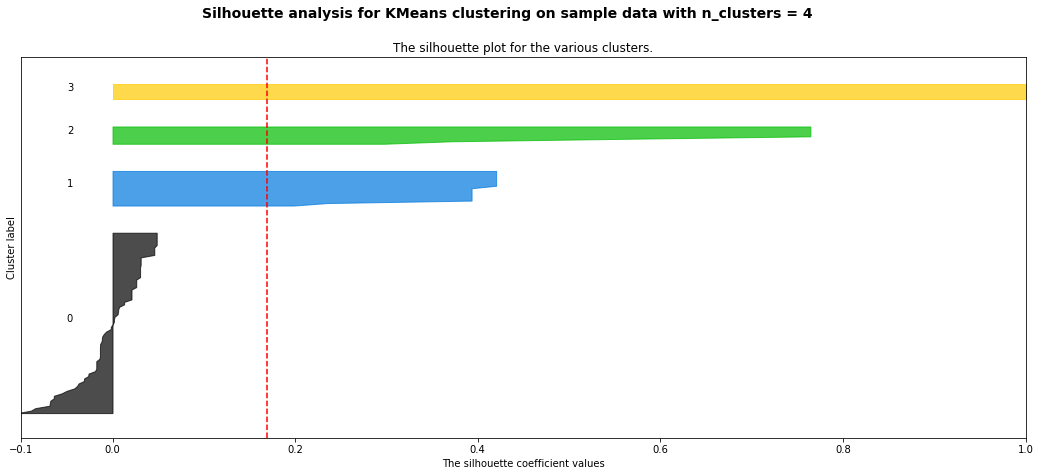

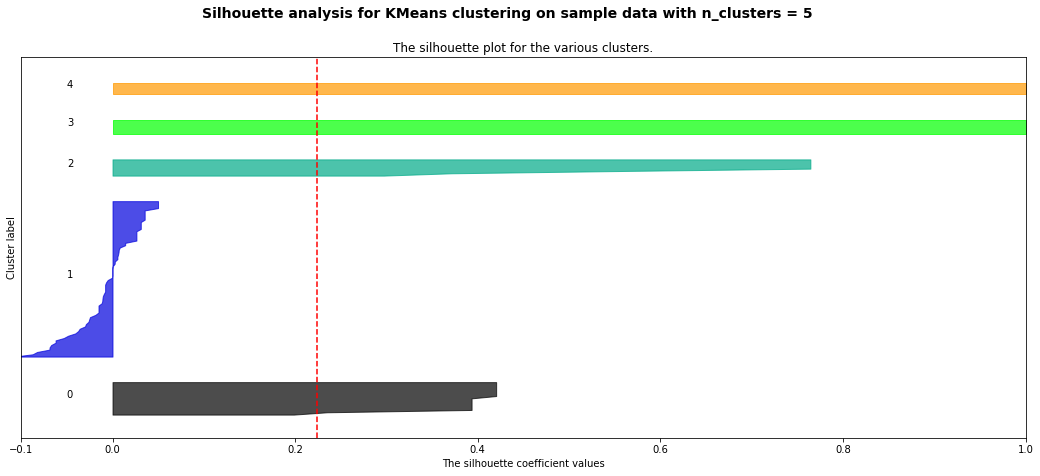

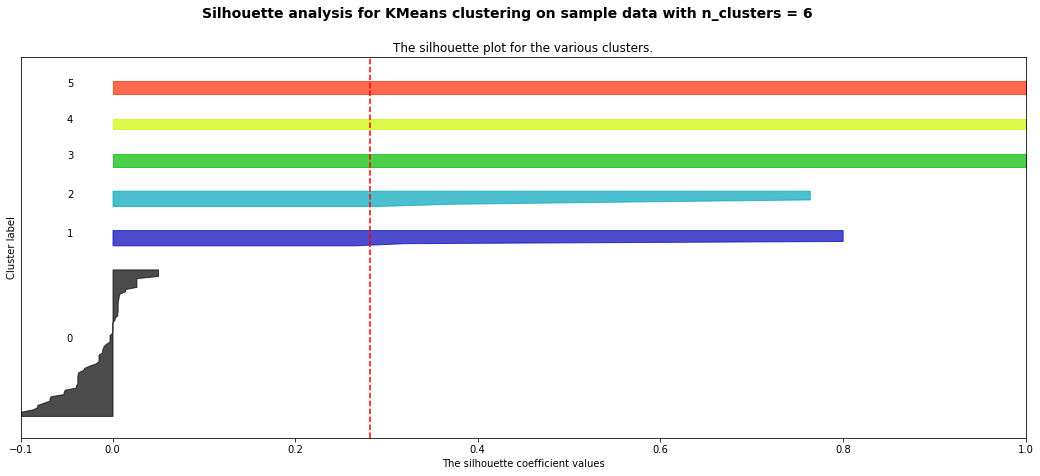

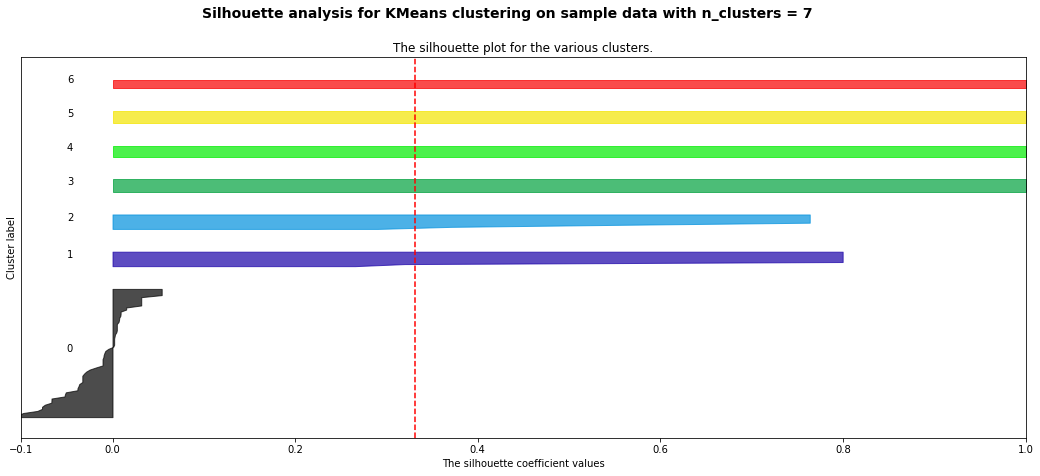

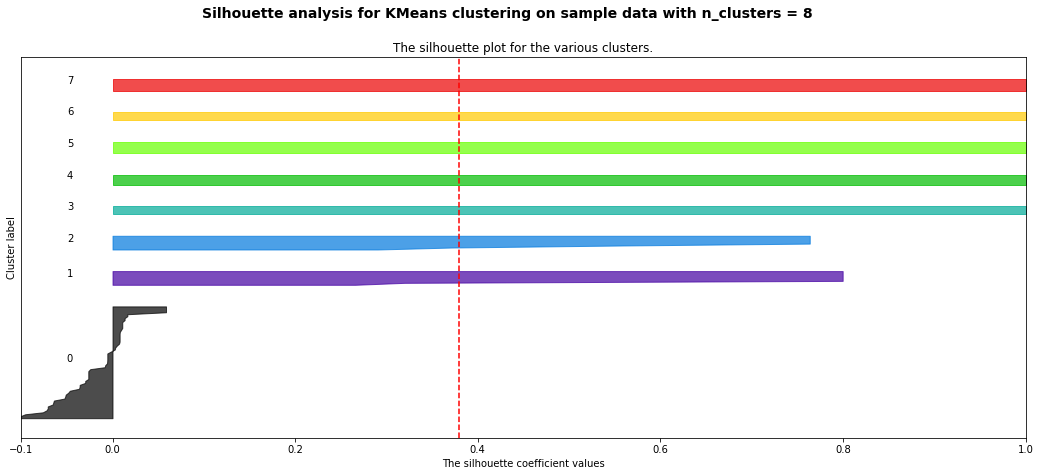

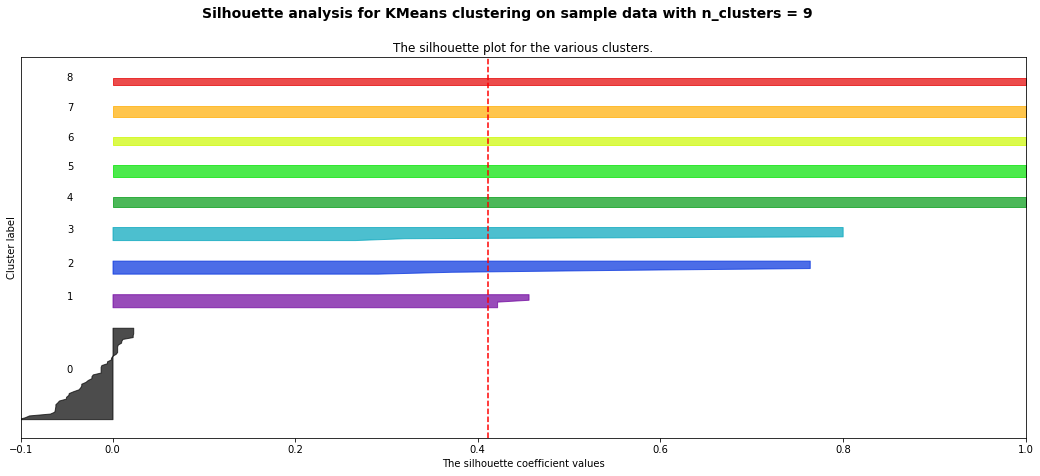

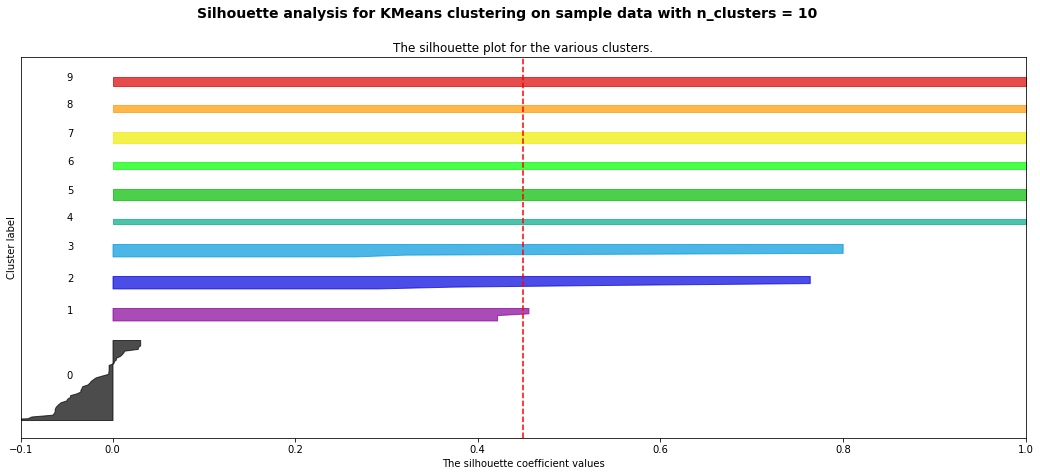

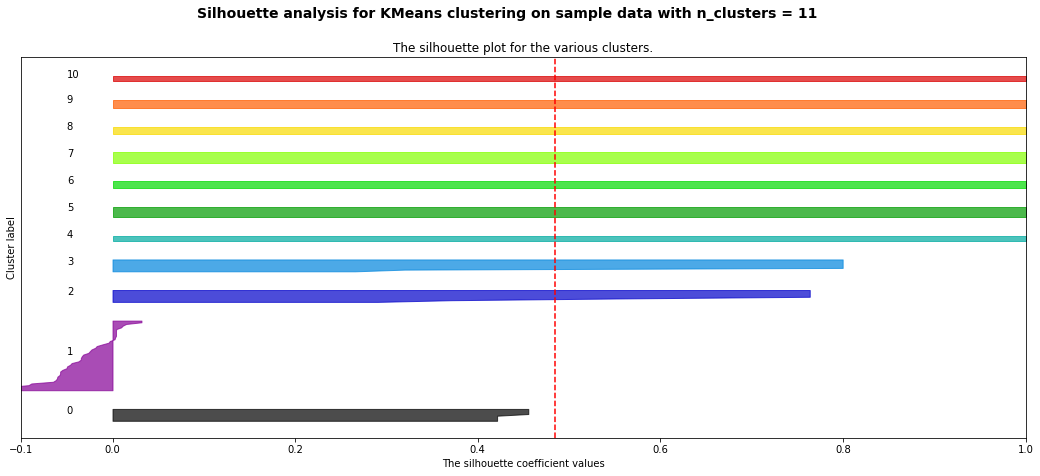

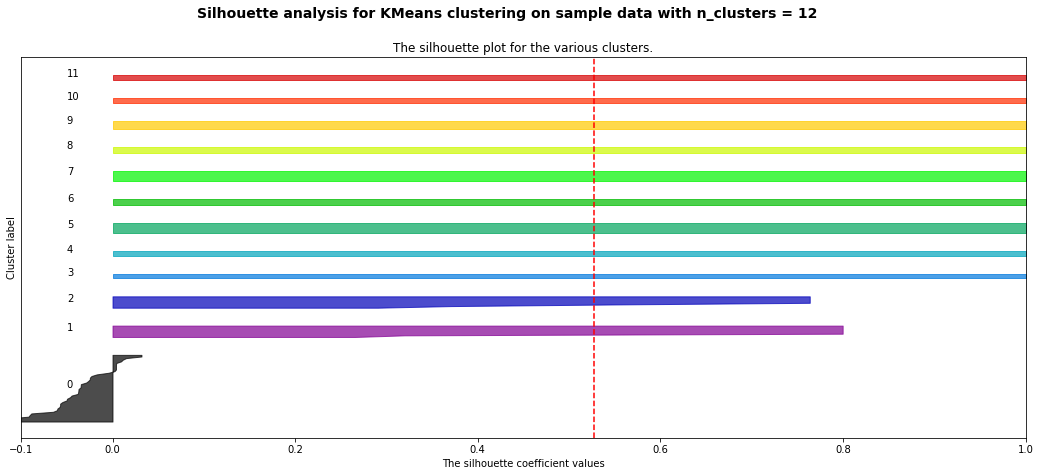

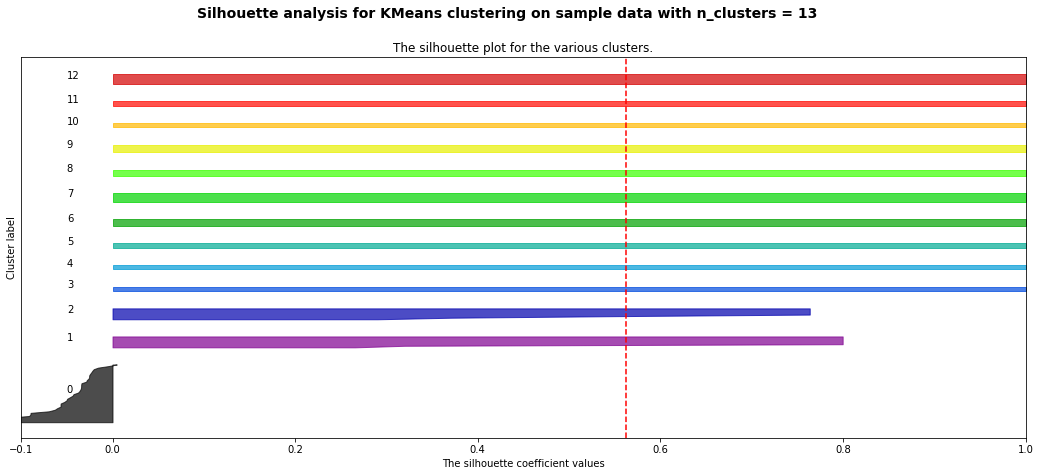

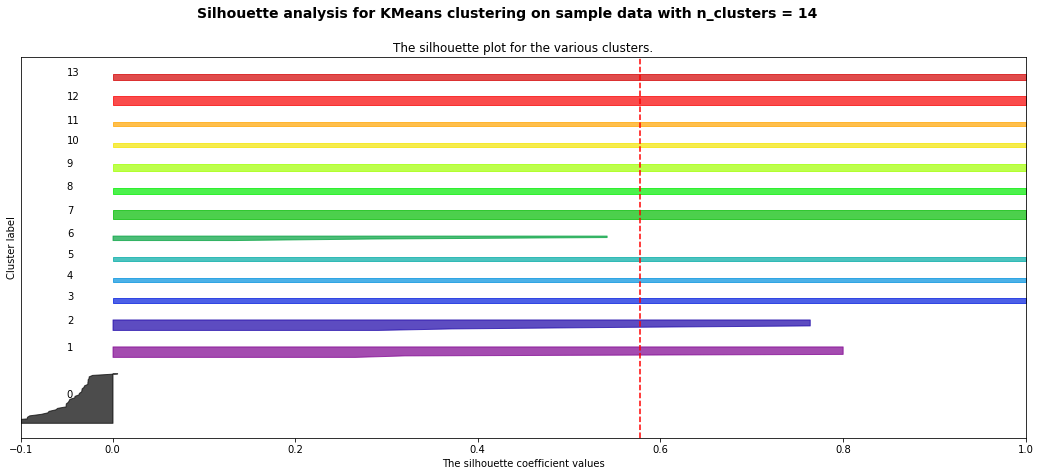

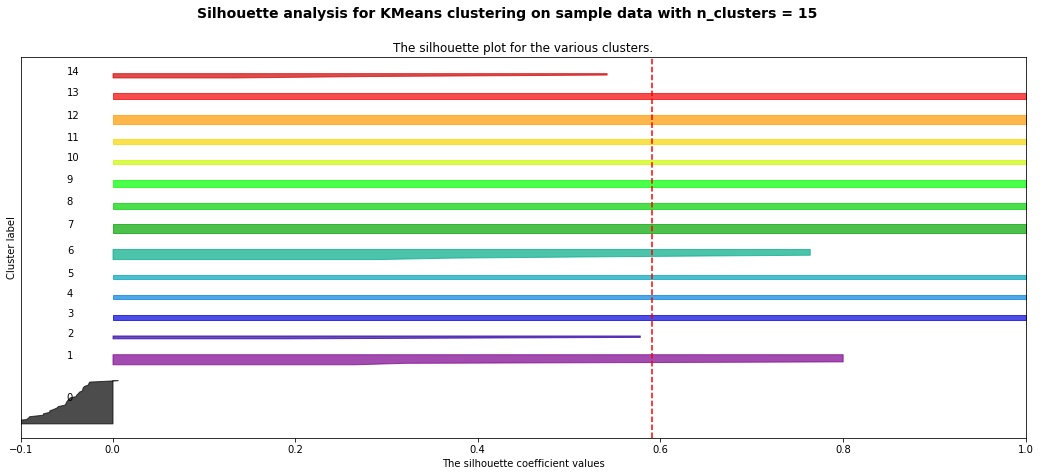

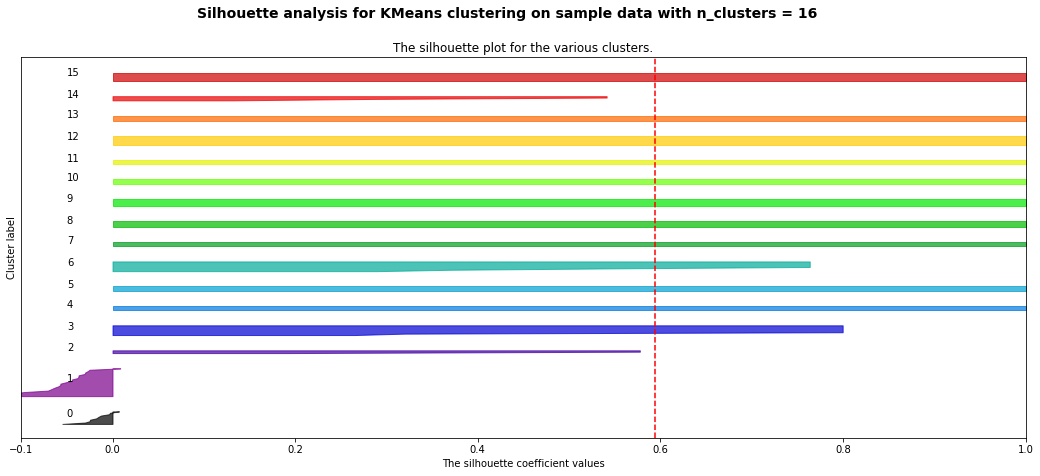

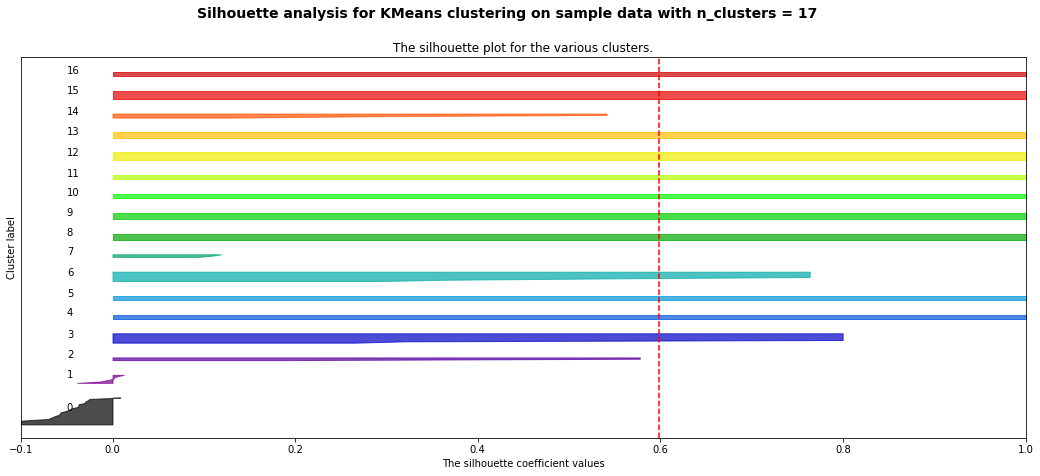

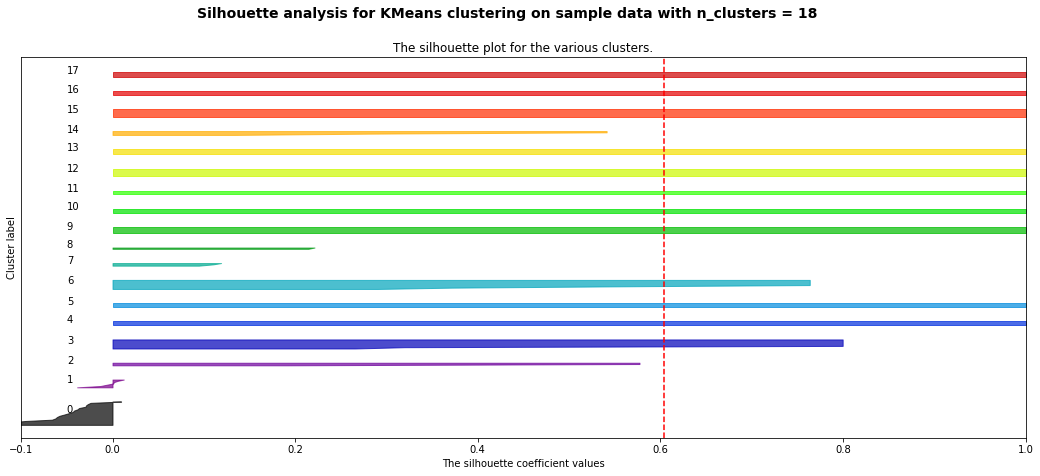

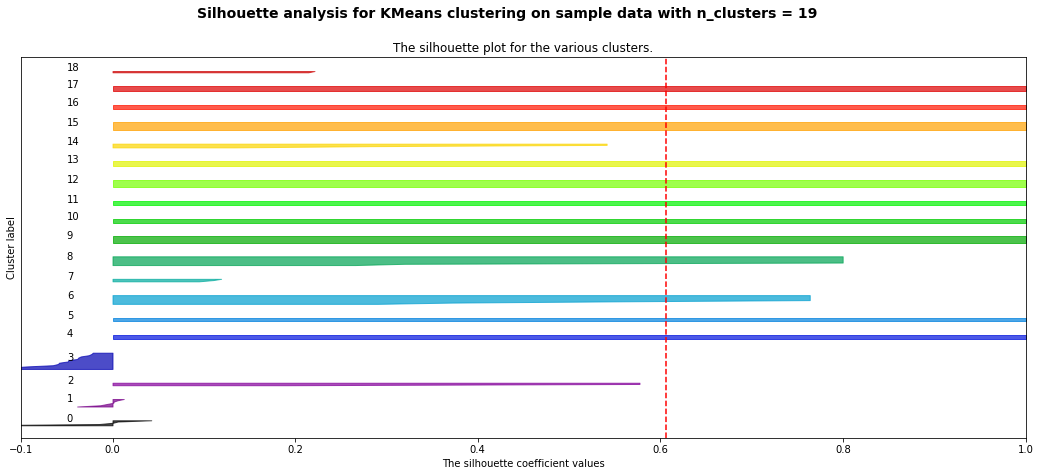

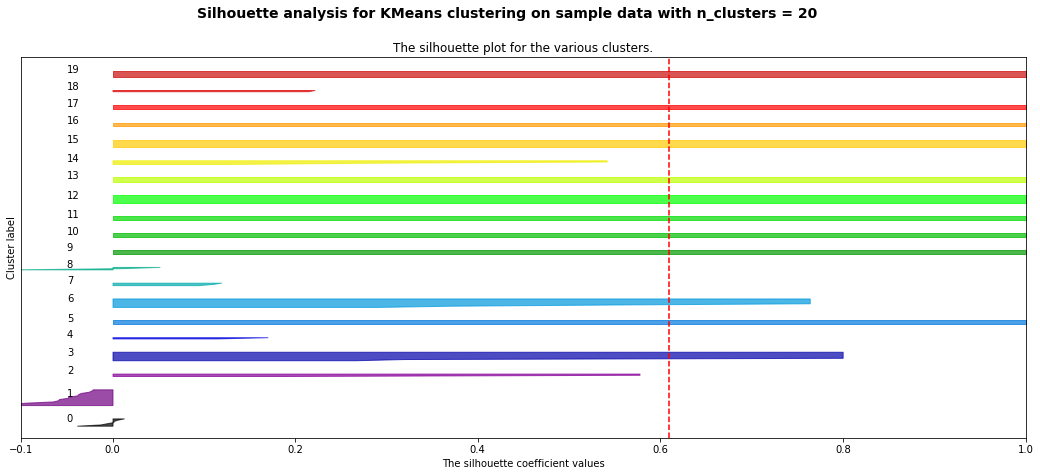

In [104]:
# Evaluate the different models using the Silhoutte Score

silhoutte_score_validation(model = AgglomerativeClustering, transformer = TfidfVectorizer(lowercase = False), array = X)

In [105]:
# Creation of the pipeline for Gaussian Mixture

pipe_preprocessing = pipeline(est1 = TfidfVectorizer(lowercase = False))

pipe_predictor = pipeline2(est2 = AgglomerativeClustering(4))

pipe_agglomerative_cv = pipeline3(pipeline = pipe_preprocessing, pipeline2 = pipe_predictor)

# Fit the final pipeline

pipe_agglomerative_cv.fit(X)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('est1', TfidfVectorizer(lowercase=False)),
                                 ('pca', TruncatedSVD())])),
                ('predictor',
                 Pipeline(steps=[('est2',
                                  AgglomerativeClustering(n_clusters=4))]))])

In [106]:
# Transform the data for the preprocessor

preprocessed_data = pipe_agglomerative_cv['preprocessor'].transform(X)

# Labels Predictions

predicted_labels = pipe_agglomerative_cv['predictor']['est2'].labels_

In [107]:
# Get the coordenates for the keyword ("Aspiring Human Resources")

keywords_preprocessed = pipe_agglomerative_cv['preprocessor'].transform([string_keyword])

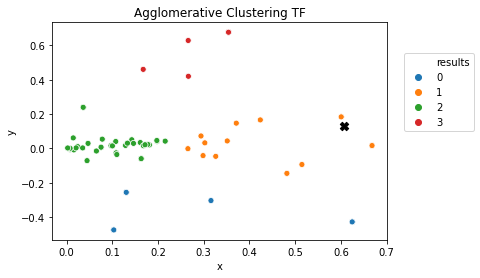

In [108]:
# Save the results in a data frame

results = results_df(preprocessing = preprocessed_data, predictions = predicted_labels)

# Plot the scatter plot with the centroids

plot_scatter(df = results, keyword = keywords_preprocessed, title = 'Agglomerative Clustering TF')

In [109]:
# Apply the function that calculates the Levenshtain distance

results_agglomerative_levenshtein_tf = levenshtein_distance(df = results, string =  string_keyword)

In [110]:
# See the fit of each person based on the euclidean distance

results_agglomerative_tf = euclidean_distance(df = results_agglomerative_levenshtein_tf, keyword = keywords_preprocessed)

In [111]:
results_agglomerative_tf = final_fit(df = results_agglomerative_tf)

results_agglomerative_tf[['id', 'job_title', 'final_fit_model']]

,id,job_title,final_fit_model
0,58,aspiring human resources professional raleighd...,0.737225
1,21,aspiring human resources professional raleighd...,0.737225
2,33,aspiring human resources professional raleighd...,0.737225
3,17,aspiring human resources professional raleighd...,0.737225
4,46,aspiring human resources professional raleighd...,0.737225
...,...,...,...
99,18,people development coordinator ryan denton texas,0.459358
100,34,people development coordinator ryan denton texas,0.459358
101,59,people development coordinator ryan denton texas,0.459358
102,22,people development coordinator ryan denton texas,0.459358


In [112]:
# Calculation of the Calinski Harabasz Score

metric_score(array1 = preprocessed_data, array2 = predicted_labels)

The Calinski Harabasz Score is 109.37301002222092
The Davies Bouldin score is 0.7483500712153192


#### Insights in order to select the model


###### I try out multiples times the Silhoutte Score on the same model in oder to calculate the number of clusters/components to use in order to select the candidates. The model that showed better consistencies after running the silhoutte score example was the Agglomerative Clustering with Count Vectorization and 3 clusters (I also needed to make sure not so many clusters were used because of the prevention of overfitting). 

###### The agglomerative clustering also presented a decent Calisnki and Davies Bouldin score even though is lower than in some models that were also used. For instance if I compare these scores with the scores obtained using the Affinity Propagation, the scores of the agglomerative clustering were lower, but this can be explained because of the presence of less clusters.

###### For the other models, the number of clusters to determine the Silhoutte score varies and they don't present consistency, so based on this I used the model that gave me the higher consistency with the data.

###### Agglomerative Clustering model with 3 components and using Count Vectorization

In [113]:
# See the results with the best model performance

results_agglomerative_cv

,id,job_title,final_fit_model
0,79,liberal arts major aspiring human resources an...,0.716797
1,97,aspiring human resources professional kokomo i...,0.681555
2,99,seeking human resources position las vegas nevada,0.672203
3,89,director human resources ey atlanta,0.666407
4,28,seeking human resources opportunities chicago ...,0.661984
5,30,seeking human resources opportunities chicago ...,0.661984
6,67,human resources staffing recruiting profession...,0.657150


In [114]:
# Create a new column that will be the fit an user will put for the specific candidate

fit_manual = []

# The range would be from the candidate one (zero index) to the length of the number of candidates selected
for i in range(number_candidates):
    #Make the reader know the input must be between 0 and 1.0
    print('Insert the fit score for the candidate that must be between 0 and 1.0')
    # This score will be manually inserted by the person in charge
    x = float(input('Insert fit score: '))
    # Make sure the fit score would be under 1.0
    while x > 1.0:
        print('Value must be between 0 and 1.0')
        # All the scores would go to an empty list
        x = float(input('Insert fit score'))
    else:
        fit_manual.append(x)
    

# Append the list to the data frame

results_agglomerative_cv['fit_manual'] = fit_manual

# I will try to avoid any human bias by creating a new column that will indicate the final fit by using a weighted 
#average

results_agglomerative_cv['final_score'] = results_agglomerative_cv['final_fit_model']*0.5 + results_agglomerative_cv['fit_manual']*0.5

#Finally sort the values by descending order

results_agglomerative_cv = results_agglomerative_cv.sort_values(by = 'final_score', ascending = False)

#See the final data frame with the final fits score

print('Final data frame for the candidates')
results_agglomerative_cv

Insert the fit score for the candidate that must be between 0 and 1.0
Insert fit score: 0.7
Insert the fit score for the candidate that must be between 0 and 1.0
Insert fit score: 0.6
Insert the fit score for the candidate that must be between 0 and 1.0
Insert fit score: 0.8
Insert the fit score for the candidate that must be between 0 and 1.0
Insert fit score: 0.9
Insert the fit score for the candidate that must be between 0 and 1.0
Insert fit score: 1.0
Insert the fit score for the candidate that must be between 0 and 1.0
Insert fit score: 0.5
Insert the fit score for the candidate that must be between 0 and 1.0
Insert fit score: 0.8
Final data frame for the candidates


,id,job_title,final_fit_model,fit_manual,final_score
4,28,seeking human resources opportunities chicago ...,0.661984,1.0,0.830992
3,89,director human resources ey atlanta,0.666407,0.9,0.783204
2,99,seeking human resources position las vegas nevada,0.672203,0.8,0.736101
6,67,human resources staffing recruiting profession...,0.657150,0.8,0.728575
0,79,liberal arts major aspiring human resources an...,0.716797,0.7,0.708399
1,97,aspiring human resources professional kokomo i...,0.681555,0.6,0.640778
5,30,seeking human resources opportunities chicago ...,0.661984,0.5,0.580992
